In [1]:
# Imports
#%load_ext autoreload
#%autoreload 2
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import statsmodels.formula.api as smf
import statsmodels.api as sm
from statsmodels.multivariate.manova import MANOVA
from statsmodels.stats.multicomp import pairwise_tukeyhsd
from sklearn.decomposition import PCA
#import src.utils.methods

from src.utils.methods import *
from src.utils.plots import *
from src.data.data_processing import *
from src.models.manova import *
from src.models.timeseries import *

In [2]:
# Set a consistent style for the plots
sns.set_theme(style="whitegrid")

In [3]:
# Prefix path
PREFIX_PATH = 'src/data'

In [4]:
# Set to display all columns
pd.set_option('display.max_columns', None)

# Set to display 50 rows
pd.set_option('display.max_rows', 50)

# Importing the final dataset
df = pd.read_csv(f'{PREFIX_PATH}/final_data_complete.csv')

In [5]:
df['Genres'] = df['Genres'].apply(str_to_list)
df['merge_year'] = df['merge_year'].astype('Int64')

In [6]:
emotion = pd.DataFrame(list(df['distilbert_emotions'].apply(conv_to_dict)))
emotions_df = pd.concat([df, emotion], axis=1)

In [7]:
emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']
emotions_without_neutral = ['disgust', 'fear', 'anger', 'sadness', 'surprise', 'joy']

## Project
In this project we aim to answer the following research questions:
- What are the predominant emotional tones used in films and how do they vary across different movie genres?  
- How has the emotional tone of films evolved over time within each genre?  
- How does the emotional tone of films influence the selection of actor traits, such as age and gender?  
- Does the emotional tone of films differ between movies in different languages?  
- Can films be clustered based on their emotional tone, and do these clusters reveal distinct patterns in consumer ratings?

Let's look into them!

## 1. What are the predominant emotional tones used in films and how do they vary across different movie genres?

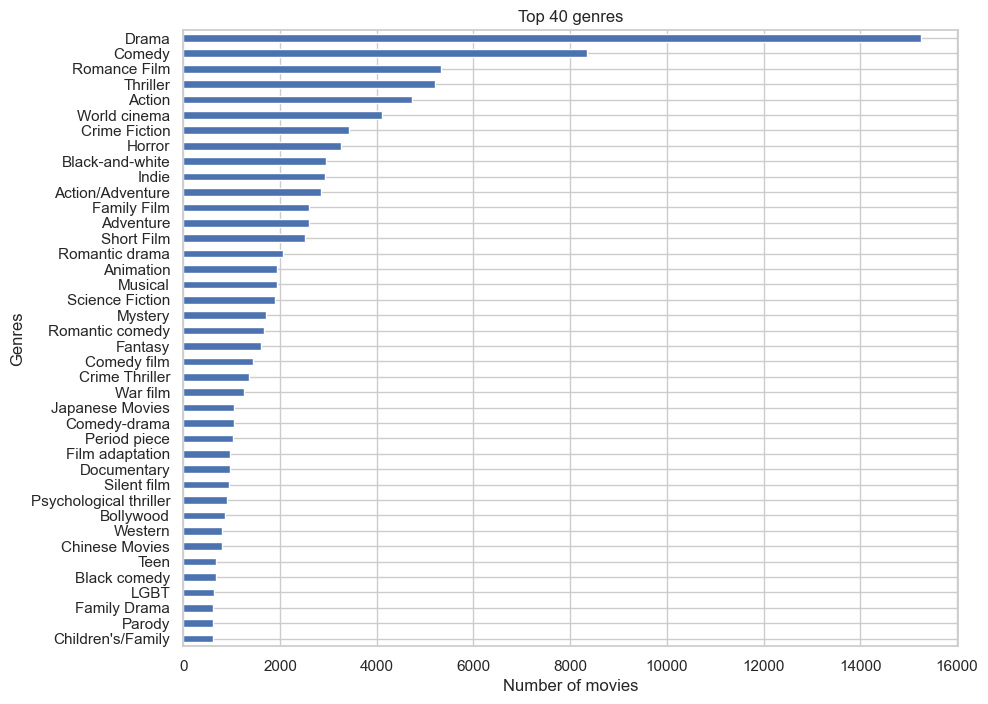

In [8]:
columns_needed = ['Plot', 'Genres', 'merge_year', 'distilbert_emotions']
# we take only the films were the plot is not missing
df_with_plot = df.dropna(subset=['Plot'])[columns_needed]
genre_count = df_with_plot['Genres'].explode().value_counts()
plot_top_genres(genre_count)

To choose the relevant genres, we see that there is quite a natural cluster for genres that belong to more than 2000 Movies. To make analysis that have significant results, we choose only those genres that have more than 2000 movies.

In [9]:
top_genres_df = get_top_genres_df(df_with_plot, genre_count)
genre_emotion_mean_df = get_genre_emotion_mean_df(top_genres_df, emotions)

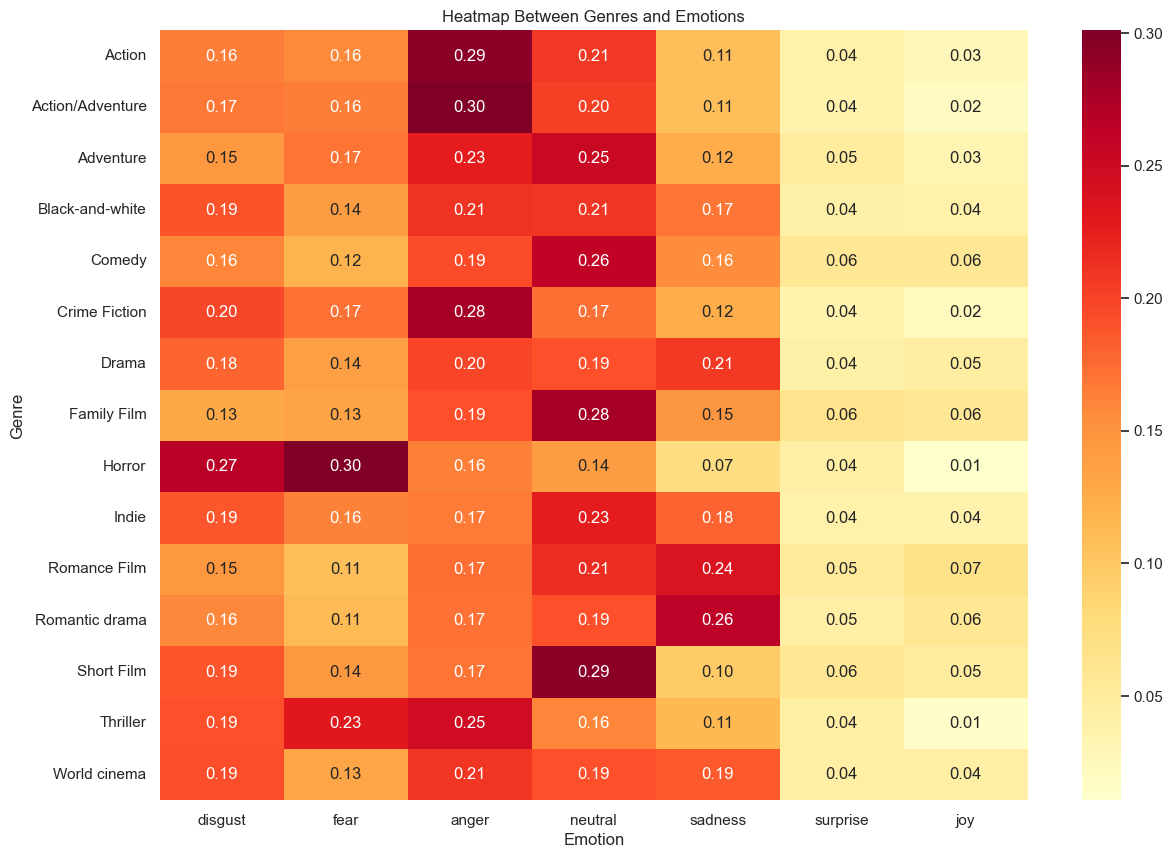

In [10]:
plot_heatmap(genre_emotion_mean_df)

In [11]:
result = manova_genre_emotion_mean_df(emotions_without_neutral, top_genres_df)
result.summary()

<class 'statsmodels.iolib.summary2.Summary'>
"""
                    Multivariate linear model
==================================================================
                                                                  
------------------------------------------------------------------
       Intercept        Value  Num DF   Den DF    F Value   Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.4863 6.0000 68168.0000 12002.9242 0.0000
         Pillai's trace 0.5137 6.0000 68168.0000 12002.9242 0.0000
 Hotelling-Lawley trace 1.0565 6.0000 68168.0000 12002.9242 0.0000
    Roy's greatest root 1.0565 6.0000 68168.0000 12002.9242 0.0000
------------------------------------------------------------------
                                                                  
------------------------------------------------------------------
         Genres         Value   Num DF    Den DF   F Value  Pr > F
------------------------------------------------------------------
          Wilks' lambda 0.8607 84.0000 379954.0376 123.4368 0.0000
         Pillai's trace 0.1458 84.0000 409038.0000 121.2627 0.0000
 Hotelling-Lawley trace 0.1545 84.0000 279139.1349 125.4173 0.0000
    Roy's greatest root 0.0851 14.0000  68173.0000 414.3267 0.0000
==================================================================

"""

We show the score in tone for each genre in comparison with the average score weighted by the number of movies in each genre.

In [12]:
sum_movies = genre_emotion_mean_df['count'].sum()
weight_avg = genre_emotion_mean_df[emotions].mul(genre_emotion_mean_df['count'], axis=0).sum() / sum_movies

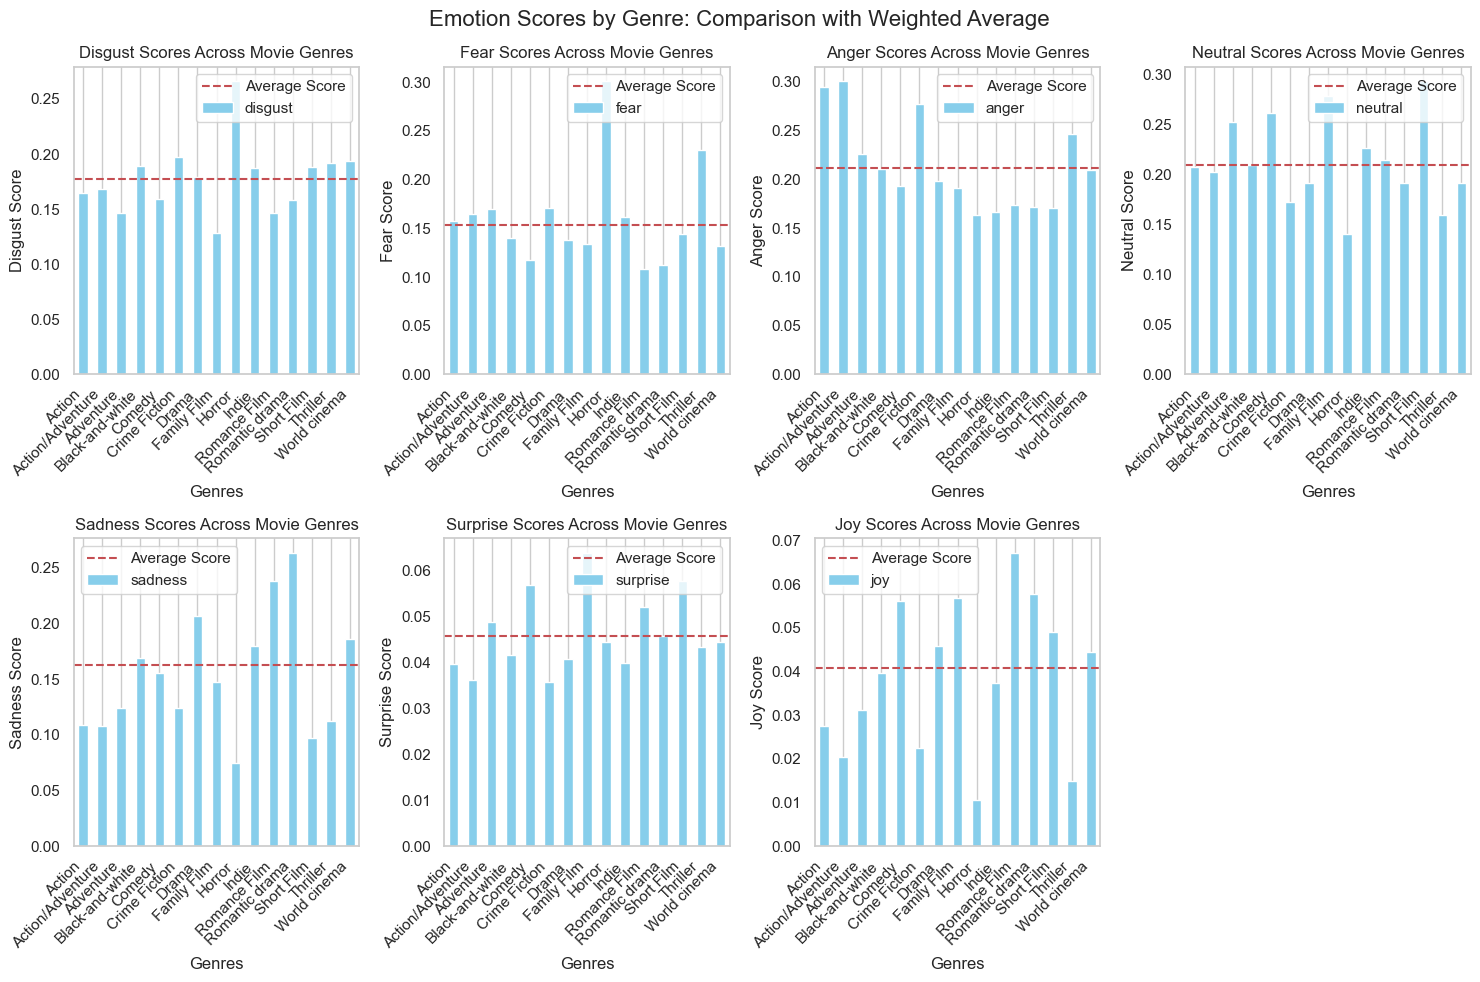

In [13]:
plot_emotion_scores_by_genre(genre_emotion_mean_df, weight_avg, emotions)

We want to understand the predominant tones for each genre, to avoid the bias from the model predictions, we take the emotion that have a statistically significant difference from the average tone by genre using a t-test.

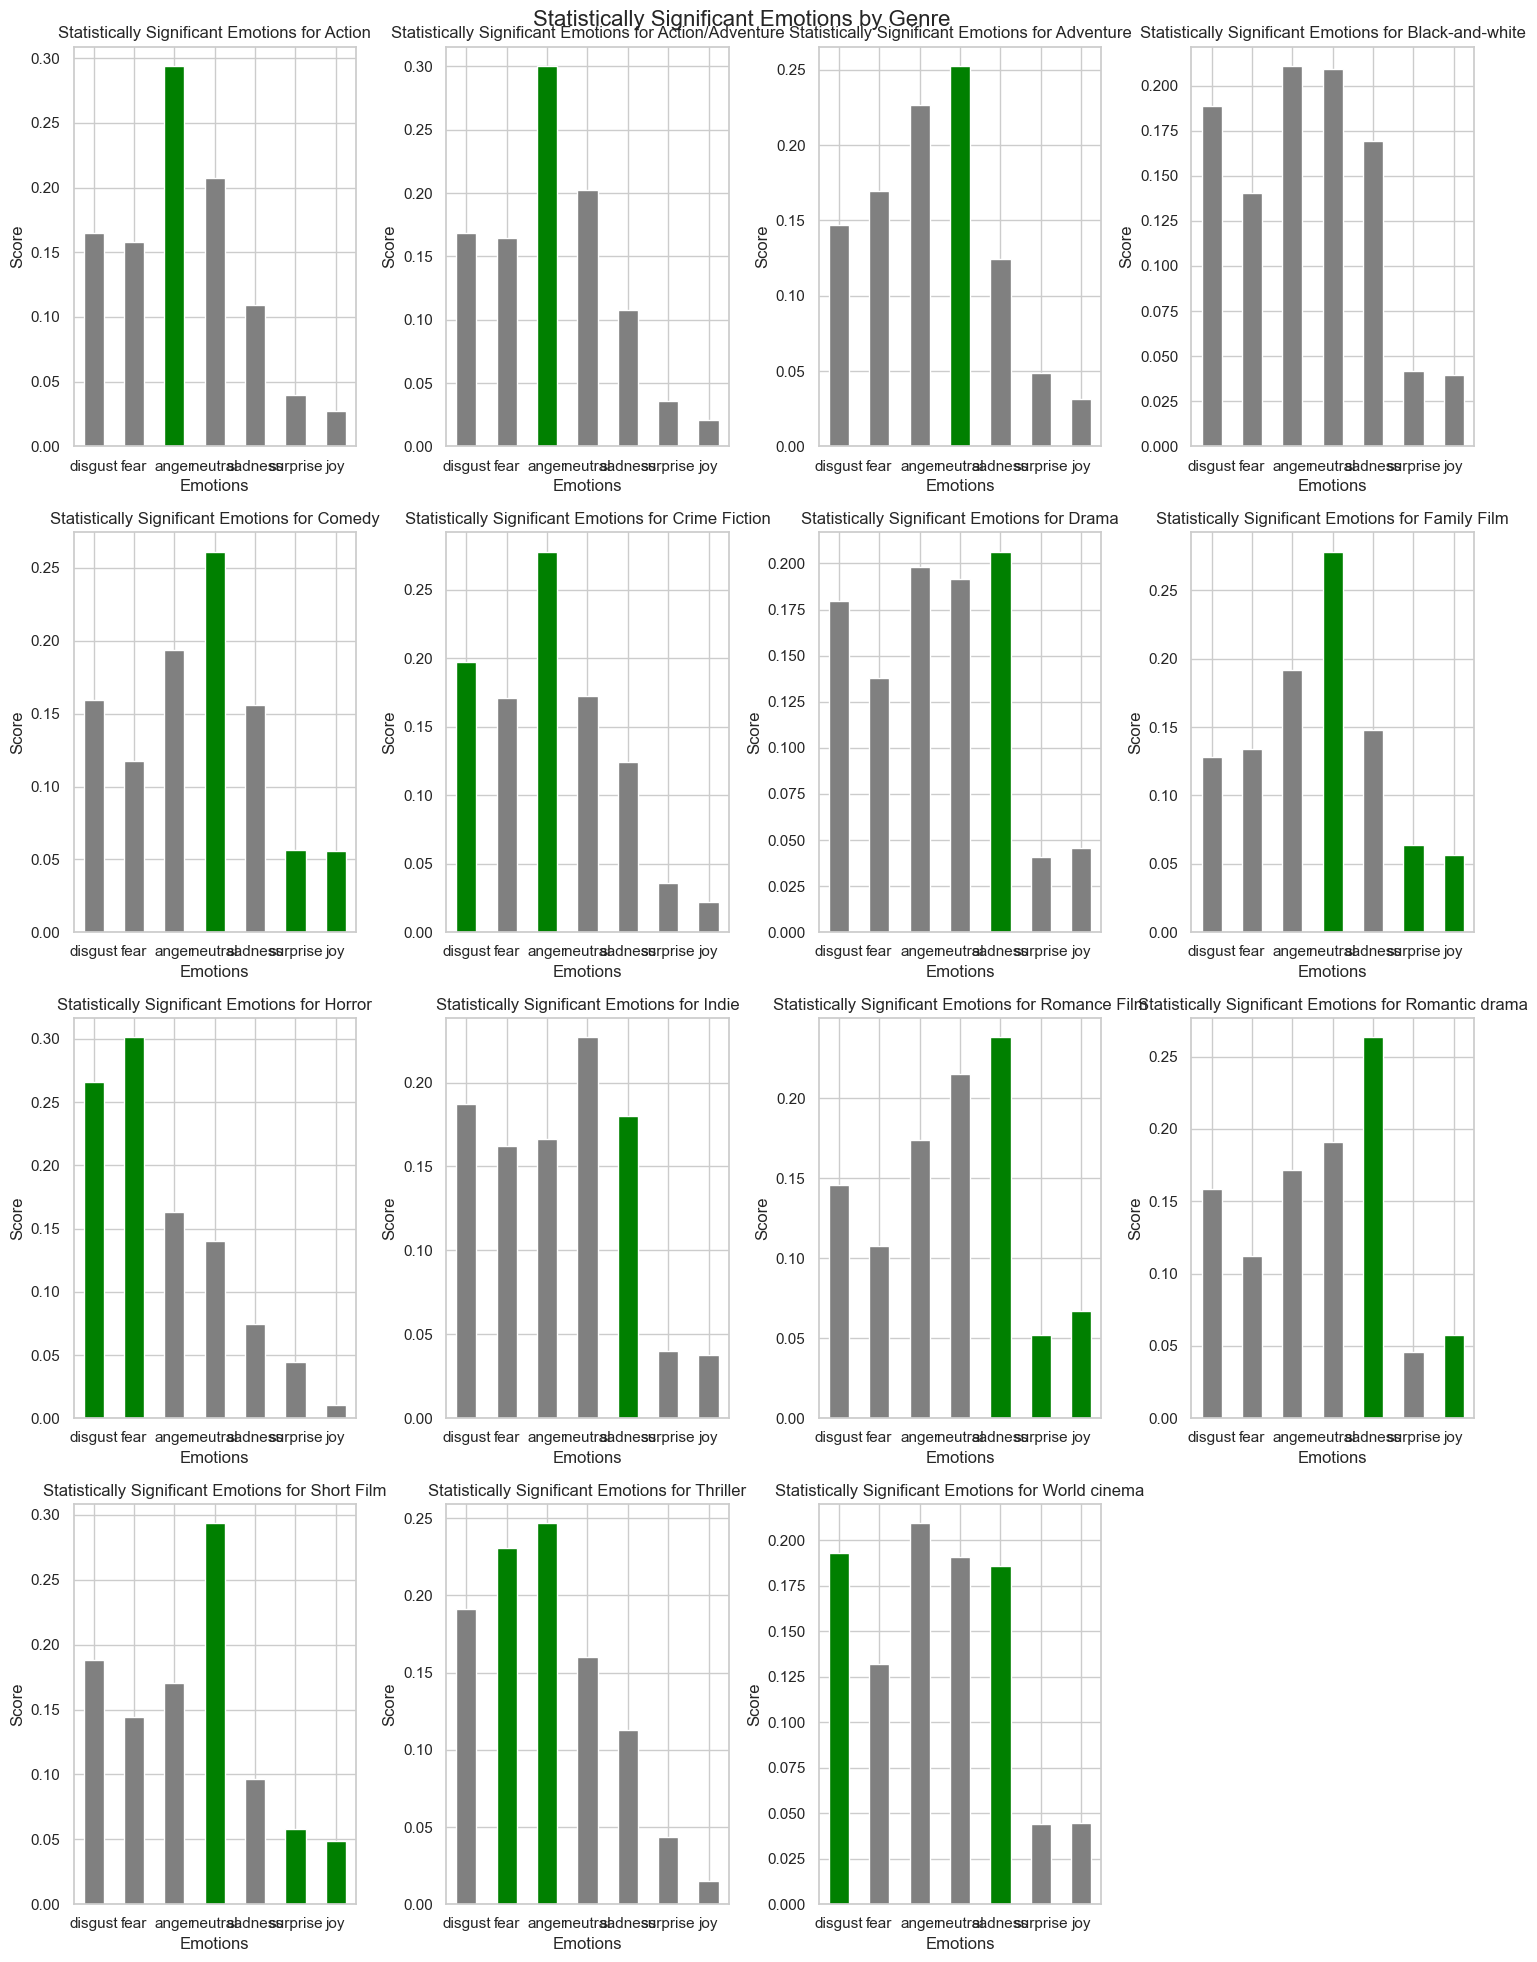

In [14]:
find_significant_emotions_by_genre(genre_emotion_mean_df, weight_avg, emotions)

After analyzing the data, here are the results for each genre:
    Action: The predominant tones is anger, that makes sense, and will we go deeper in trying to understand how the anger emotion changed over time in the time series analysis.

    Action/Adventure: The predominant tones is anger, since the genre is very similar to action, will we only keep the action genre in the time series analysis.

    Adventure: The predominant tones is neutral, al little surprising, but we do not think is interesting to analyse the evolution of a neutral emotion over time. Furthermore, Adveture is still very similar to Action, so we will not keep it in the time series analysis.

    Black-and-White: The is no predominant tone, that make sense, since it does not represent a genre, but a characteristic of the movie. We will not keep it in the time series analysis.

    Comedy: The predominant tones are neutral, surprise and joy, that makes sense, we are not interested in the neutral emotion, but we will keep the surprise and joy emotions in the time series analysis.

    Crime Fiction: The predominant tones are disgust and anger, wi will keep both in the time series analysis.

    Drama: The predominant tones is sadness, make sense, we will keep the sadness emotion in the time series analysis.

    Family Film: The predominant tones are neutral, surprise and joy, that makes sense, we are not interested in the neutral emotion, but we will keep the surprise and joy emotions in the time series analysis.

    Horror: The predominant tones are fear and disgust, we will keep both in the time series analysis.

    Indie: The predominant tones is sadness, make sense, we will keep the sadness emotion in the time series analysis.

    Romance Film: The predominant tones are sadness, joy and surprise, we keep only 2 predominant emotions, sadness and joy, in the time series analysis.

    Romantic Drama: The predominant tones are sadness and joy, since this genre is very similar to Romance Film, we will not keep it in the time series analysis.

    Short Film: The predominant tones are neutral, surprise and joy, we do not think this genre is worth analyze, like 'Black-and-White', it does not represent a genre, but a characteristic of the movie. We will not keep it in the time series analysis.

    Thriller: The predominant tones are fear and anger, we will keep both in the time series analysis.

    World cinema: This genre represent film made outside American motion picture industry, particularly those in opposition to the aesthetic and values of the Hollywood mainstream, so we keep it to have an understanding of what is the overall emotion outside the mainstream Hollywood movies. The predominant tones are sadness and disgust, we will keep both in the time series analysis.

## 2. How has the emotional tone of films evolved over time within each genre?

In [15]:
emotion_by_time = get_time_series_data(emotions_df, emotions)

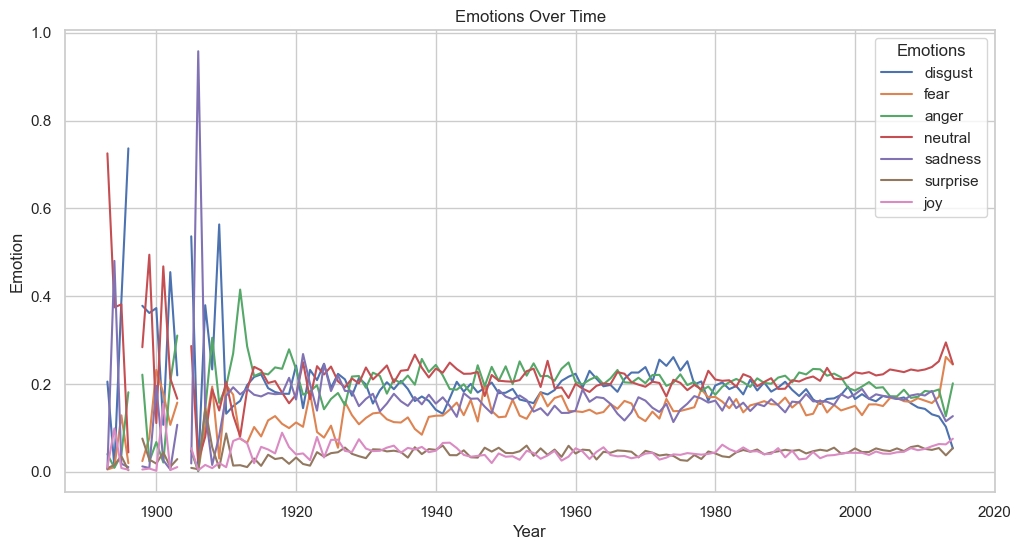

In [16]:
plot_emotions_by_time(emotion_by_time)

<Axes: xlabel='merge_year', ylabel='Count'>

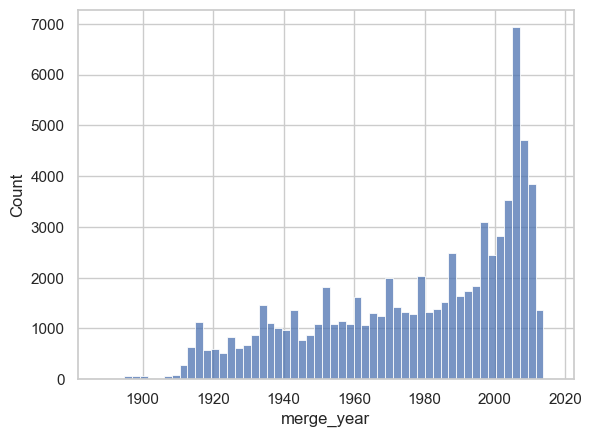

In [17]:
sns.histplot(emotions_df['merge_year'], kde=False)

In [18]:
movie_counts_by_time = get_movie_counts_by_time(emotions_df)
movie_counts_by_time[movie_counts_by_time.index >= 2010]

counts
merge_year        
2010          2024
2011          1824
2012          1195
2013           164
2014            17
2015             4
2016             3

In [19]:
emotions_by_relevant_time = emotion_by_time[(emotion_by_time.index >= 1925) & (emotion_by_time.index < 2012)]

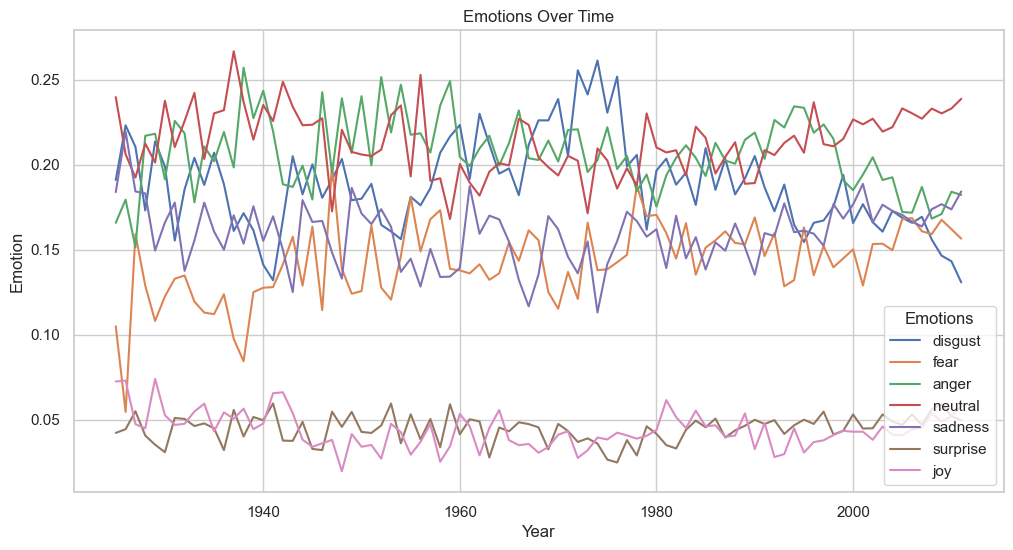

In [20]:
plot_emotions_by_time(emotions_by_relevant_time)

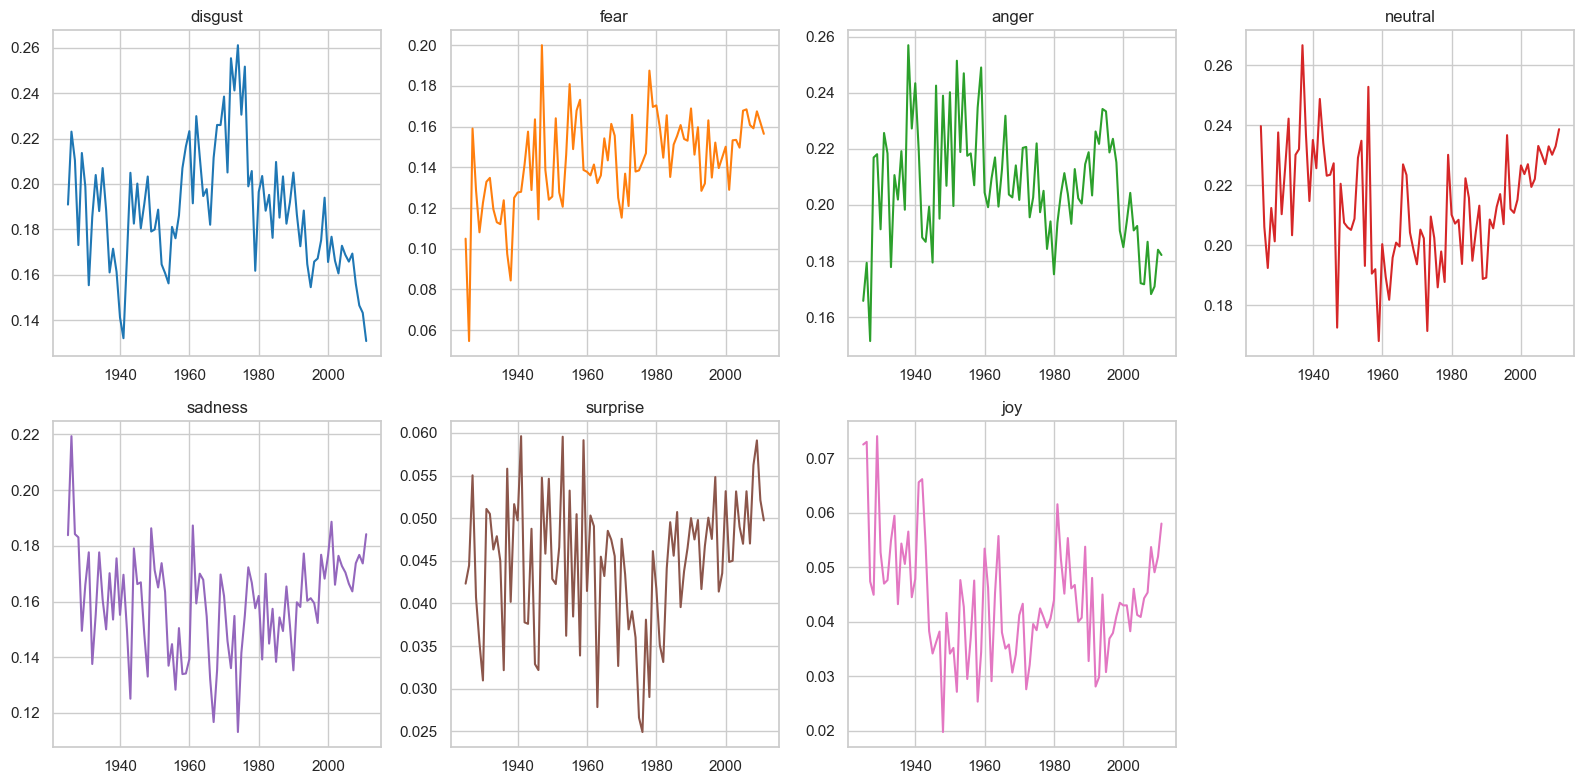

In [21]:
plot_indiv_emotions_by_time(emotions_by_relevant_time)

#### Now let's try to gain a deeper understanding and even make some predictions with time series analysis

In [22]:
genres_emotions_mapping = {
    "Action": ["anger"],
    "Comedy": ["surprise", "joy"],
    "Crime Fiction": ["disgust", "anger"],
    "Drama": ["sadness"],
    "Family Film": ["surprise", "joy"],
    "Horror": ["fear", "disgust"],
    "Indie": ["sadness"],
    "Romance Film": ["sadness", "joy"],
    "Thriller": ["fear", "anger"],
    "World cinema": ["sadness", "disgust"]
}

genre_timeseries_df = get_timeseries_by_genre(emotions_df, genre_count, genres_emotions_mapping, emotions)
# e.g. genre_timeseries_df[genre_timeseries_df['Genres'] == 'World cinema']

In [23]:
# Dividing the data into separate dataframes to separate the time series analysis 
genre_dataframes = {}

for genre, emotions in genres_emotions_mapping.items():
    genre_data = genre_timeseries_df[genre_timeseries_df["Genres"] == genre]
    genre_dataframes[genre] = genre_data[["merge_year"] + emotions].dropna()

action_timeseries_df = genre_dataframes["Action"]
comedy_timeseries_df = genre_dataframes["Comedy"]
crime_fiction_timeseries_df = genre_dataframes["Crime Fiction"]
drama_timeseries_df = genre_dataframes["Drama"]
family_film_timeseries_df = genre_dataframes["Family Film"]
horror_timeseries_df = genre_dataframes["Horror"]
indie_timeseries_df = genre_dataframes["Indie"]
romance_flim_timeseries_df = genre_dataframes["Romance Film"]
thriller_timeseries_df = genre_dataframes["Thriller"]
world_cinema_timeseries_df = genre_dataframes["World cinema"]

#### Action movies Time Series Analysis

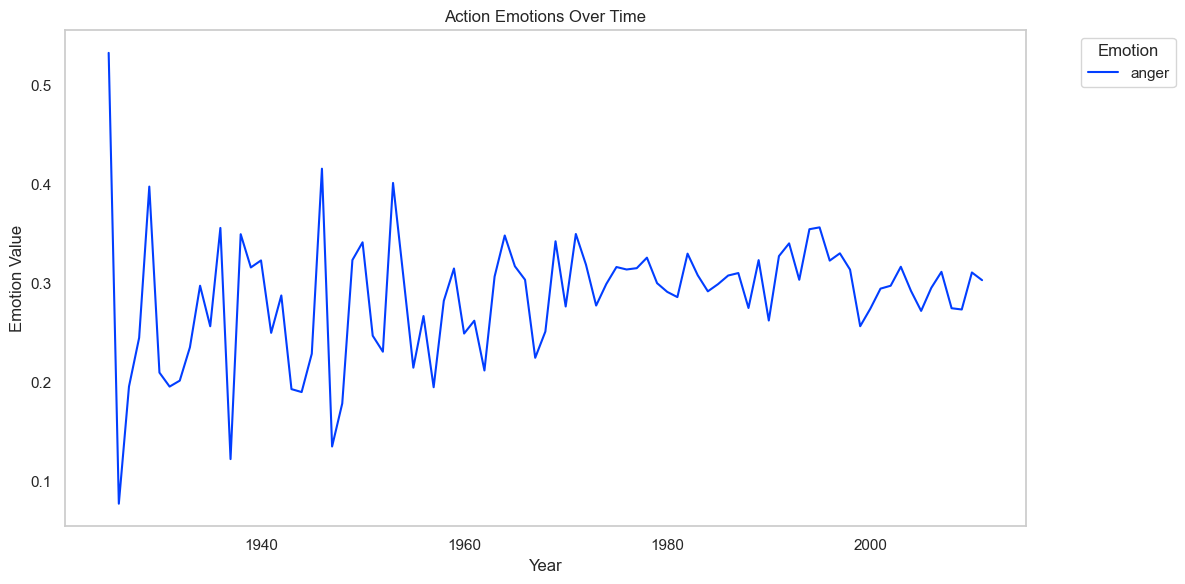

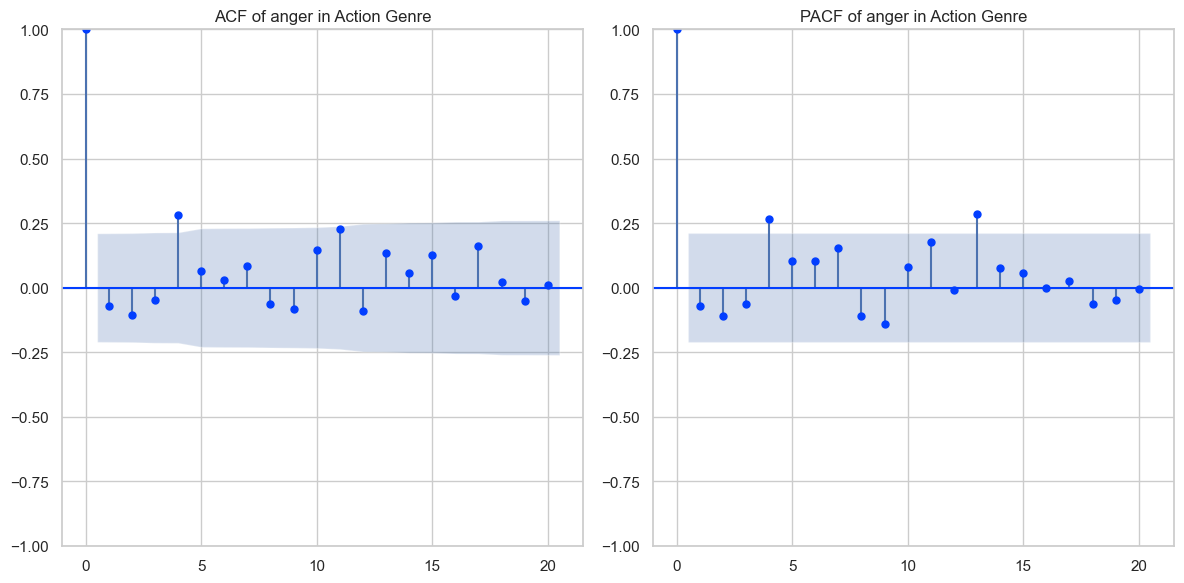

##########################################
 Performing Box-Jenkins Procedure for anger in Action Genre
ADF Statistic: -1.7887471533083865
p-value: 0.3860625573236642
The series is not stationary and needs to be differenced.
Best ARIMA Order for anger in Action Genre: (3, 1, 1)


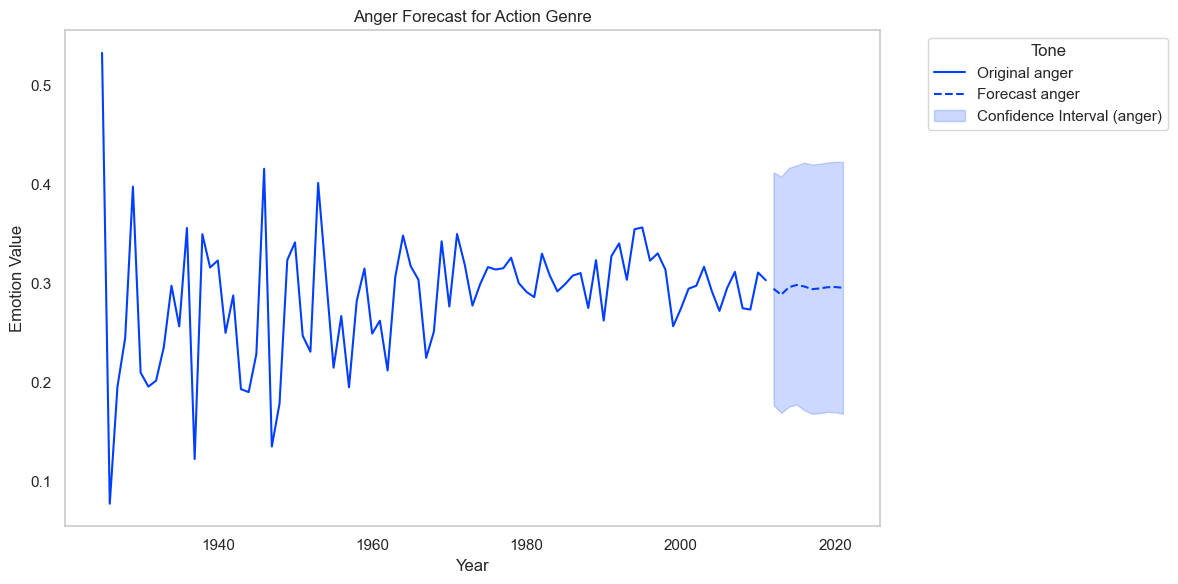

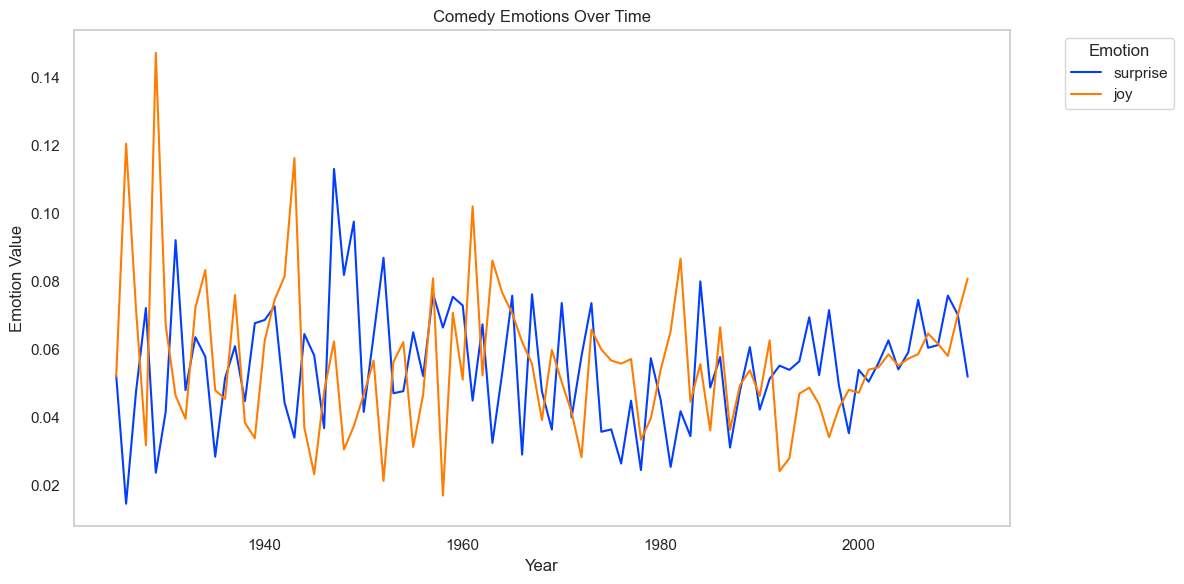

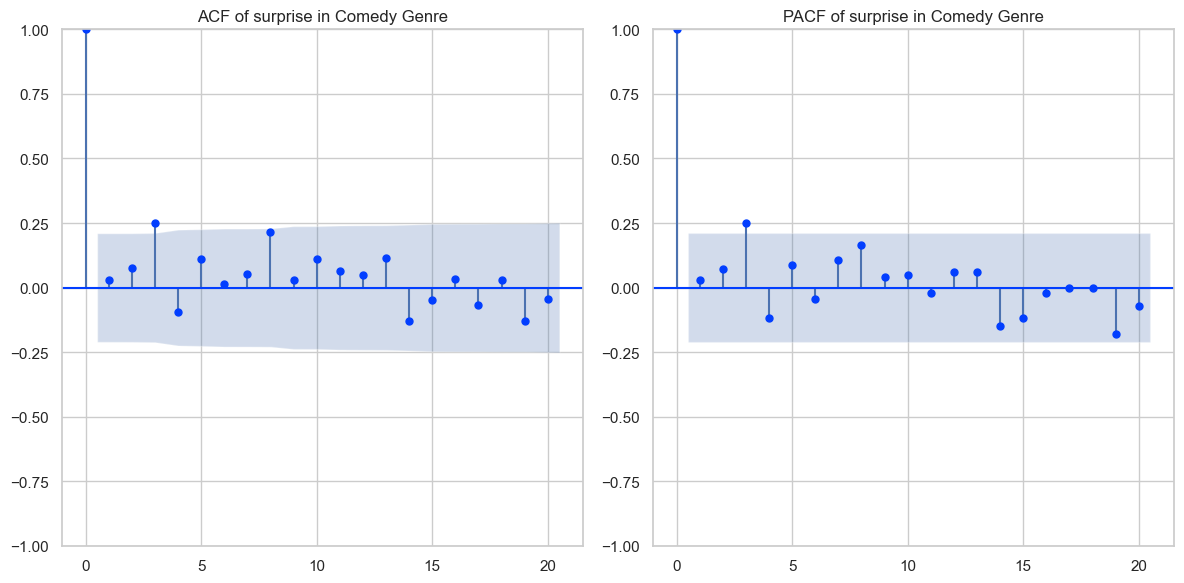

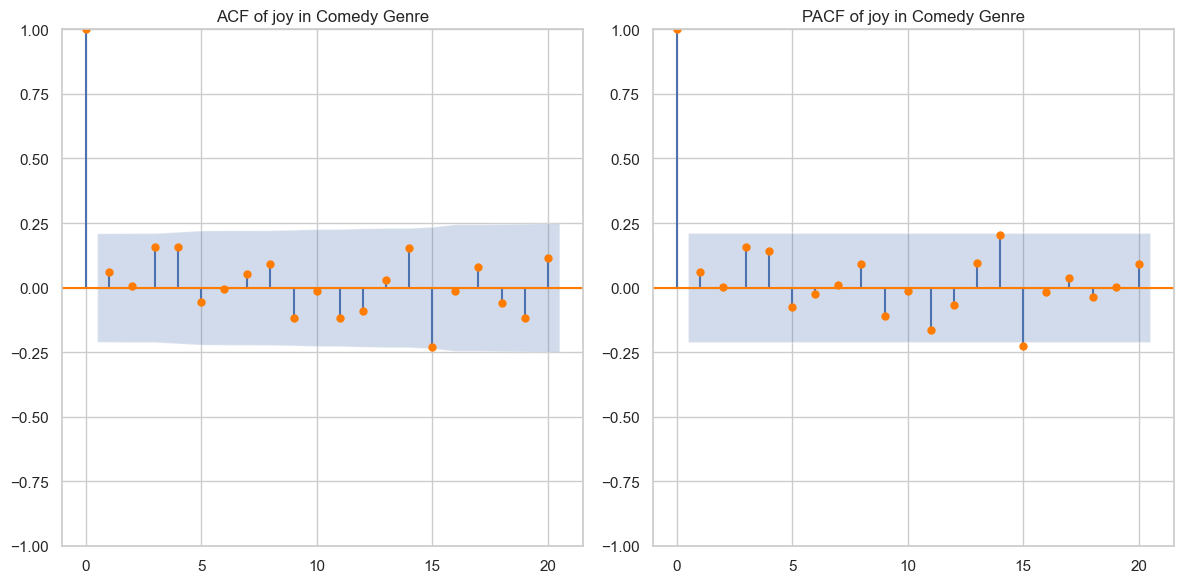

##########################################
 Performing Box-Jenkins Procedure for surprise in Comedy Genre
ADF Statistic: -3.8855435796211504
p-value: 0.002143852219967682
Best ARIMA Order for surprise in Comedy Genre: (3, 0, 0)
##########################################
 Performing Box-Jenkins Procedure for joy in Comedy Genre
ADF Statistic: -8.5479135141675
p-value: 9.393303846546055e-14
Best ARIMA Order for joy in Comedy Genre: (1, 0, 0)


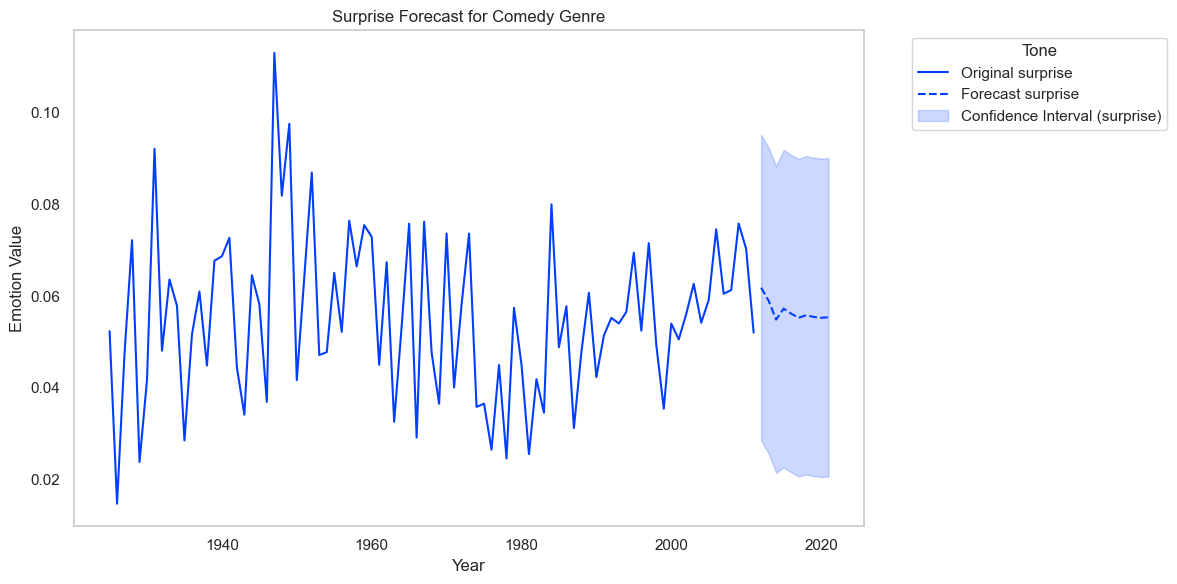

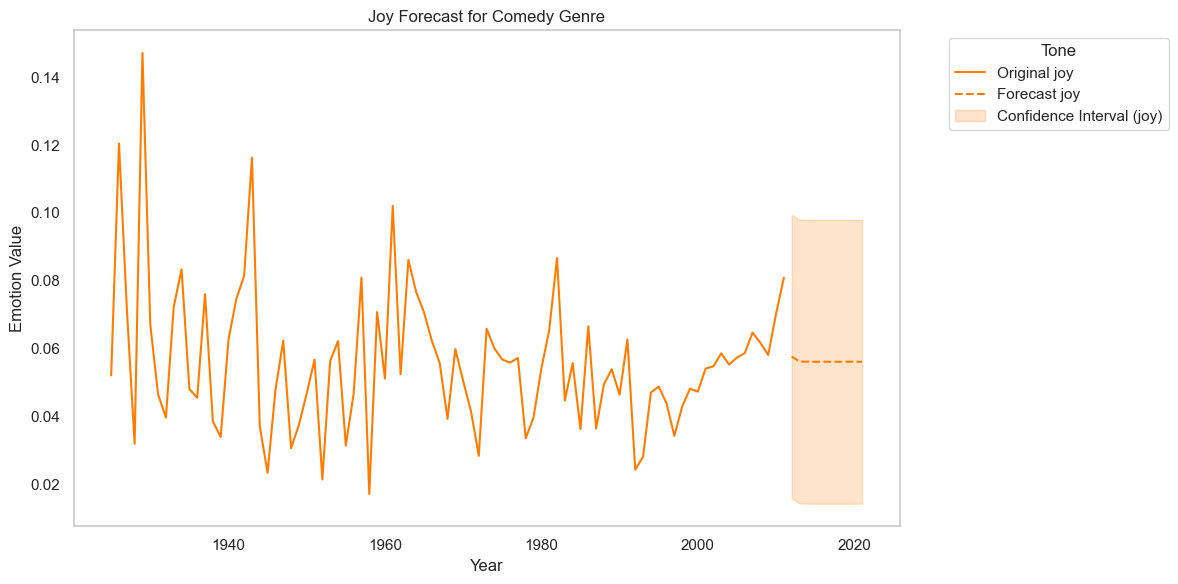

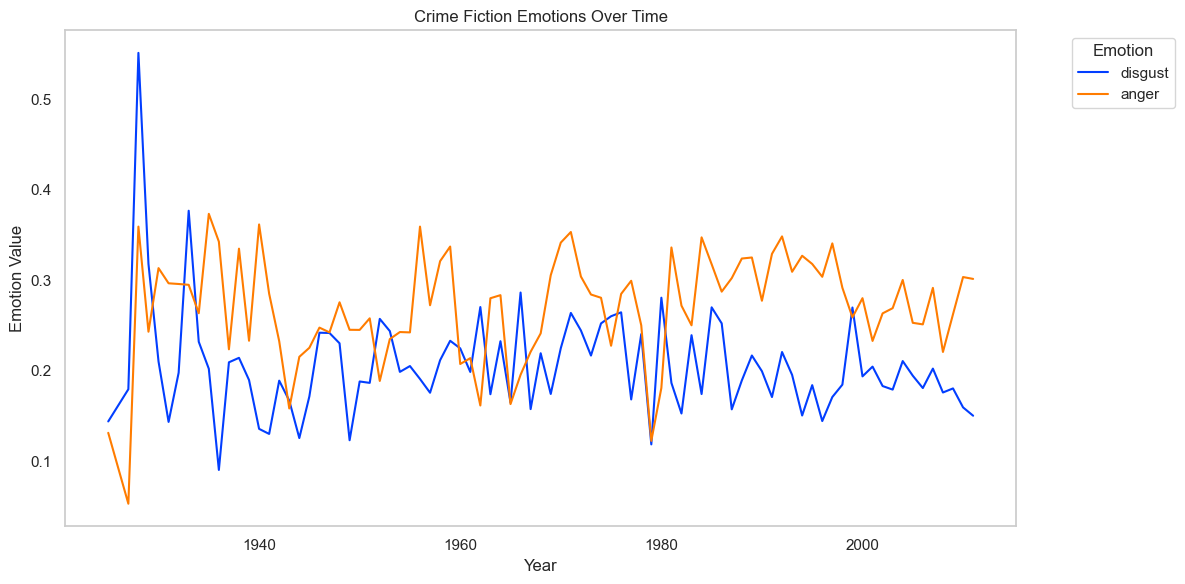

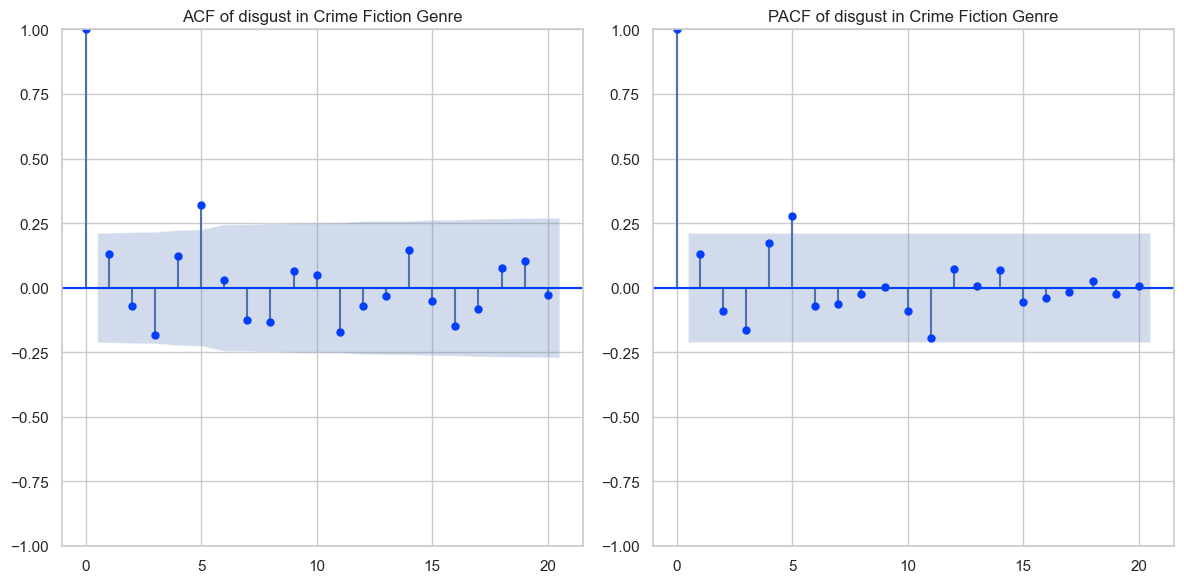

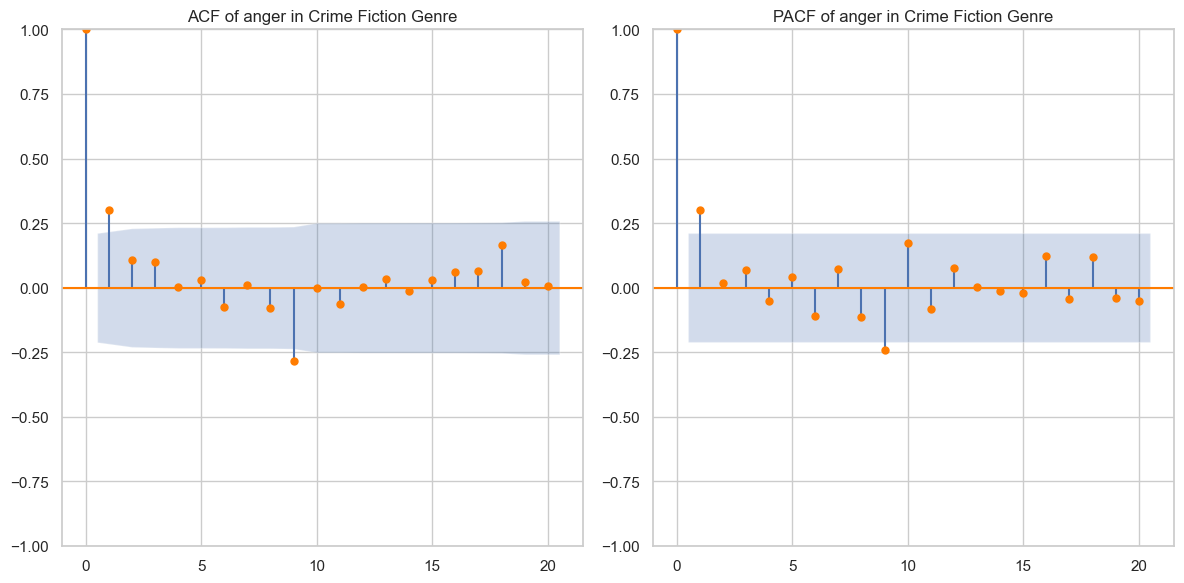

##########################################
 Performing Box-Jenkins Procedure for disgust in Crime Fiction Genre
ADF Statistic: -6.484593942005353
p-value: 1.2701419125844923e-08
Best ARIMA Order for disgust in Crime Fiction Genre: (3, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for anger in Crime Fiction Genre
ADF Statistic: -6.914634533444469
p-value: 1.1881064710608043e-09
Best ARIMA Order for anger in Crime Fiction Genre: (1, 0, 0)


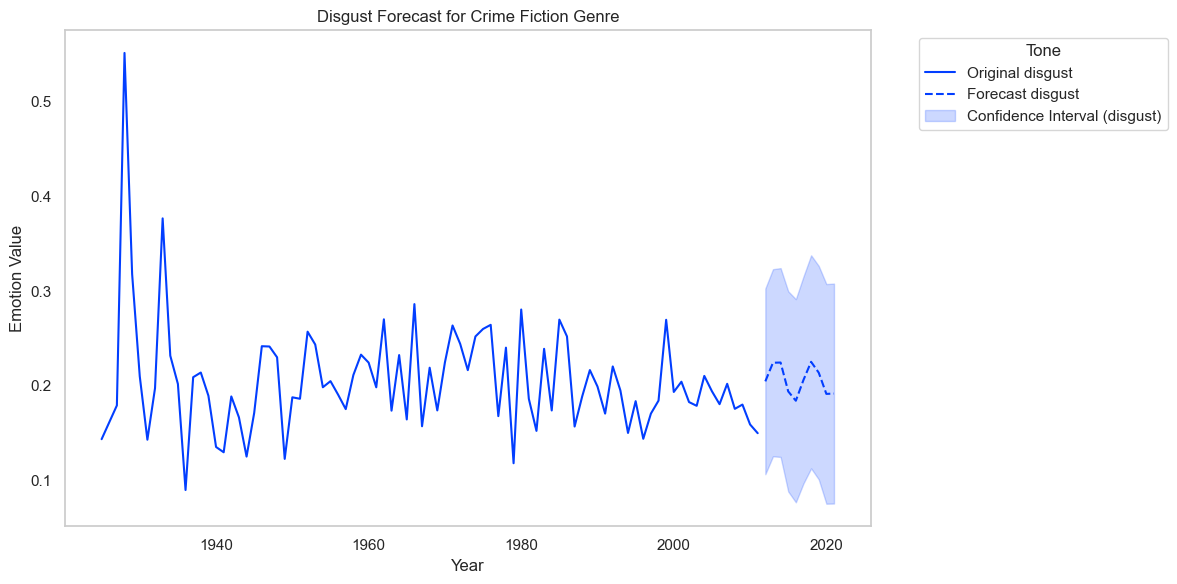

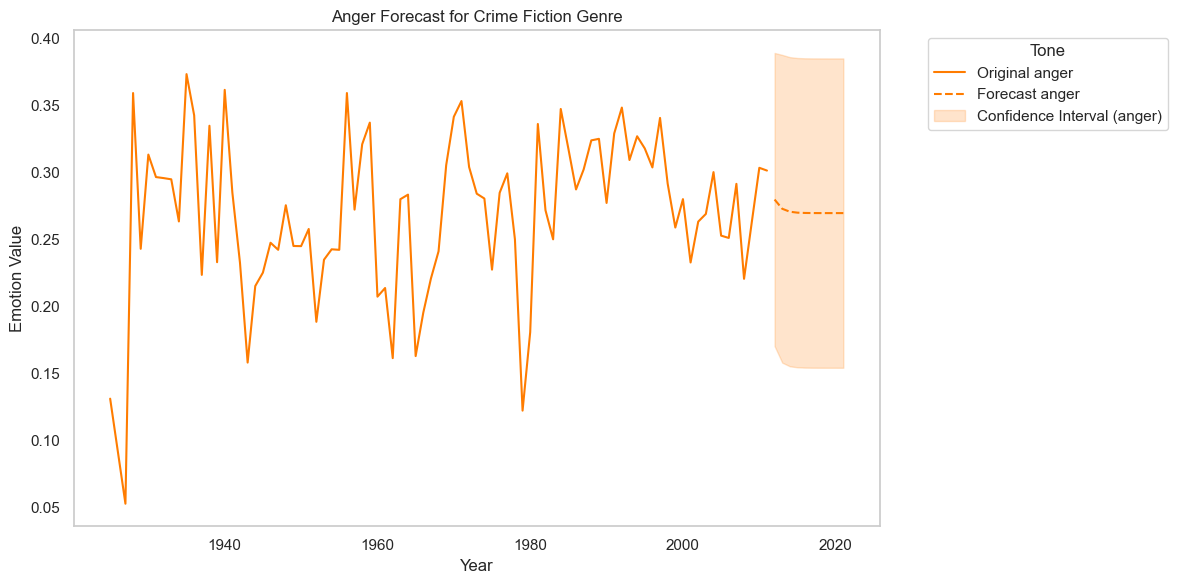

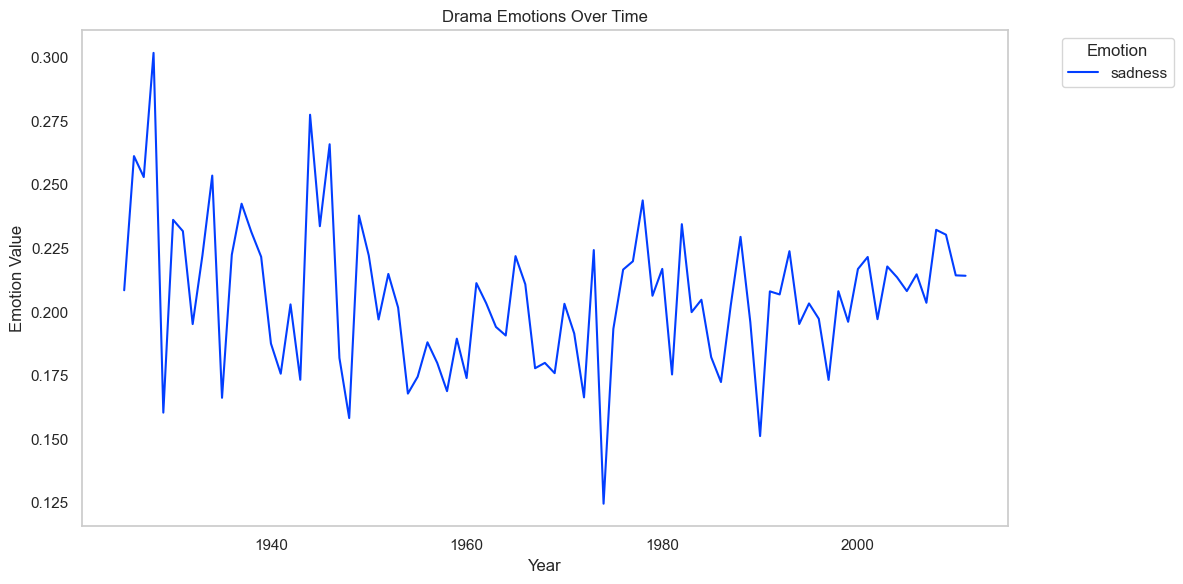

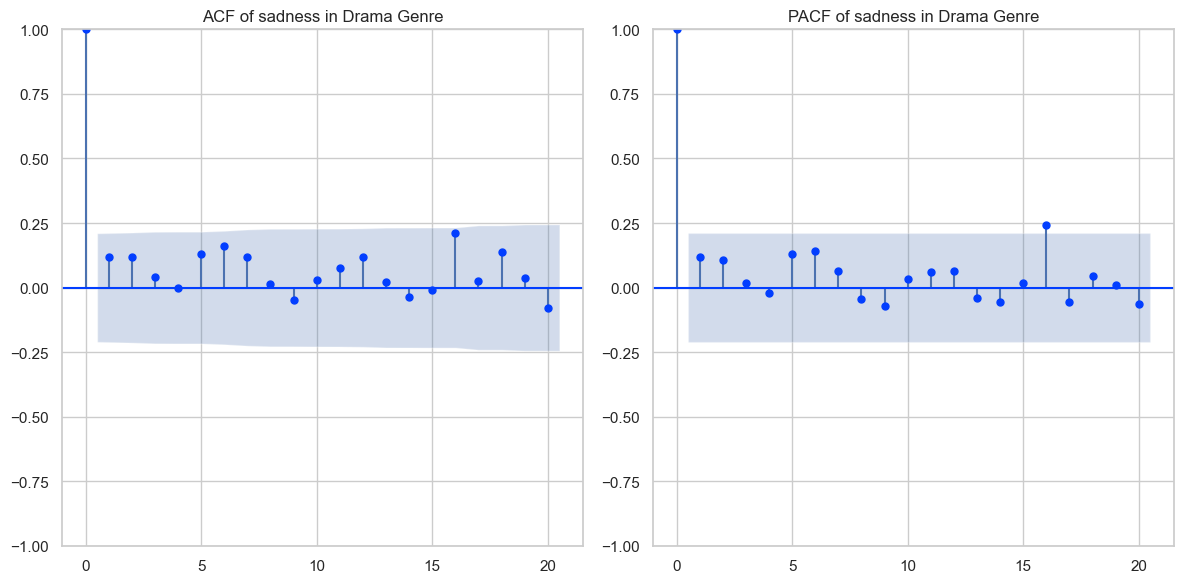

##########################################
 Performing Box-Jenkins Procedure for sadness in Drama Genre
ADF Statistic: -8.131424158962504
p-value: 1.0876387226298501e-12
Best ARIMA Order for sadness in Drama Genre: (1, 0, 1)


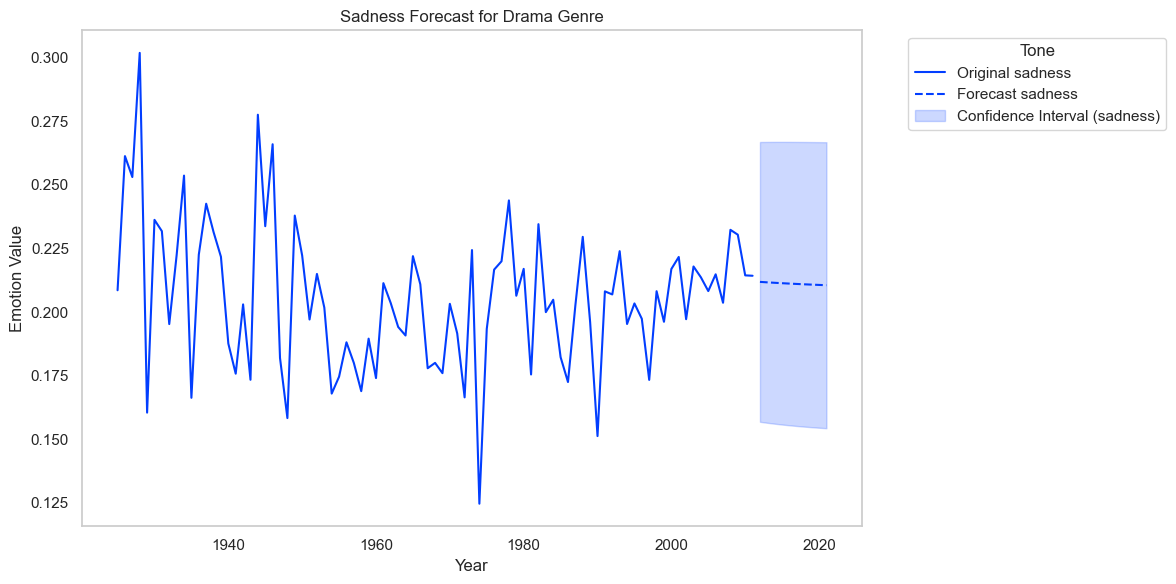

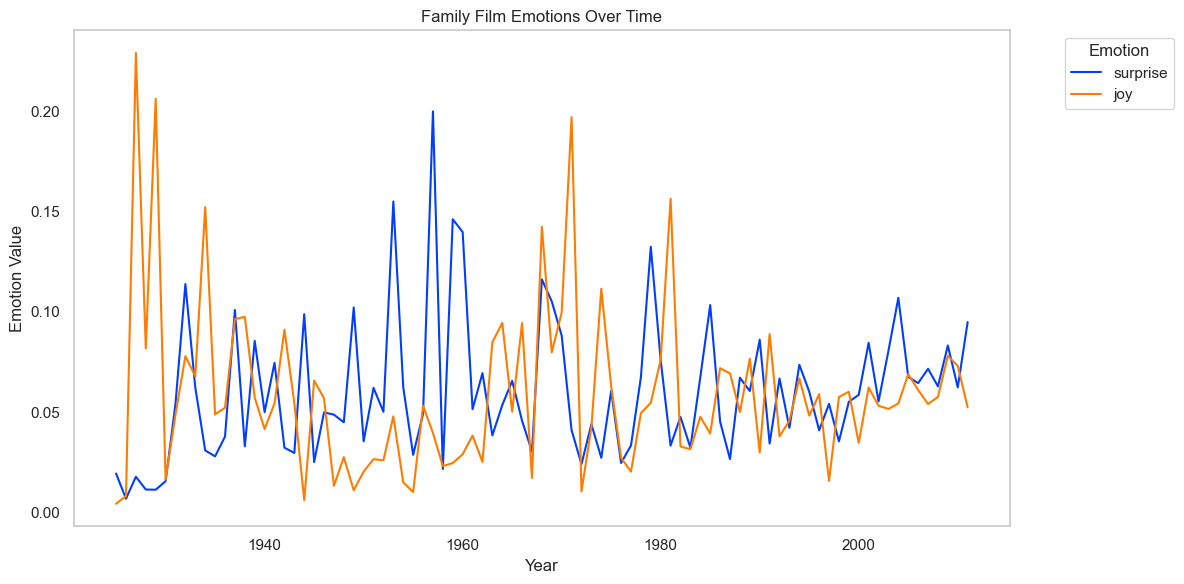

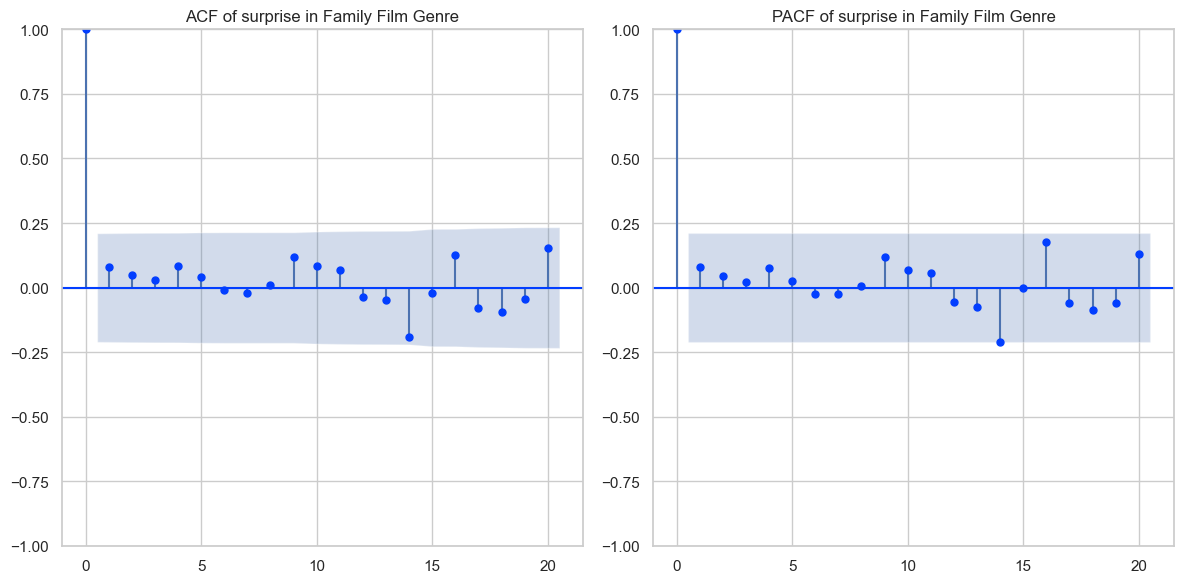

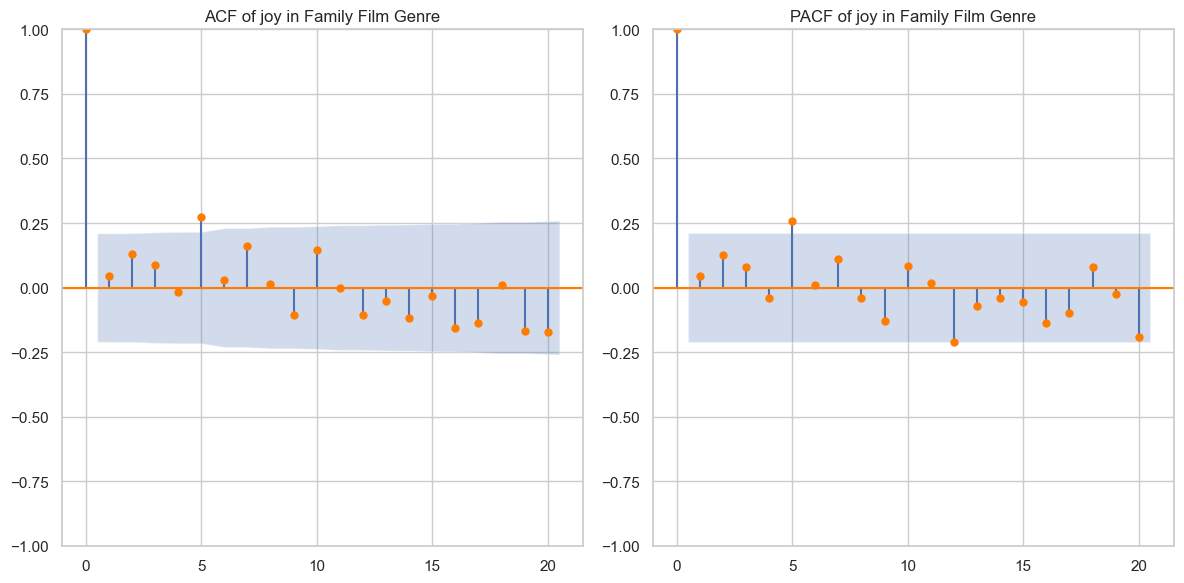

##########################################
 Performing Box-Jenkins Procedure for surprise in Family Film Genre
ADF Statistic: -8.473655078539824
p-value: 1.4548682542497528e-13
Best ARIMA Order for surprise in Family Film Genre: (1, 0, 0)
##########################################
 Performing Box-Jenkins Procedure for joy in Family Film Genre
ADF Statistic: -4.269389640840535
p-value: 0.0005016691687662584
Best ARIMA Order for joy in Family Film Genre: (3, 0, 1)


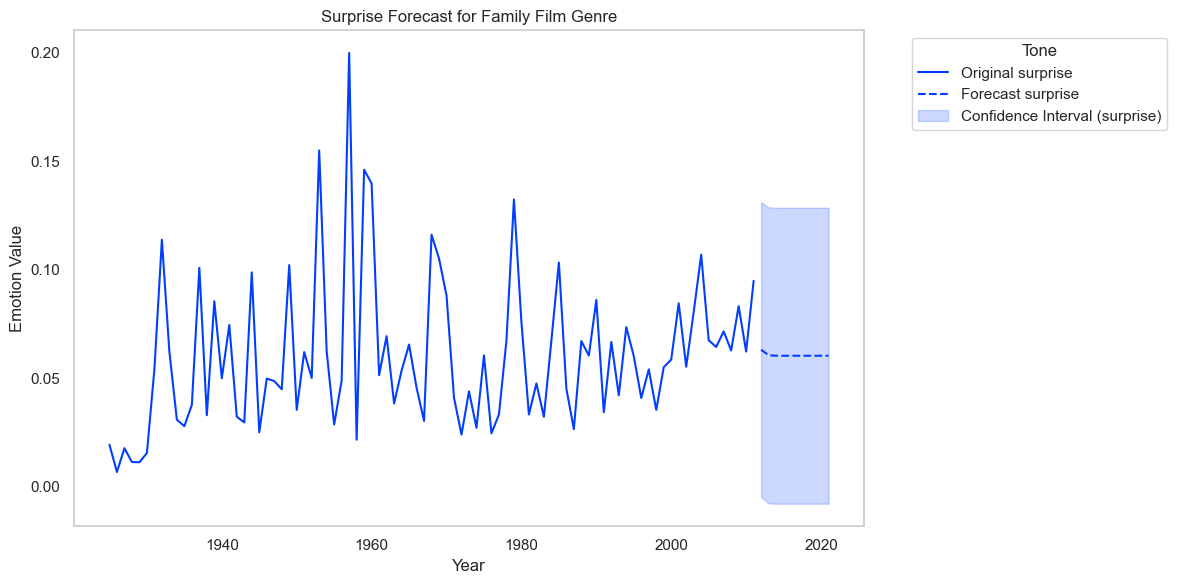

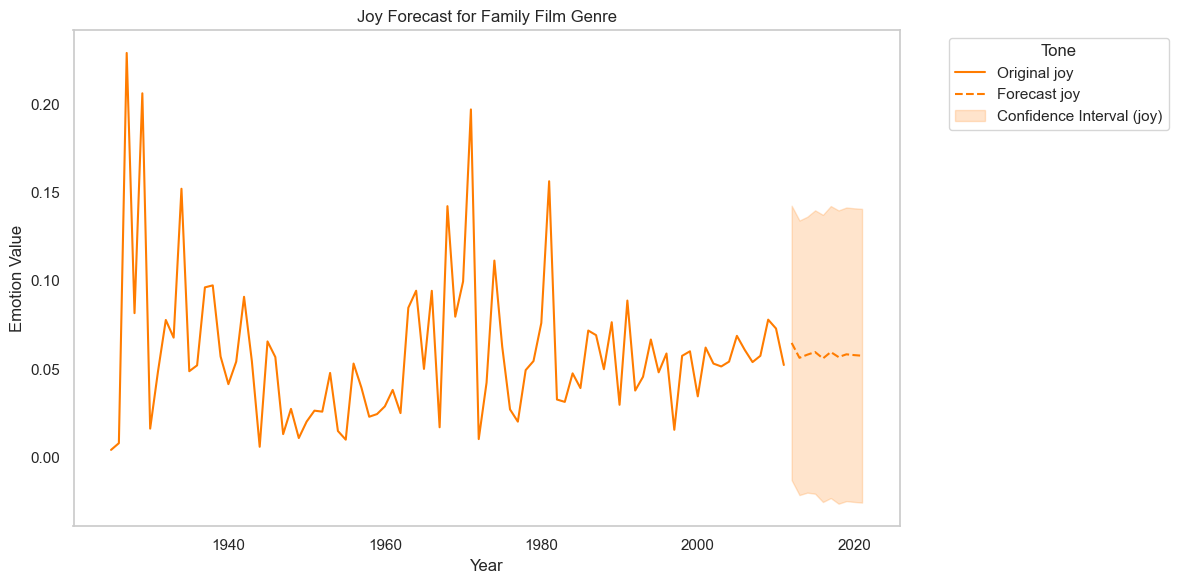

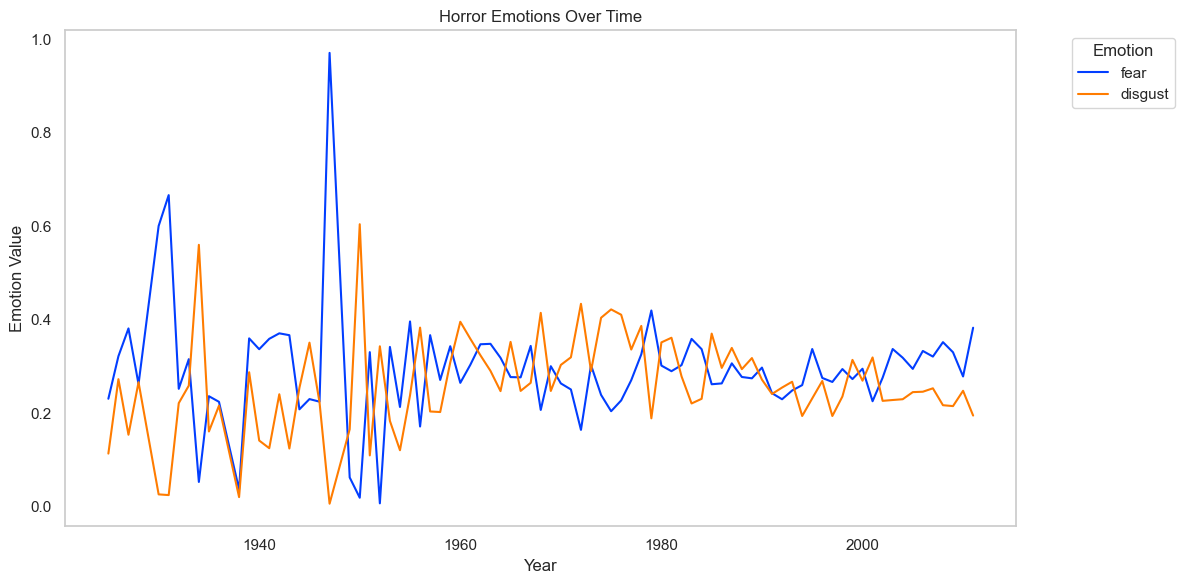

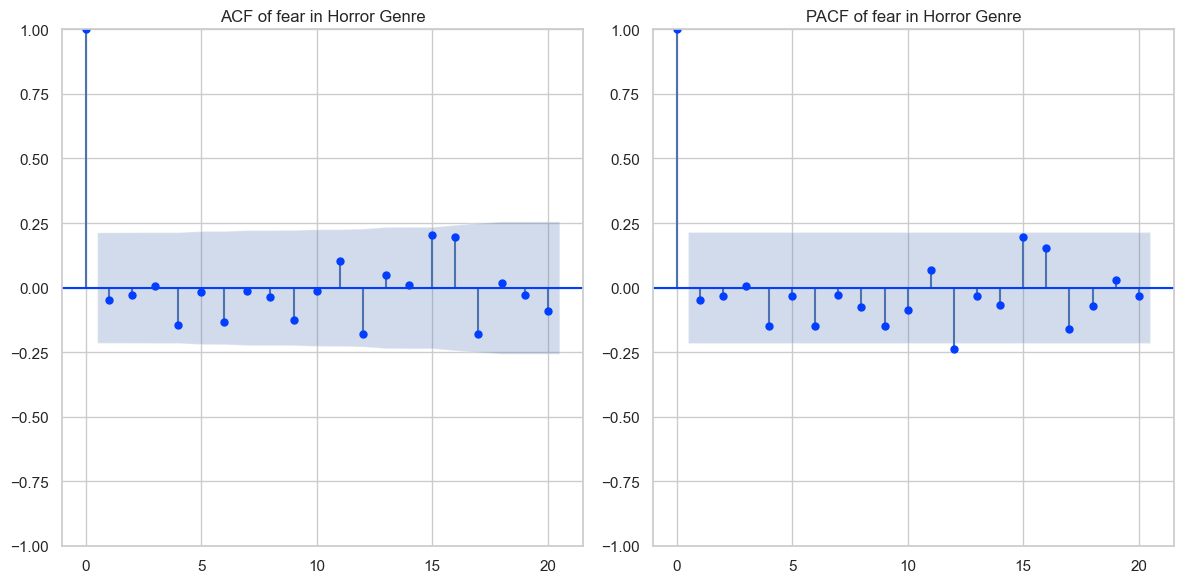

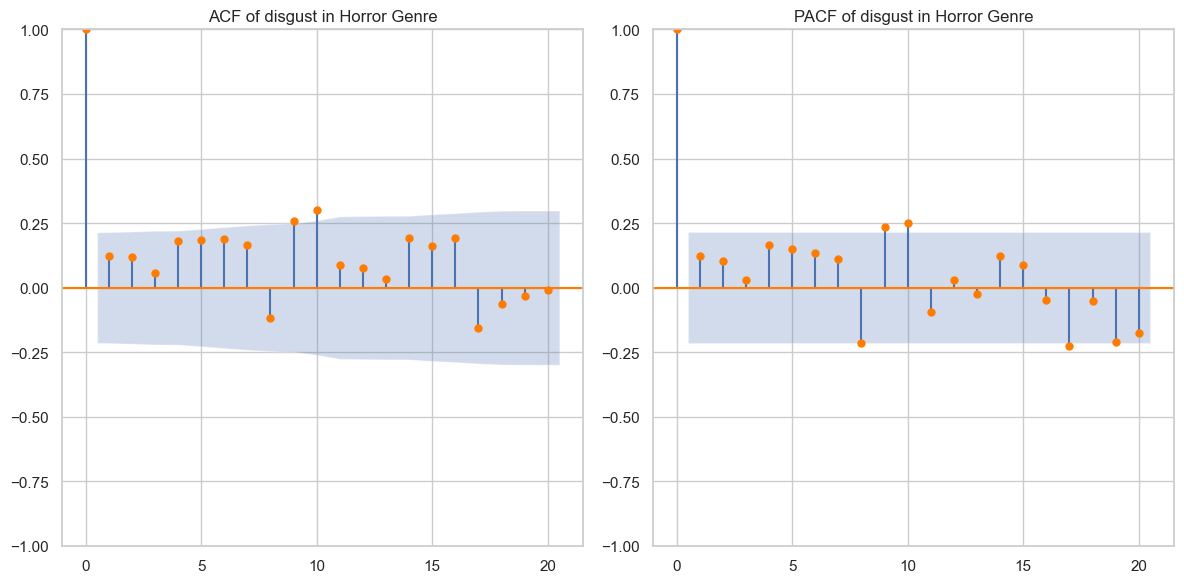

##########################################
 Performing Box-Jenkins Procedure for fear in Horror Genre
ADF Statistic: -9.4282225003187
p-value: 5.275646181909373e-16
Best ARIMA Order for fear in Horror Genre: (1, 0, 1)
##########################################
 Performing Box-Jenkins Procedure for disgust in Horror Genre
ADF Statistic: -1.0727583574924497
p-value: 0.7258124187609374
The series is not stationary and needs to be differenced.
Best ARIMA Order for disgust in Horror Genre: (1, 1, 1)


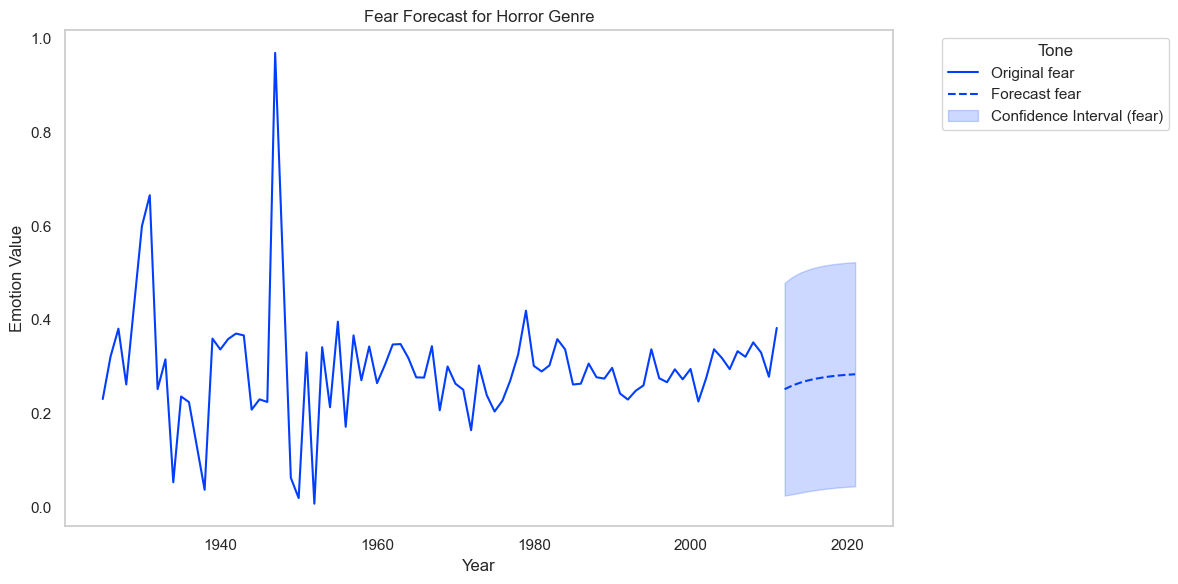

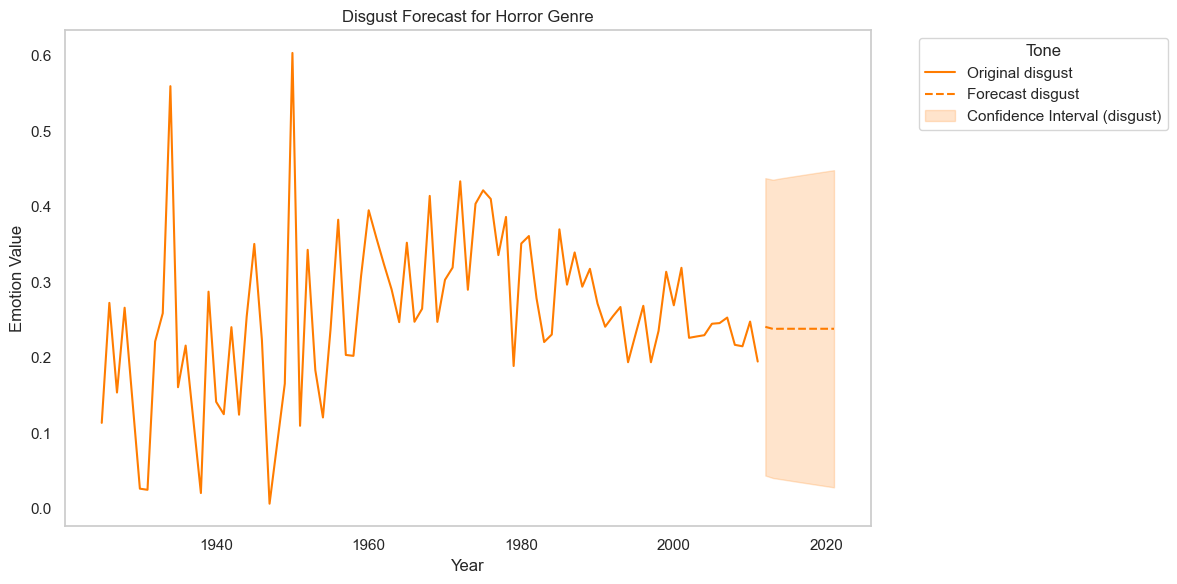

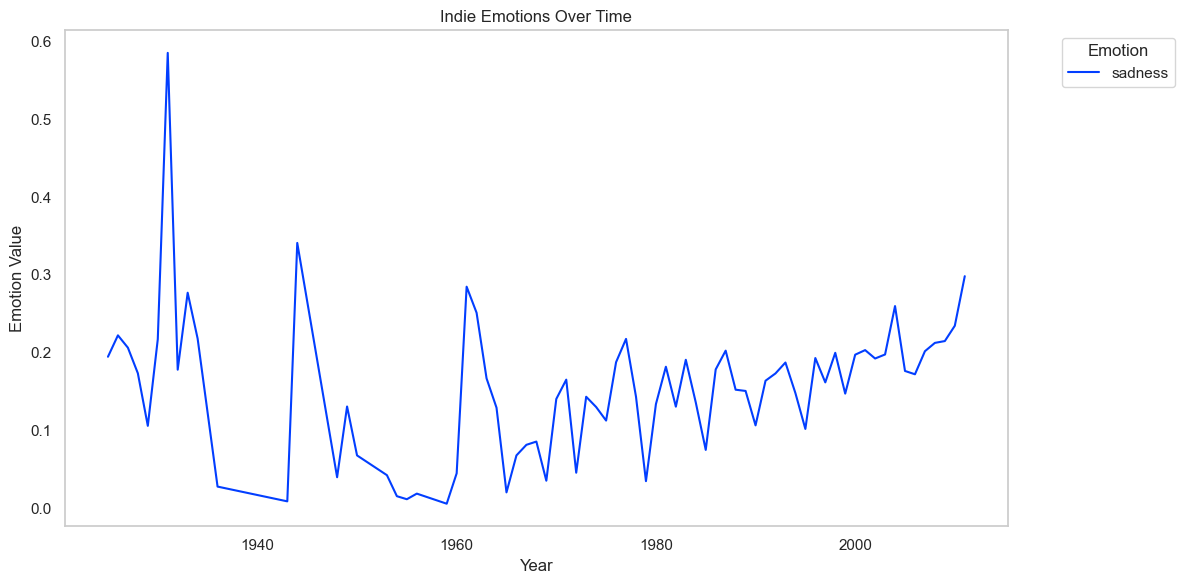

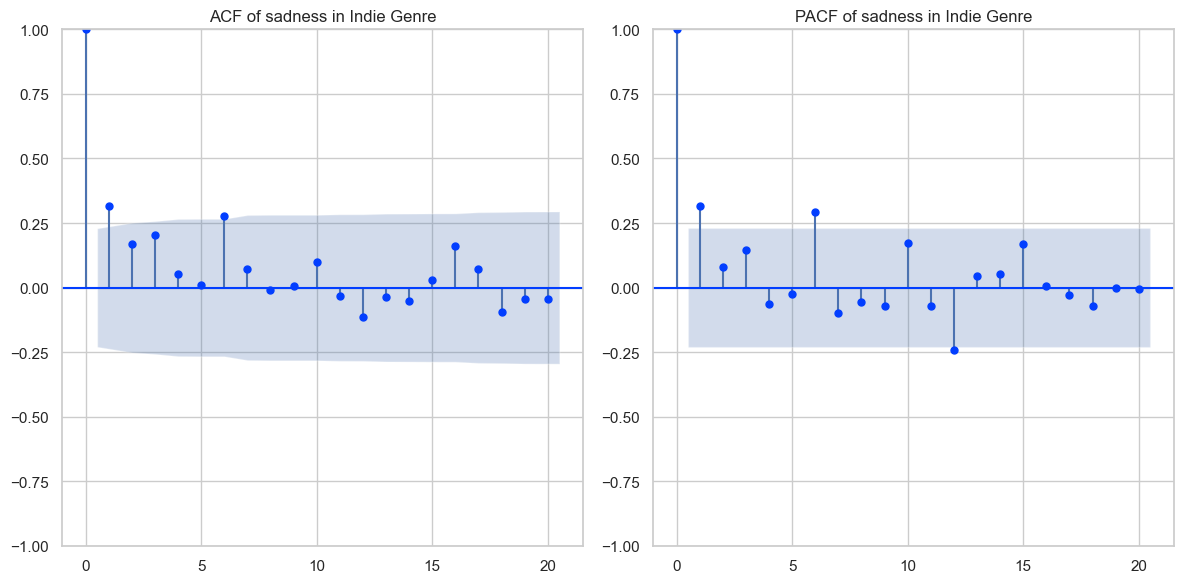

##########################################
 Performing Box-Jenkins Procedure for sadness in Indie Genre
ADF Statistic: -4.29024286190546
p-value: 0.00046181560314715654
Best ARIMA Order for sadness in Indie Genre: (3, 0, 2)


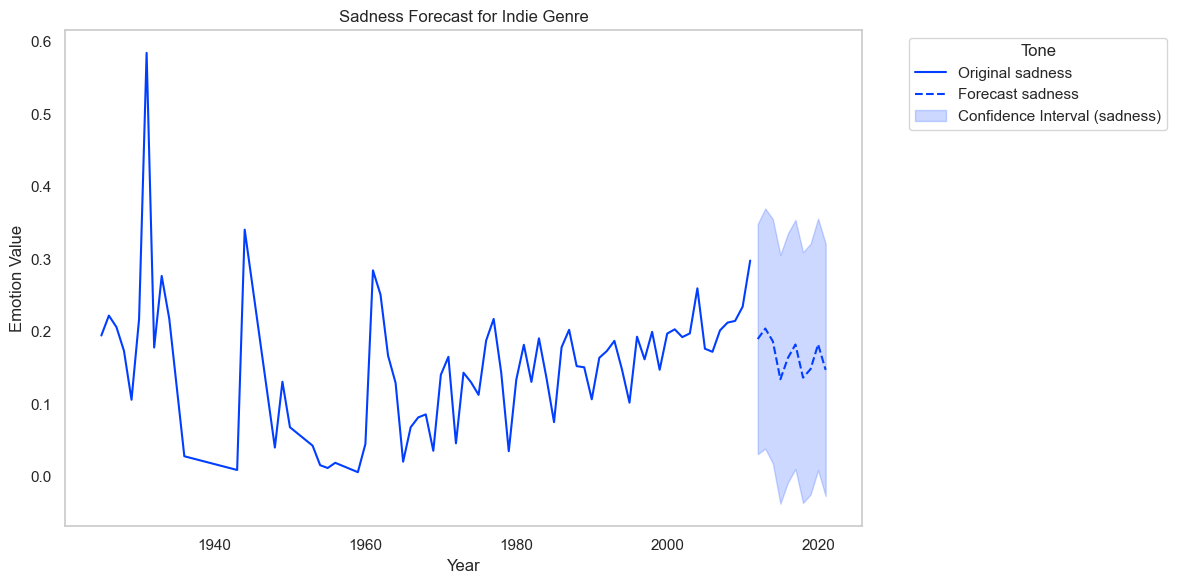

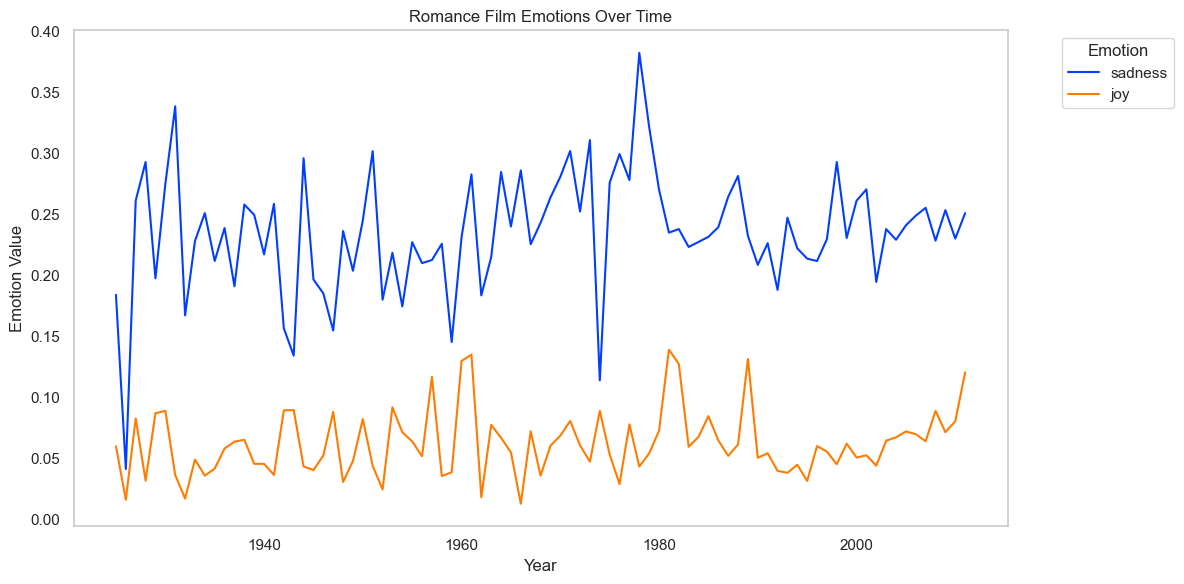

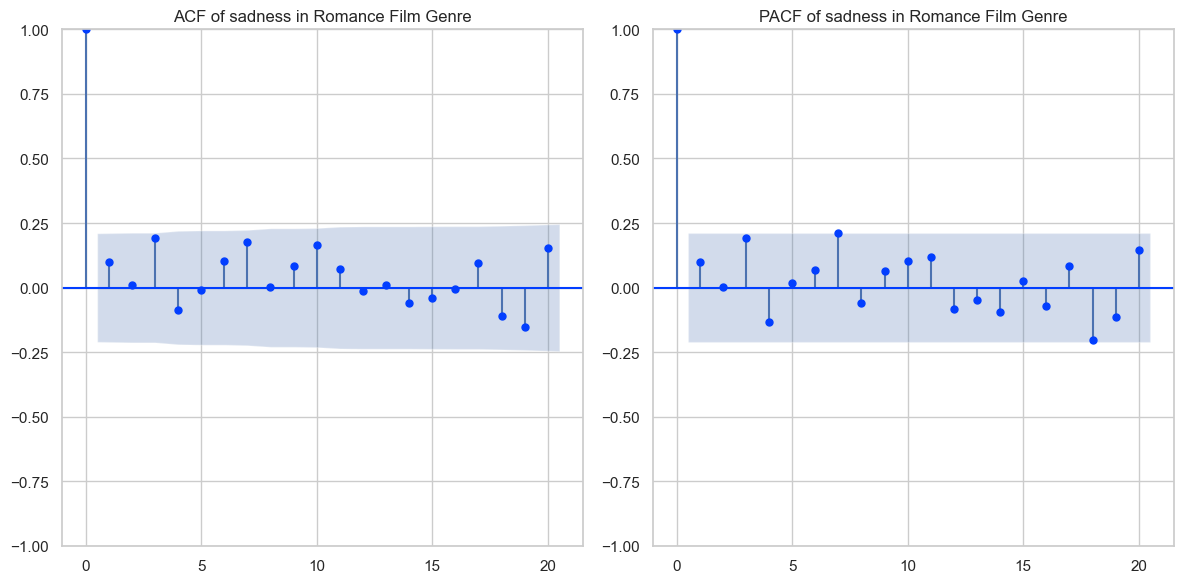

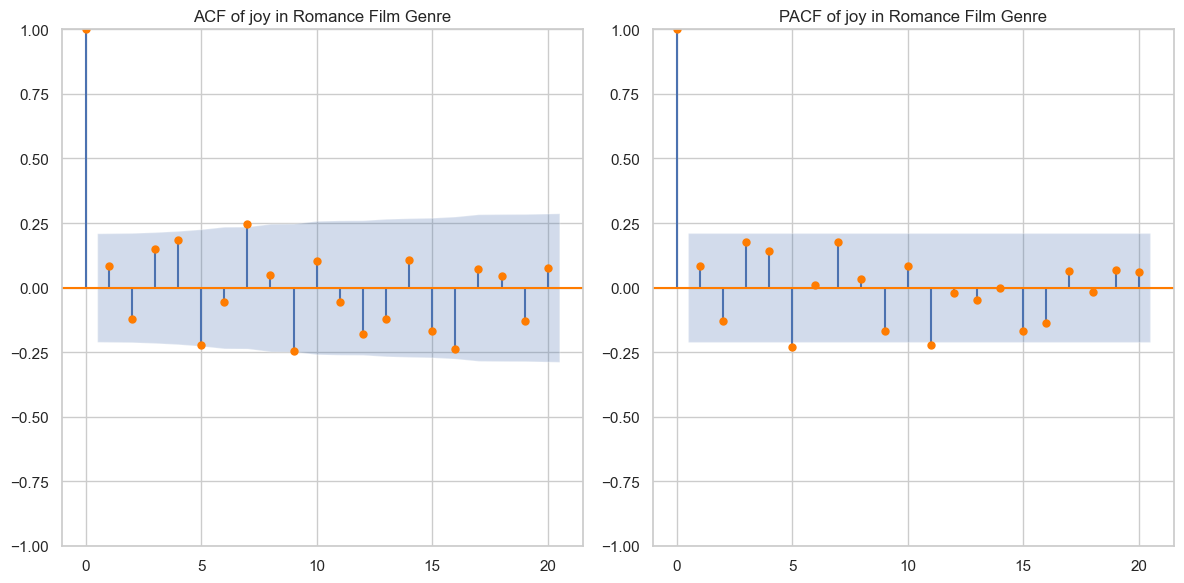

##########################################
 Performing Box-Jenkins Procedure for sadness in Romance Film Genre
ADF Statistic: -8.329339184936089
p-value: 3.401902104800144e-13
Best ARIMA Order for sadness in Romance Film Genre: (1, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for joy in Romance Film Genre
ADF Statistic: -2.8643682243500876
p-value: 0.04965115747924097
Best ARIMA Order for joy in Romance Film Genre: (2, 0, 2)


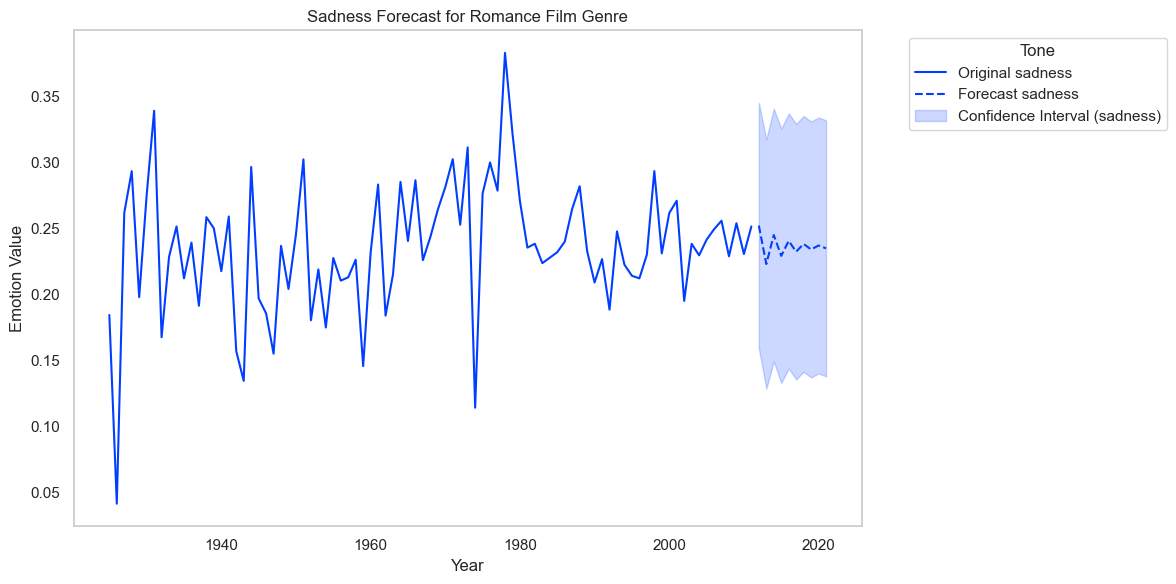

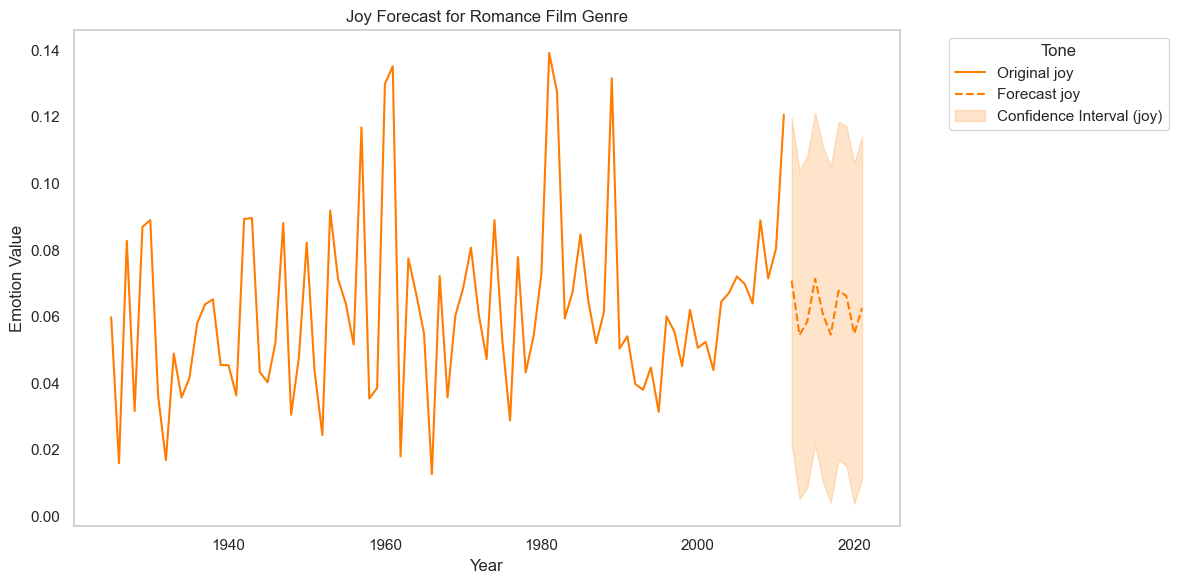

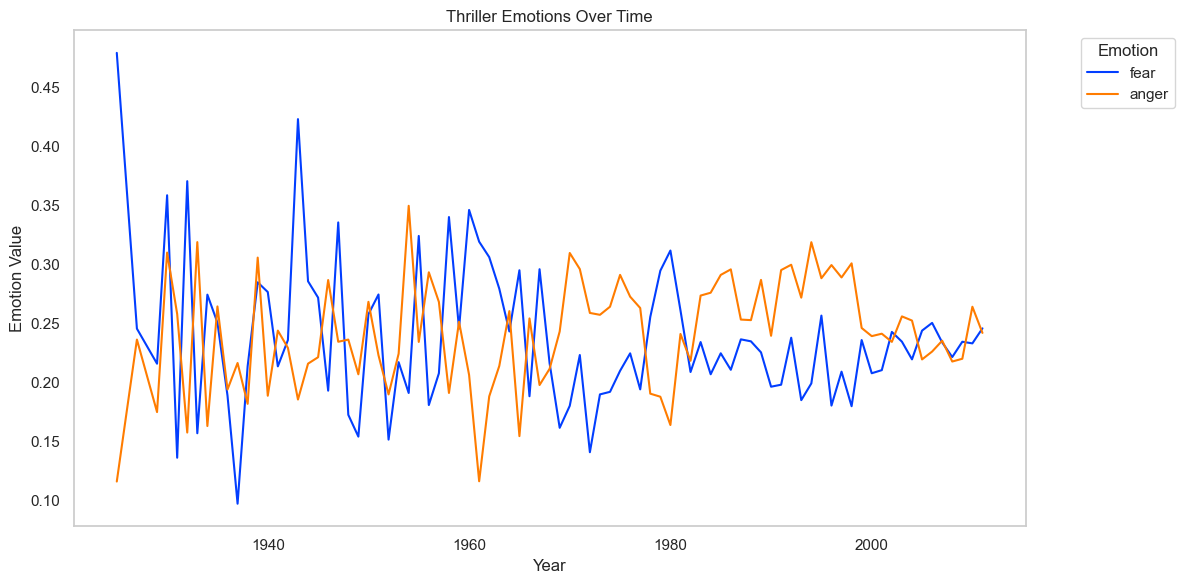

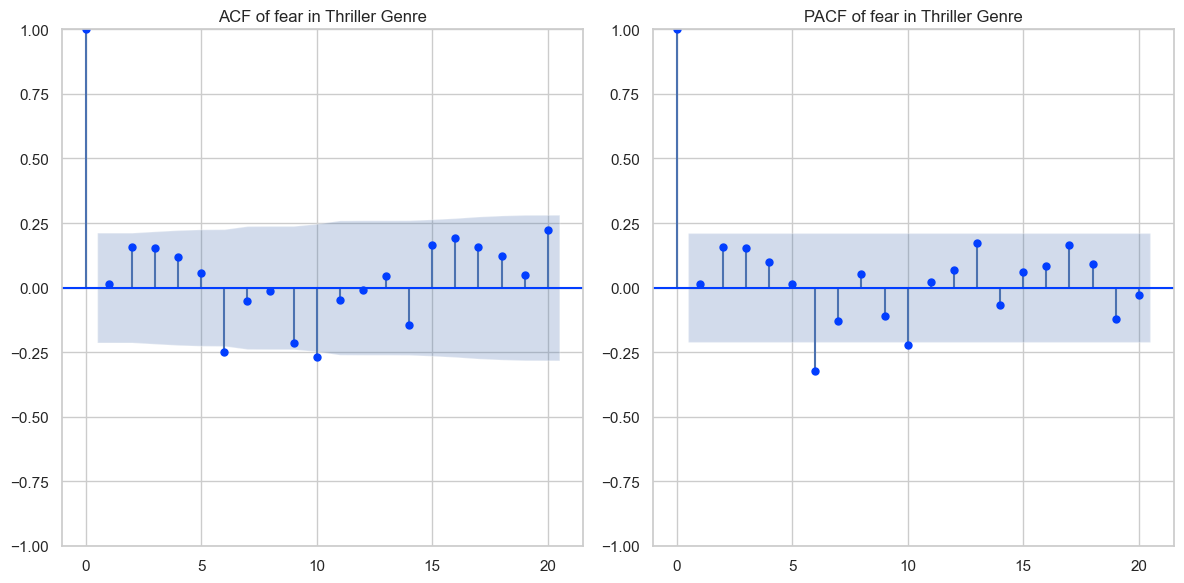

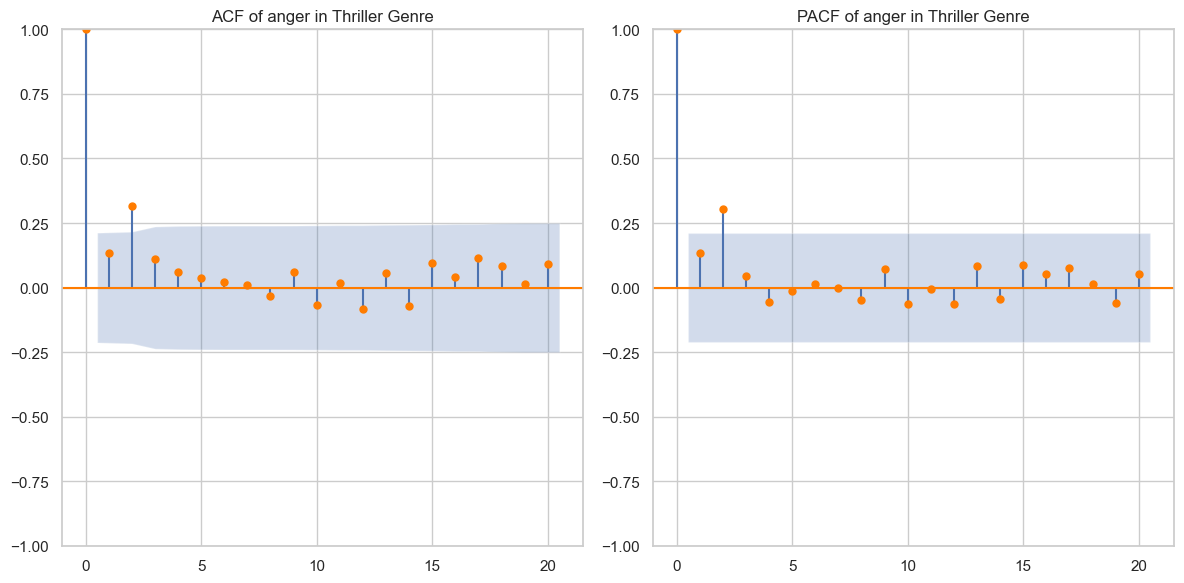

##########################################
 Performing Box-Jenkins Procedure for fear in Thriller Genre
ADF Statistic: -4.380649133353819
p-value: 0.0003211346606093756
Best ARIMA Order for fear in Thriller Genre: (3, 0, 2)
##########################################
 Performing Box-Jenkins Procedure for anger in Thriller Genre
ADF Statistic: -4.398199262173896
p-value: 0.00029901836591139636
Best ARIMA Order for anger in Thriller Genre: (2, 0, 0)


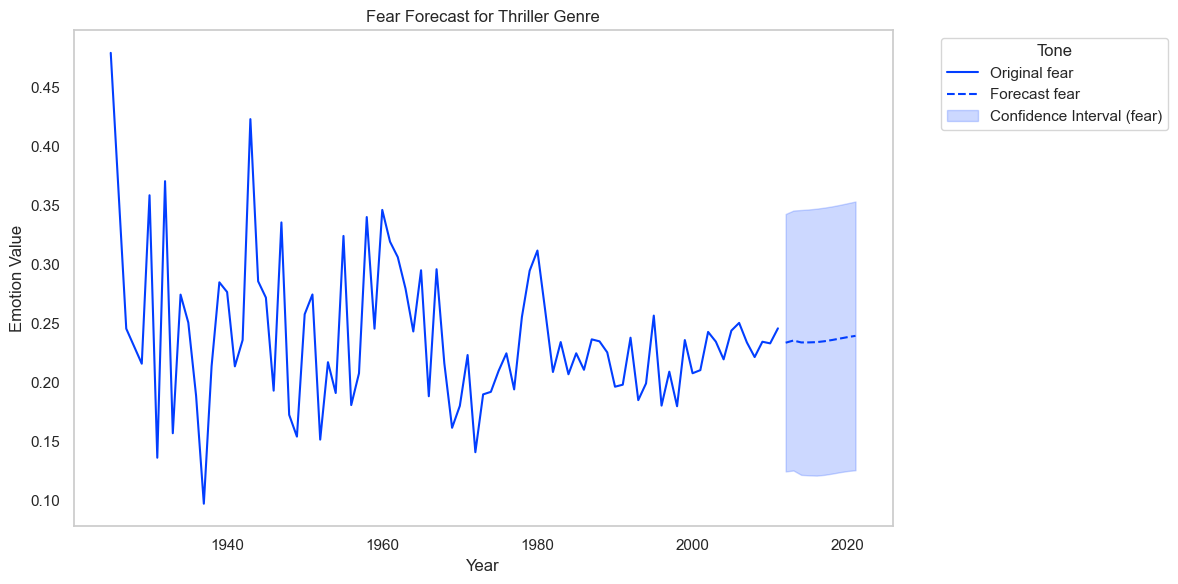

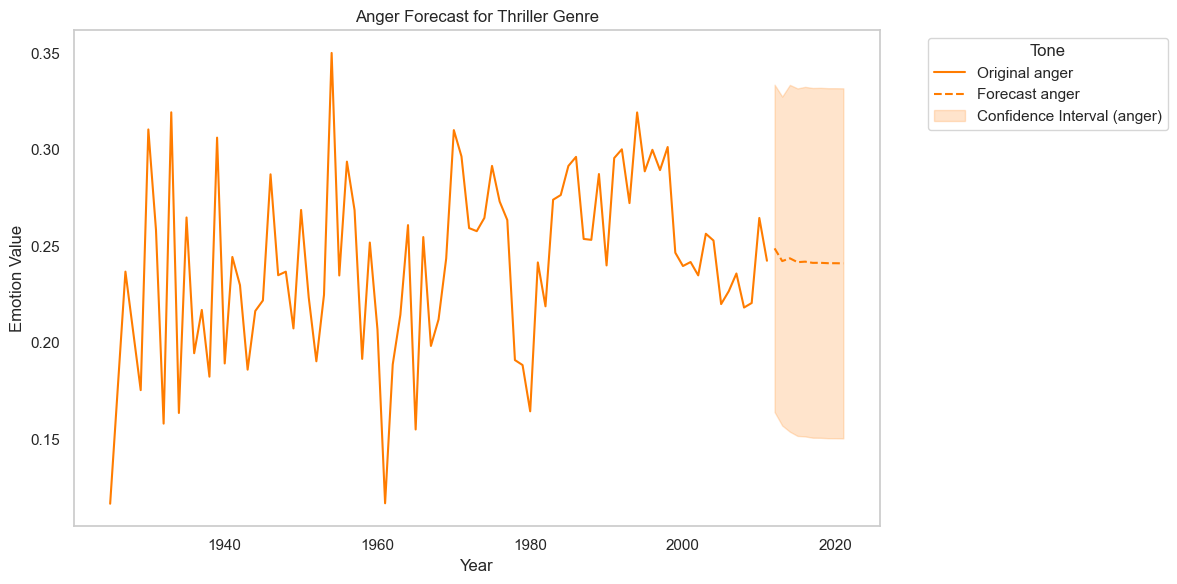

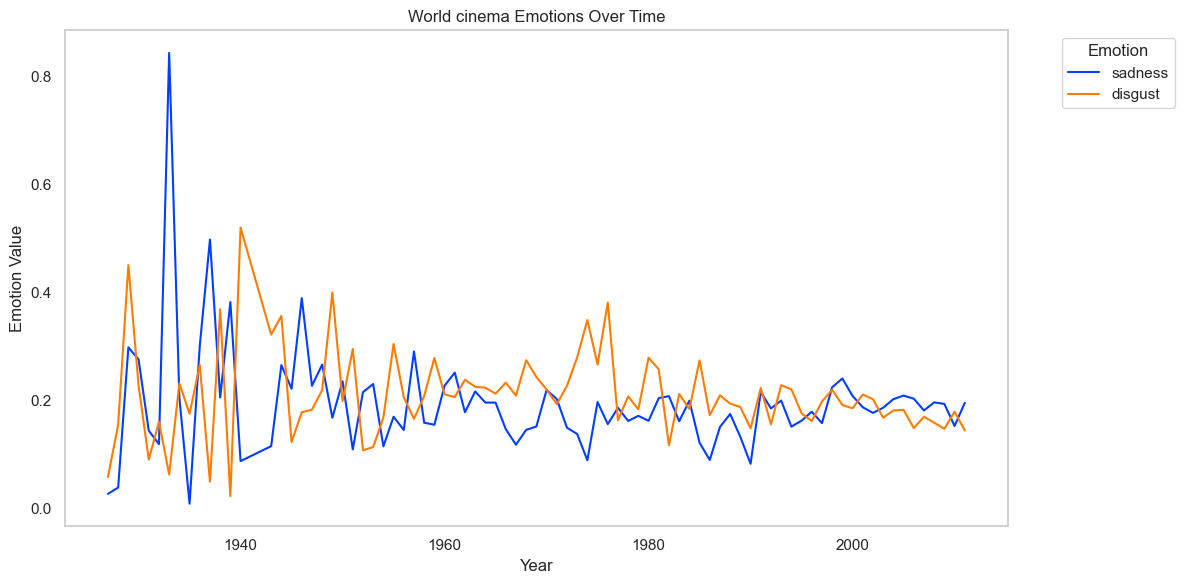

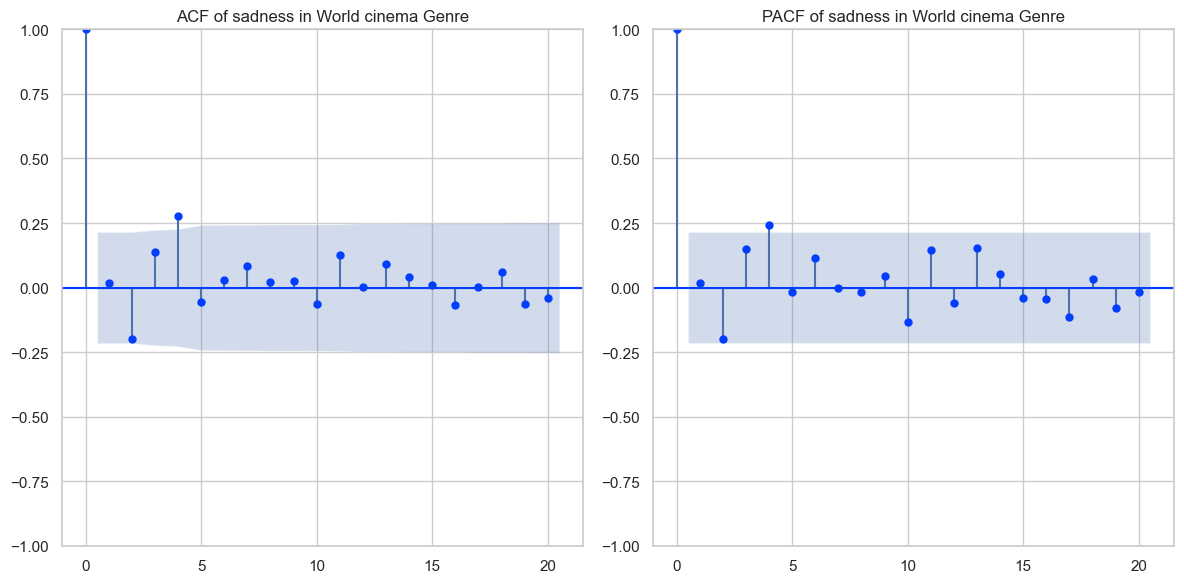

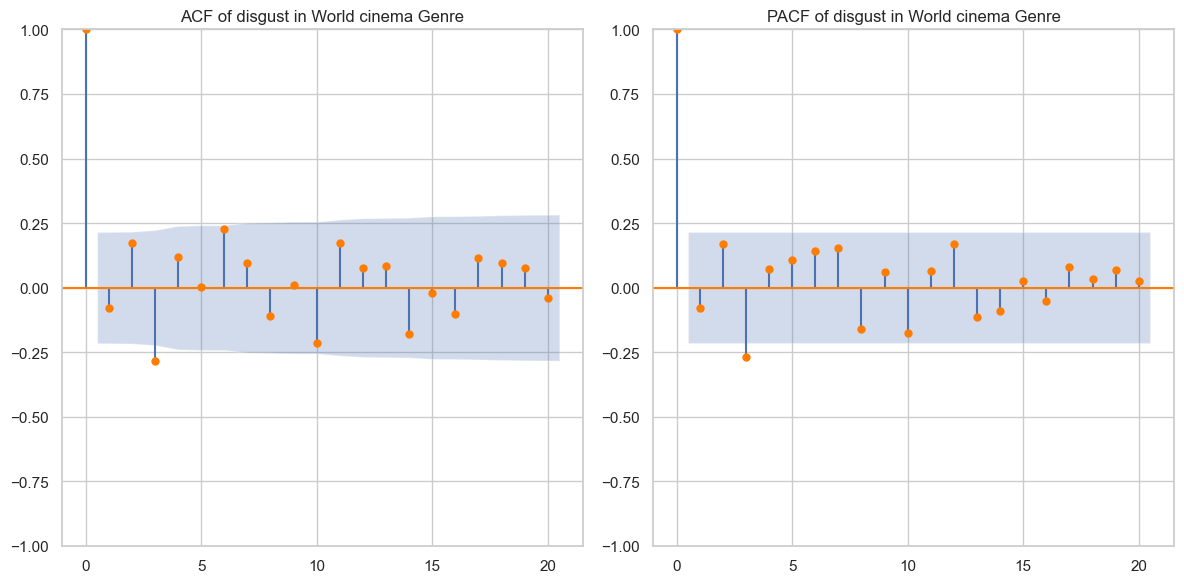

##########################################
 Performing Box-Jenkins Procedure for sadness in World cinema Genre
ADF Statistic: -3.6754907309791043
p-value: 0.004471408710045539
Best ARIMA Order for sadness in World cinema Genre: (3, 0, 1)
##########################################
 Performing Box-Jenkins Procedure for disgust in World cinema Genre
ADF Statistic: -5.958683939337718
p-value: 2.0637716996936205e-07
Best ARIMA Order for disgust in World cinema Genre: (3, 0, 0)


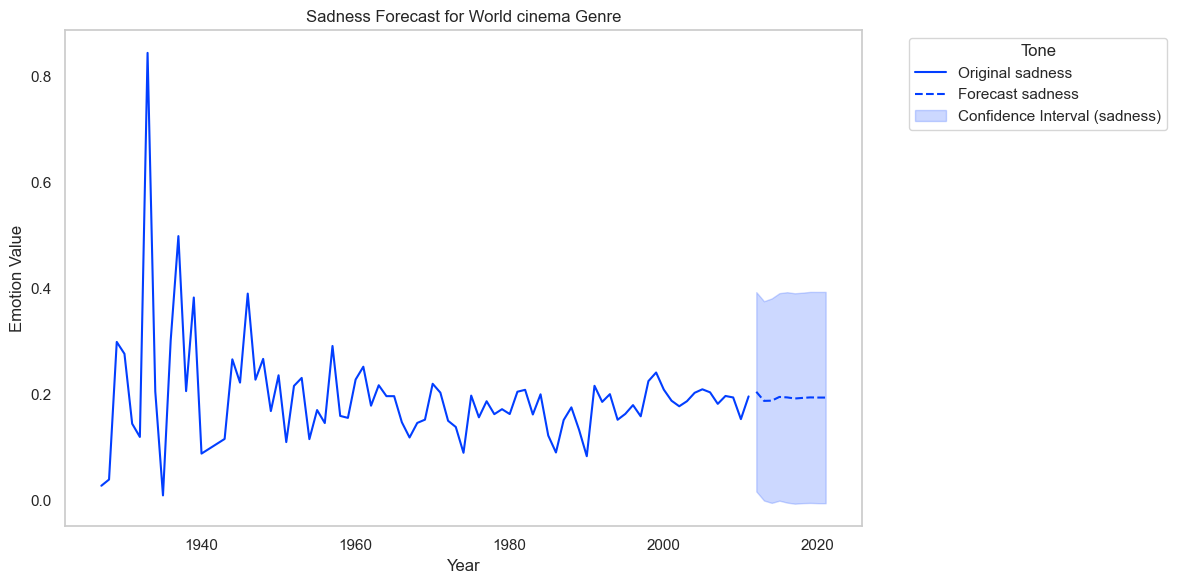

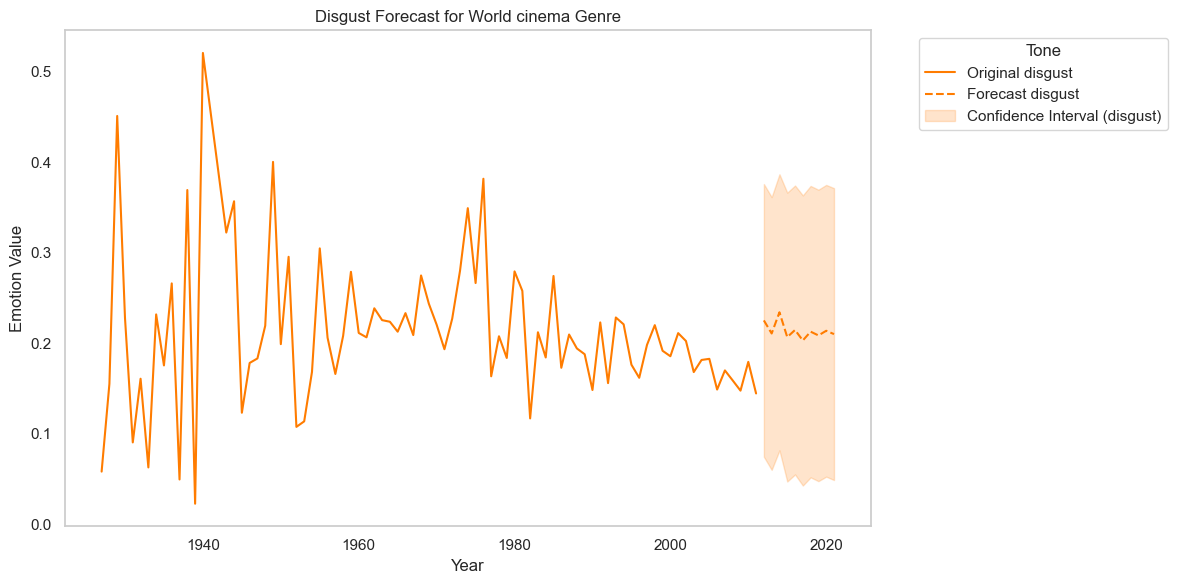

In [24]:
genre_timeseries_analysis(genre_timeseries_df, genres_emotions_mapping)

# //TODO Interpretation and results 

Very interesting! Let's now look if there is a connection between the emotional tone of a movie and the components of the movie like its language or the actor traits of involved actors. First we will look at the question:
## 3. How does the emotional tone of films influence the selection of actor traits, such as age and gender?

We will perform a regression analysis to see how the emotional tone of films influences the average age and gender of involved actors.

In [25]:
# Prepare the data for analysis
# Filter for columns needed for the analysis
character_df = df[['WikiID', 'merge_year', 'Genres', 'distilbert_emotions', 'ActorAge', 'ActorGender', 'ActorBirthDate', 'ActorGenderFlag']].copy()

# Drop rows without emotions, age or gender because they are not helpful here
print("Number of rows before droping: ", len(character_df))
character_df = character_df.dropna(subset=['distilbert_emotions', 'ActorAge', 'ActorGenderFlag'])
print("Number of rows after droping: ", len(character_df))

# Parse relevant attributes from string to correct datatype
character_df['ActorAge'] = character_df['ActorAge'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))
character_df['ActorGender'] = character_df['ActorGender'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))
character_df['ActorGenderFlag'] = character_df['ActorGenderFlag'].apply(lambda x: [] if pd.isna(x) else ast.literal_eval(x))

# Check if transformations worked properly
test_ages = character_df.iloc[0]['ActorAge']
print(test_ages)
test_gender = character_df.iloc[0]['ActorGender']
print(test_gender)
test_gender_flag = character_df.iloc[0]['ActorGenderFlag']
print(test_gender_flag)
print(f"Age entries: {len(test_ages)}, gender entries: {len(test_gender)}, gender flag entries: {len(test_gender_flag)}")

Number of rows before droping:  81771
Number of rows after droping:  30175
[42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, 37.78852253927453, 30.0, 37.78852253927453, 37.78852253927453, 42.0, 57.0, 37.78852253927453, 66.0, 47.0, 58.0]
['F', 'F', 'M', 'M', 'F', 'F', 'F', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'M', 'F']
[1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1]
Age entries: 17, gender entries: 17, gender flag entries: 17


In [26]:
# Create aggregations for gender and age of actors
exploded_df = character_df.explode('ActorAge')
exploded_df = exploded_df.explode('ActorGenderFlag')

aggregated_df = exploded_df.groupby('WikiID').agg({
    "ActorAge": "mean",
    "ActorGenderFlag": "mean"
})

aggregated_df.rename(columns={
    'ActorAge': 'AgeAvg', 
    'ActorGenderFlag': 'GenderAvg'
}, inplace=True)

character_df = character_df.merge(aggregated_df, on='WikiID', how='left')

# Parse emotions from string to dictionary
character_df['distilbert_emotions'] = character_df['distilbert_emotions'].apply(lambda x: {} if pd.isna(x) else ast.literal_eval(x))

# Check the result
test_emotions = character_df.iloc[0]['distilbert_emotions']
print(type(test_emotions))

<class 'dict'>


In [27]:
# Add each emotion as column
emotions = ['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy']
for emotion in emotions:
    character_df[emotion] = character_df['distilbert_emotions'].apply(lambda x: x[emotion])
character_df.head()

WikiID  merge_year                                             Genres  \
0   975900        2001  [Thriller, Science Fiction, Horror, Adventure,...   
1  9363483        1987  [Thriller, Erotic thriller, Psychological thri...   
2   261236        1983                                            [Drama]   
3  6631279        1997  [Romantic comedy, Ensemble Film, Comedy-drama,...   
4   171005        1989  [Costume drama, War film, Epic, Period piece, ...   

                                 distilbert_emotions  \
0  {'disgust': 0.5021221041679382, 'fear': 0.3510...   
1  {'anger': 0.5024036765098572, 'disgust': 0.324...   
2  {'anger': 0.3256497378461063, 'disgust': 0.163...   
3  {'sadness': 0.9155038595199585, 'neutral': 0.0...   
4  {'neutral': 0.6794102787971497, 'surprise': 0....   

                                            ActorAge  \
0  [42.0, 27.0, 32.0, 33.0, 23.0, 52.0, 56.0, 37....   
1                                       [32.0, 26.0]   
2                                 [32.0, 32.0, 35.0]   
3               [25.0, 33.0, 37.0, 35.0, 33.0, 48.0]   
4  [28.0, 51.0, 33.0, 26.0, 30.0, 32.0, 58.0, 53....   

                                         ActorGender  \
0  [F, F, M, M, F, F, F, M, M, M, M, M, M, M, M, ...   
1                                             [M, F]   
2                                          [F, M, M]   
3                                 [M, F, F, M, F, F]   
4  [M, M, M, M, F, M, M, M, M, M, F, M, M, F, M, ...   

                                      ActorBirthDate  \
0  [Timestamp('1958-08-26 00:00:00'), Timestamp('...   
1  [Timestamp('1954-05-08 00:00:00'), Timestamp('...   
2  [Timestamp('1950-06-20 00:00:00'), Timestamp('...   
3  [Timestamp('1971-09-15 00:00:00'), Timestamp('...   
4  [Timestamp('1960-12-10 00:00:00'), Timestamp('...   

                                     ActorGenderFlag     AgeAvg GenderAvg  \
0  [1, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0, 0, ...  42.126711  0.352941   
1                                             [0, 1]       29.0       0.5   
2                                          [1, 0, 0]       33.0  0.333333   
3                                 [0, 1, 1, 0, 1, 1]  35.166667  0.666667   
4  [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, ...  45.513739  0.190476   

    disgust      fear     anger   neutral   sadness  surprise       joy  
0  0.502122  0.351022  0.065147  0.057085  0.018771  0.004086  0.001766  
1  0.324022  0.032032  0.502404  0.096385  0.037811  0.005438  0.001907  
2  0.163747  0.002405  0.325650  0.440068  0.025255  0.005851  0.037024  
3  0.021709  0.010488  0.006082  0.042634  0.915504  0.002163  0.001421  
4  0.004746  0.003841  0.016094  0.679410  0.057925  0.129912  0.108072

The emotions sum up to one, so there is multicoloniartiy between the variables. Therefore to create a meaningful analysis we have to drop a class. Let's first do a quick correlation analysis to see if there is one emotion which is strongly correlated to others, so we can drop it.

In [28]:
# Filter
emotion_corr_df = character_df[emotions]

# Do correlation analysis
emotion_corr_df.corr()

disgust      fear     anger   neutral   sadness  surprise       joy
disgust   1.000000 -0.224354 -0.055964 -0.211494 -0.242464 -0.185363 -0.176413
fear     -0.224354  1.000000 -0.206568 -0.268345 -0.234403 -0.056546 -0.162655
anger    -0.055964 -0.206568  1.000000 -0.291715 -0.273985 -0.157576 -0.204393
neutral  -0.211494 -0.268345 -0.291715  1.000000 -0.210060 -0.032004  0.100285
sadness  -0.242464 -0.234403 -0.273985 -0.210060  1.000000 -0.092891 -0.075215
surprise -0.185363 -0.056546 -0.157576 -0.032004 -0.092891  1.000000 -0.011244
joy      -0.176413 -0.162655 -0.204393  0.100285 -0.075215 -0.011244  1.000000

There doesn't seem to be a clear candidate, so we will drop the semantically least interesting emotion: neutral.

In [29]:
character_df = character_df.drop(labels=['neutral'], axis=1)

We will now regress AvgAge and AvgGender using all the emotions leaving out the 'neutral' tone for multicollinearity purpose.

The effect of the neutral emotion is therefore represented by the intercept.
The coeffients of the remaining tones will represent the effect of a 1-unit increase in the proportion of that tone relative to the excluded category (neutral) on the dependet variable, while holding the total sum of probabilities fixed at 1.

In [30]:
# Model for average age
age_mod = smf.ols(formula='AgeAvg ~ disgust + fear + anger + sadness + surprise + joy', data=character_df)
age_res = age_mod.fit()
print(age_res.summary())

ValueError: endog has evaluated to an array with multiple columns that has shape (30175, 13731). This occurs when the variable converted to endog is non-numeric (e.g., bool or str).

We see that that the all the tones except 'fear' seems significant although the R^2 metric is very low (0.03). That shows that the model does not explain well the variance of the dependent variable, which means that knowing only the emotional score of the film is not enough information to predict efficiently the average actor age. To do that we probably need more predictors like Genres, Languages, Movie Character traits etc. 

Nonetheless, the coefficients tell us some insight on how the tone influence the Avg Age: All of them are negative and significant, meaning that an increase in proportion of those tones relative to the neutral emotion, on average decrease the Avg Age of the film cast. So we can see that for films with stronger emotions, on average younger actors are chosen. We also see differences between the different emotions. Even though all coefficients are negative, the ones for joy anger and disgust are noticeably higher than the ones of the other emotions.

In [ ]:
# Model for average gender
gender_mod = smf.ols(formula='GenderAvg ~ disgust + fear + anger + sadness + surprise + joy', data=character_df)
gender_res = gender_mod.fit()
print(gender_res.summary())

Every coefficient is significant, The R^2 metric is very low (0.018) bringing the same result as before: we need more significan predictors to explain and model the proportion of female/male in a cast. 

Nonetheless,  the coefficients tell us some insight on how the tone influence the Avg Gender: Anger is negative, so an increase in proportion of the anger tone relative to the neutral tone decreases the proportion of female actors in a cast.
All the other coefficients are positive, meaning the their increase in proportion compare to 'neutral' increase the proportion of female in the cast.

Interesting! So even though we can't explain the average age and gender of actors purely based on emotions, what is expected, we still see how emotions influence these actor traits. Now we want to switch our focus away from the actors involved in the movie and look at the film languages. We are interested in the connection between present emotions in a movie and the languages a movie is available in. Therefore we try to answer the question:
## 4 .Does the emotional tone of films differ between movies in different languages?

In [31]:
df_languages = df.copy()
df_languages["Languages"] = df_languages["Languages"].apply(lambda x: ast.literal_eval(x))
df_languages["nrclex_emotions"] = df_languages["nrclex_emotions"].apply(lambda x: conv_to_dict(x))
df_languages["roberta_emotions"] = df_languages["roberta_emotions"].apply(lambda x: conv_to_dict(x))
df_languages["distilbert_emotions"] = df_languages["distilbert_emotions"].apply(lambda x: conv_to_dict(x))

In [32]:
# We were getting some errors printing languages and seems there are some invalid unicode characters
def is_invalid_unicode(text: str):
    """Check if text contains invalid unicode characters"""
    try:
        text.encode('utf-8').decode('utf-8')
        return False
    except UnicodeError:
        return True
    
def clean_lang_list(languages: list[str]):
    """Remove invalid languages from a list of languages"""
    return [l for l in languages if not is_invalid_unicode(l)]

df_languages["Languages"] = df_languages["Languages"].apply(clean_lang_list)

In [33]:
no_lang_count = len(df_languages[df_languages["Languages"].apply(lambda x: len(x) == 0)])
print(f"Number of movies with no language: {no_lang_count}")

# Percentage of movies with no language
print(f"Percentage of movies with no language: {no_lang_count / len(df_languages) * 100:.2f}%")

Number of movies with no language: 13868
Percentage of movies with no language: 16.96%


In [34]:
# Drop all movies that don't have a labelled language
df_languages[df_languages["Languages"].apply(lambda x: len(x) < 0)]

# Look at the distribution of languages over all movies
language_count = df_languages['Languages'].explode().value_counts()
print(language_count)

Languages
English Language                        40914
Hindi Language                           3745
Spanish Language                         3675
French Language                          3422
Silent film                              3183
                                        ...  
Australian Aboriginal Pidgin English        1
Krio Language                               1
Tok Pisin Language                          1
Pawnee Language                             1
Kriolu                                      1
Name: count, Length: 206, dtype: int64


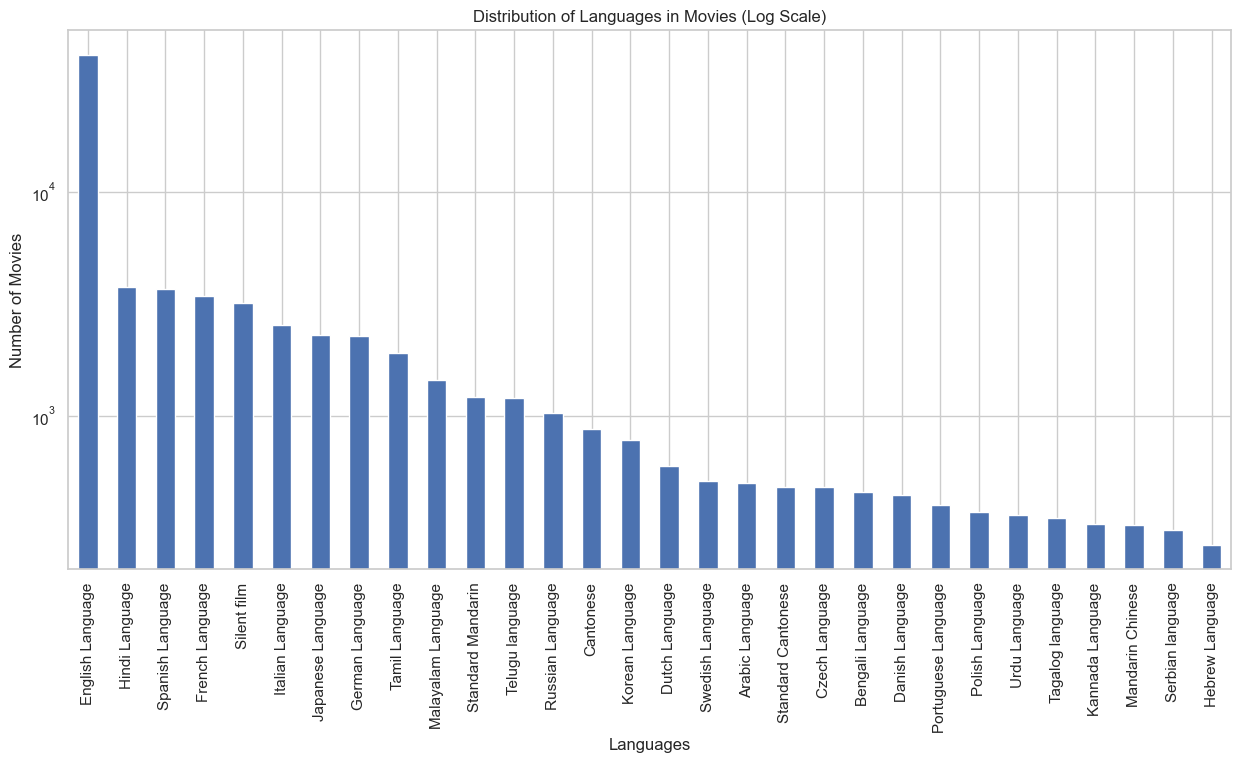

In [35]:
language_count[:30].plot(kind='bar', figsize=(15, 7), logy=True)
plt.title('Distribution of Languages in Movies (Log Scale)')
plt.xlabel('Languages')
plt.ylabel('Number of Movies')
plt.show()

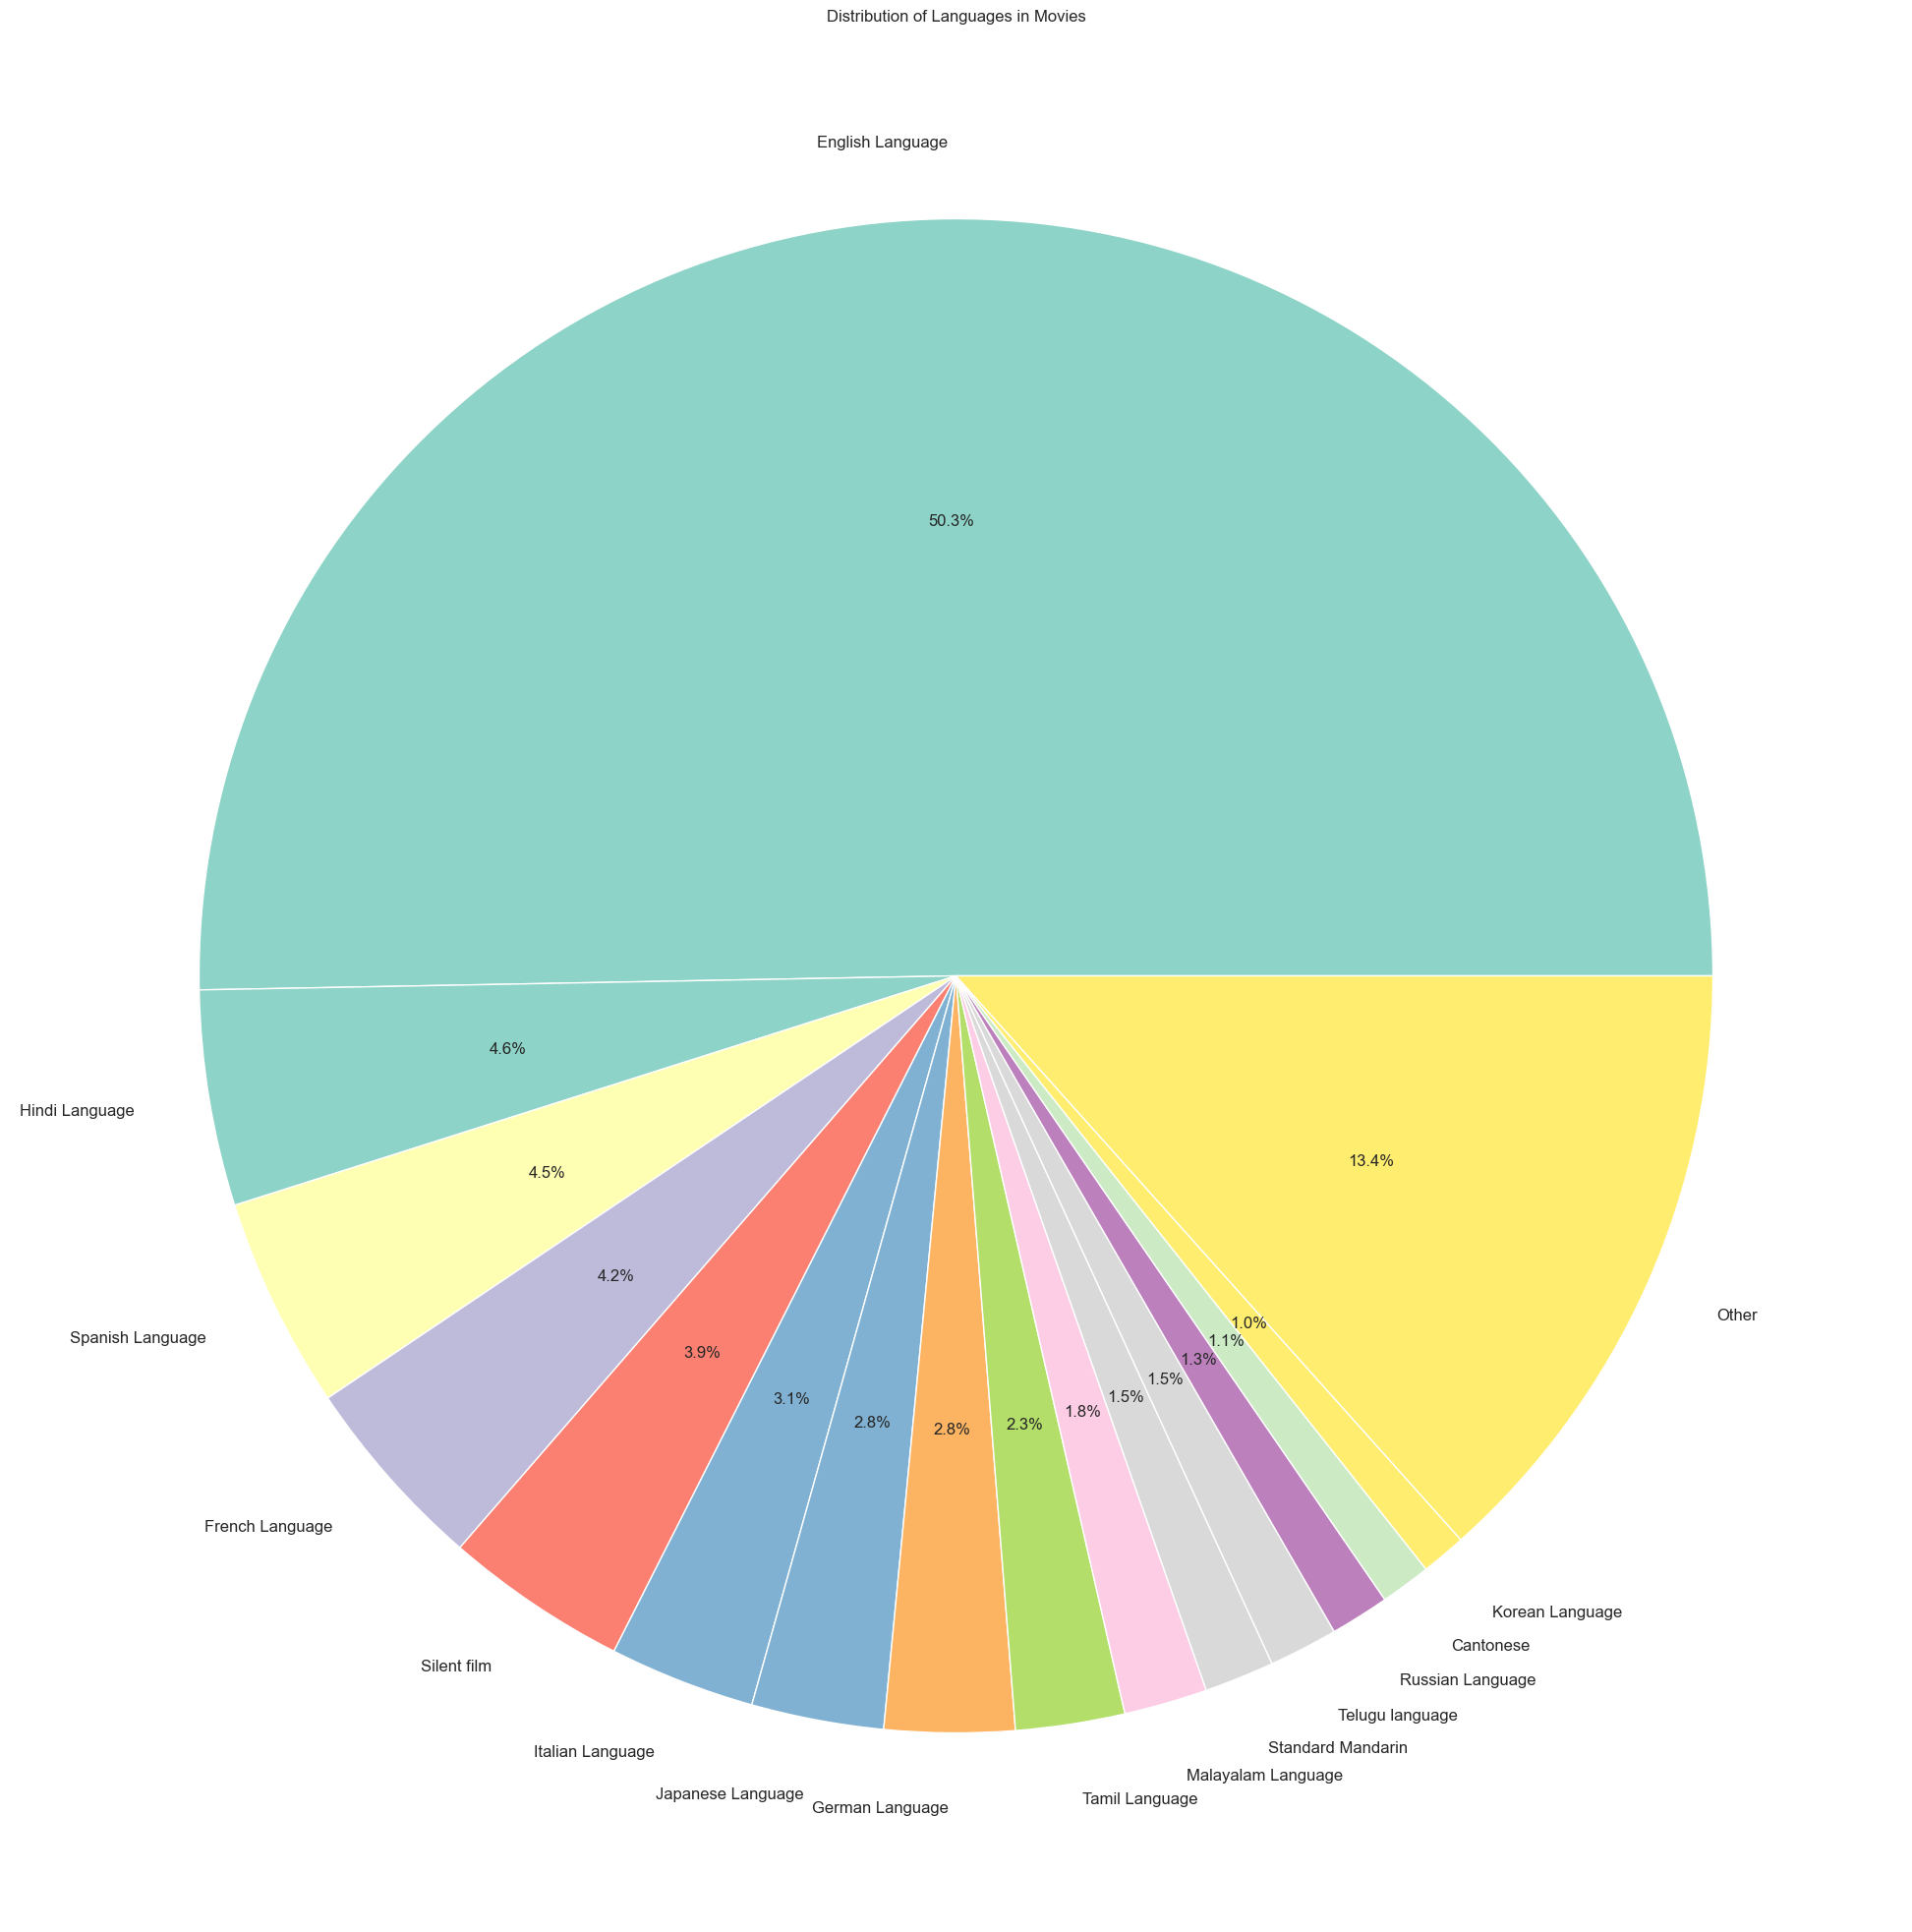

In [36]:
# Create a pie chart of the top 15 languages plus "Other"
plt.figure(figsize=(25, 25))

# Get top 15 languages and sum the rest into "Other"
top_15 = language_count[:15]
other = pd.Series({'Other': language_count[15:].sum()})
plot_data = pd.concat([top_15, other])

colors = plt.cm.Set3(np.linspace(0, 1, len(plot_data)))

plt.pie(plot_data, labels=plot_data.index, autopct='%1.1f%%', colors=colors, textprops={'fontsize': 12})
plt.title('Distribution of Languages in Movies')
plt.show()

As an explicit choice, we will keep silent films going forward because there may be some emotional profile differences for films with NO dialogue


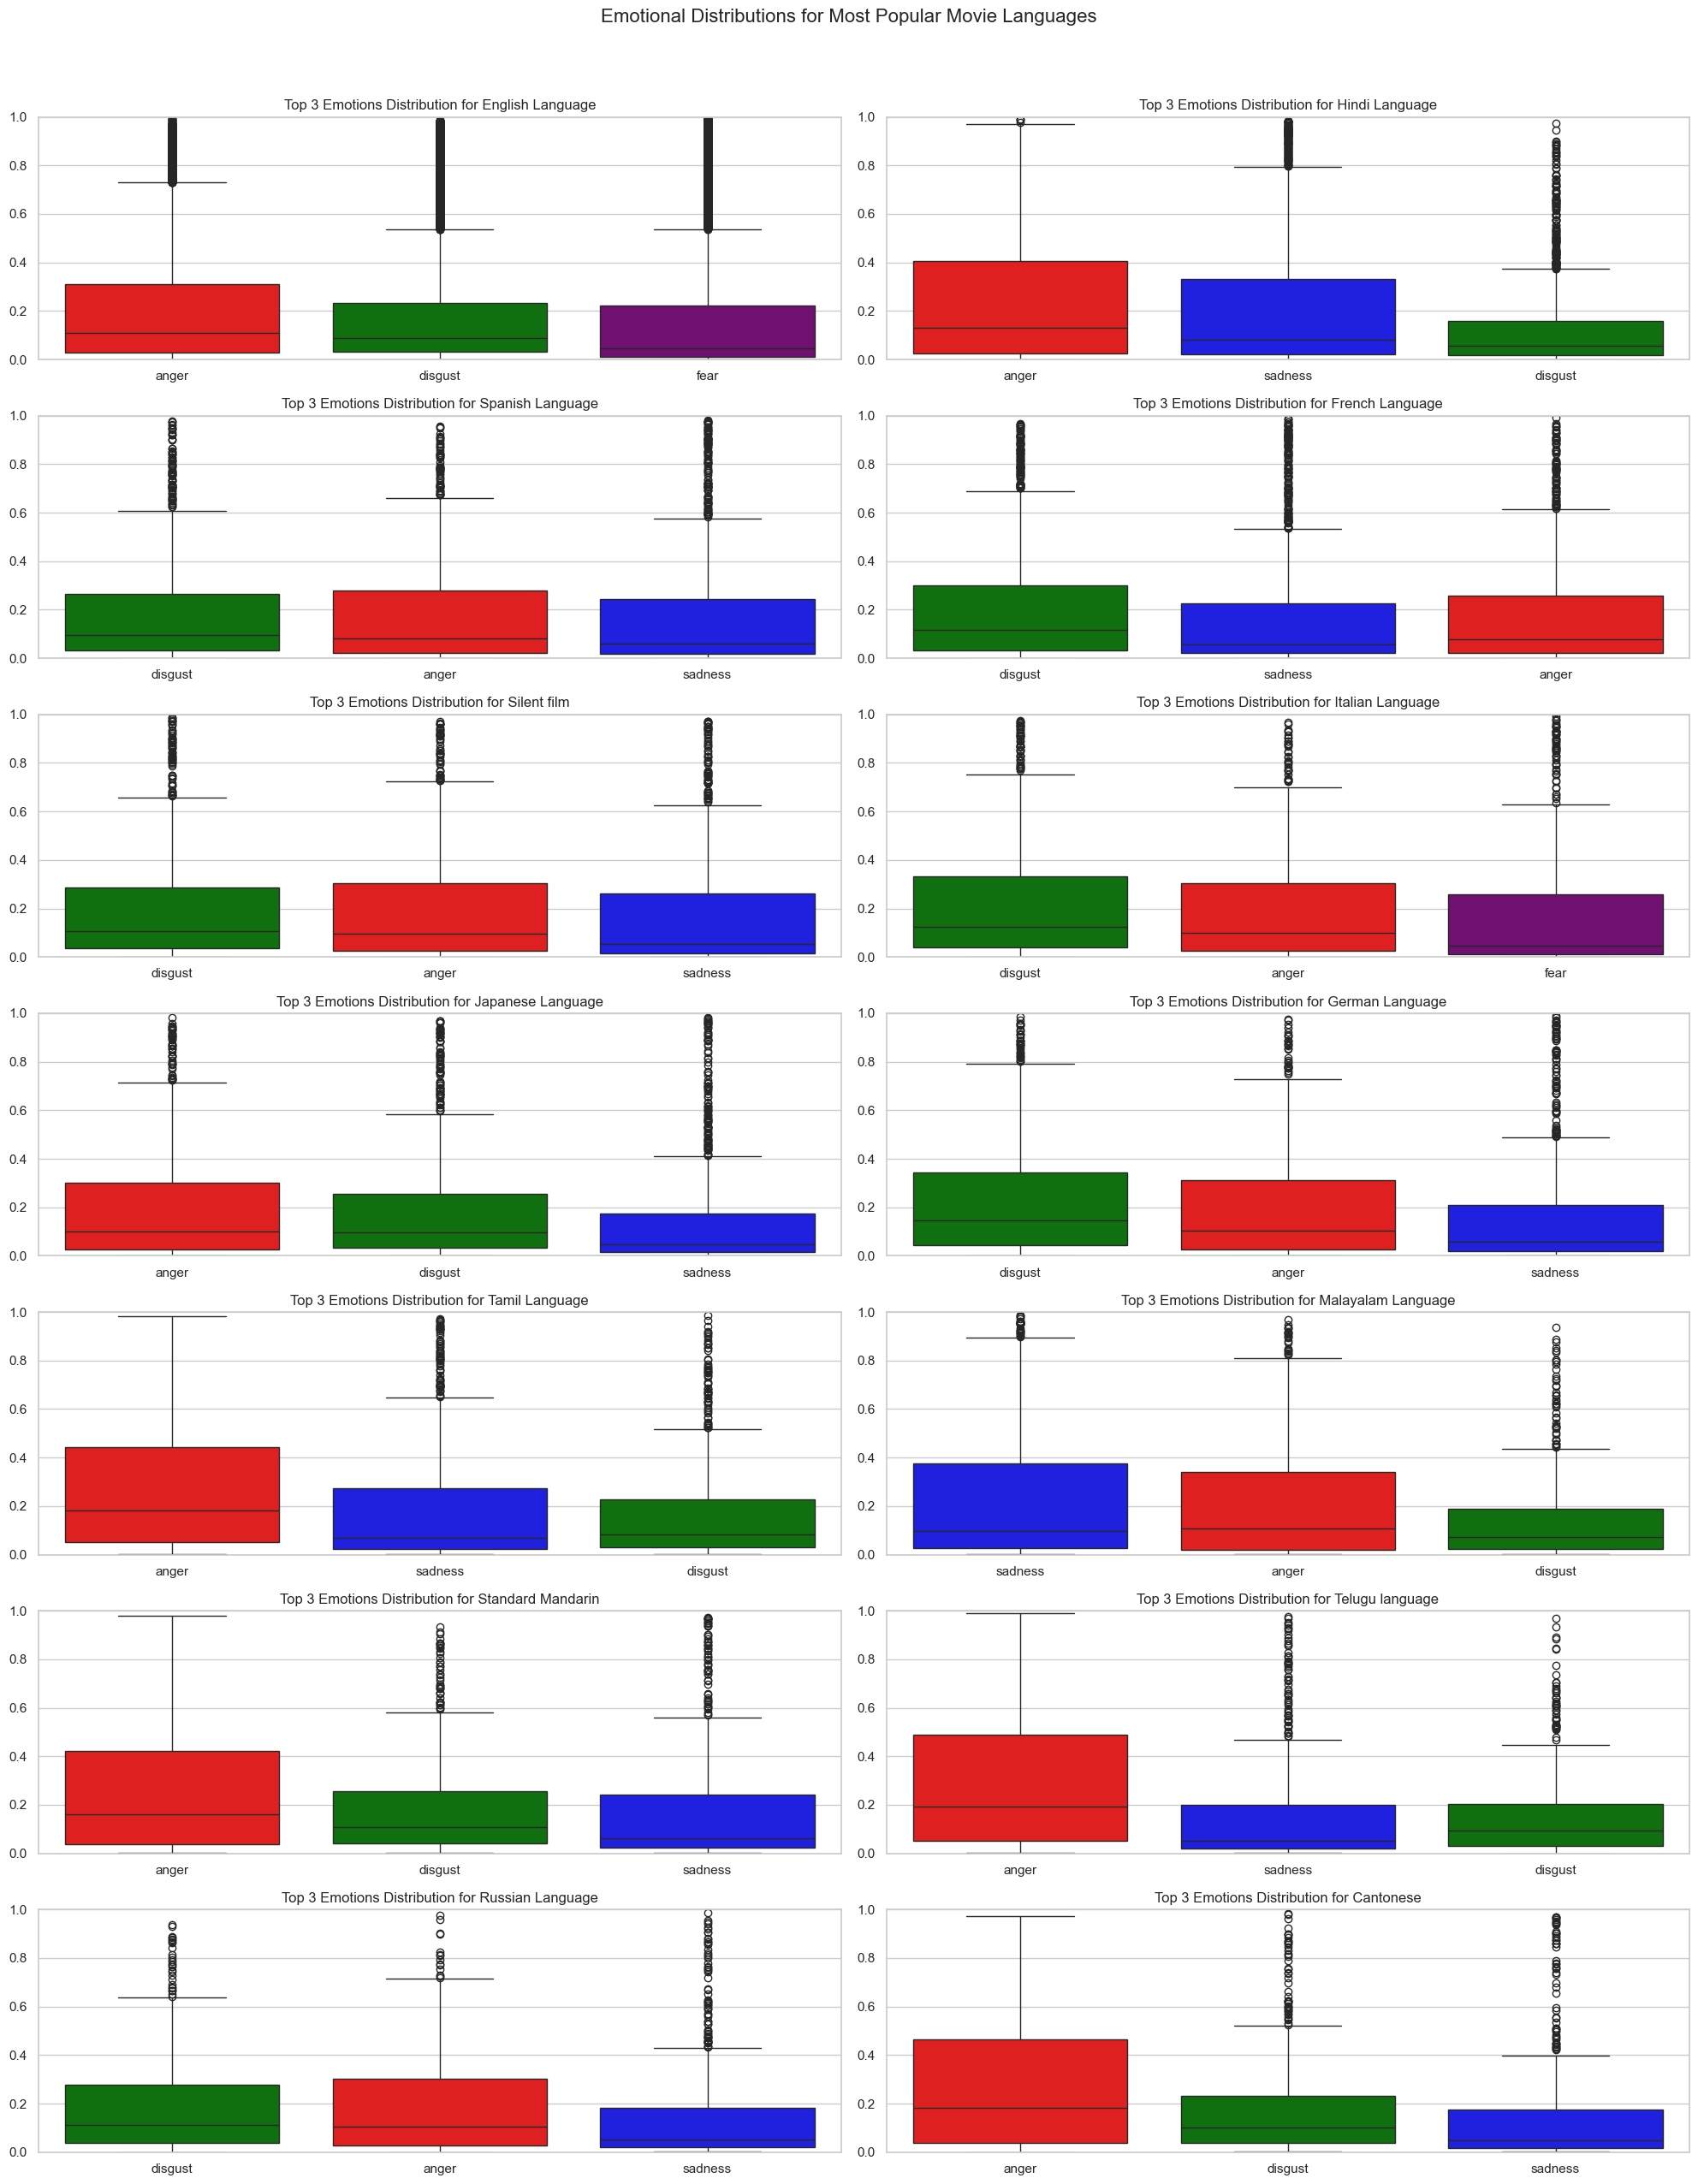

In [37]:
# Define a color palette for the emotions
emotion_palette = {
  'anger': 'red',
  'disgust': 'green',
  'sadness': 'blue',
  'fear': 'purple',
  'joy': 'yellow',
  'surprise': 'orange'
}

# We analyze the emotions of the top 14 languages
top_languages = language_count[:14].index

# For each language, get all the movies that belong to it and plot emotion distributions
fig, axes = plt.subplots(nrows=7, ncols=2, figsize=(20, 25))
axes = axes.flatten()

for i, lang in enumerate(top_languages):
  movies_in_lang = df_languages[df_languages['Languages'].apply(lambda x: lang in x)]
  distilbert_emotions = movies_in_lang['distilbert_emotions'].dropna()
  
  # Convert list of dicts to DataFrame for easier plotting
  distilbert_emotions_df = pd.DataFrame(list(distilbert_emotions))

  # Remove neutral emotion
  distilbert_emotions_df = distilbert_emotions_df.drop('neutral', axis=1)

  # Get top 3 emotions by mean value
  top_3_emotions_distilbert = distilbert_emotions_df.mean().nlargest(3).index
  
  # Plot boxplot for this language with only top 3 emotions
  sns.boxplot(data=distilbert_emotions_df[top_3_emotions_distilbert], ax=axes[i], palette=emotion_palette)
  axes[i].set_title(f'Top 3 Emotions Distribution for {lang}')
  axes[i].set_ylim(0, 1)

plt.suptitle('Emotional Distributions for Most Popular Movie Languages', fontsize=16, y=1.02)
plt.tight_layout()
plt.show()

In [38]:
EMOTIONS = ['anger', 'disgust', 'fear', 'joy', 'neutral', 'sadness', 'surprise']

def convert_to_percentage(emotions: dict) -> dict:
    """
    Convert emotional decimal values to percentages.
    """
    return {k: v * 100 for k, v in emotions.items()}

def prepare_data_for_analysis(df_to_prepare: pd.DataFrame) -> pd.DataFrame:
    """
    Prepare the data for statistical analysis by:
    1. Expanding the language lists into separate rows
    2. Creating emotion columns from the dictionary
    3. Filtering for languages with sufficient data
    """

    df_new = df_to_prepare.copy()

    # Get rid of rows without emotion data
    df_new = df_new[df_new['distilbert_emotions'].apply(lambda x: isinstance(x, dict) and x != {})]

    # Multiply all the emotions by 100 so we can work with percentages
    df_new['distilbert_emotions'] = df_new['distilbert_emotions'].apply(convert_to_percentage)

     # Explode the Languages column to create separate rows for each language
    df_new = df_new.explode('Languages').reset_index(drop=True)

    # Create separate columns for each emotion
    for emotion in EMOTIONS:
        df_new[emotion] = df_new['distilbert_emotions'].apply(lambda x: x.get(emotion, np.nan))

    # Filter for languages with at least 100 movies
    language_counts = df_new['Languages'].value_counts()
    valid_languages = language_counts[language_counts >= 100].index
    df_filtered = df_new[df_new['Languages'].isin(valid_languages)]
    
    return df_filtered

REGRESSION_MODEL = "C(Languages, Treatment(reference='English Language'))"

def run_individual_regressions(df_reg: pd.DataFrame):
    """
    Perform separate regression analyses for each emotion.
    """
    
    results = {}
    for emotion in EMOTIONS:
        model = sm.OLS.from_formula(f"{emotion} ~ {REGRESSION_MODEL}", data=df_reg).fit()
        results[emotion] = {
            'r_squared': model.rsquared,
            'significant_effects': model.pvalues[model.pvalues < 0.05],
            'significant_params': model.params[model.pvalues < 0.05],
            'model': model
        }

    return results

# Prepare the data
df_analysis = prepare_data_for_analysis(df_languages)

# Run all analyses
regression_results = run_individual_regressions(df_analysis)

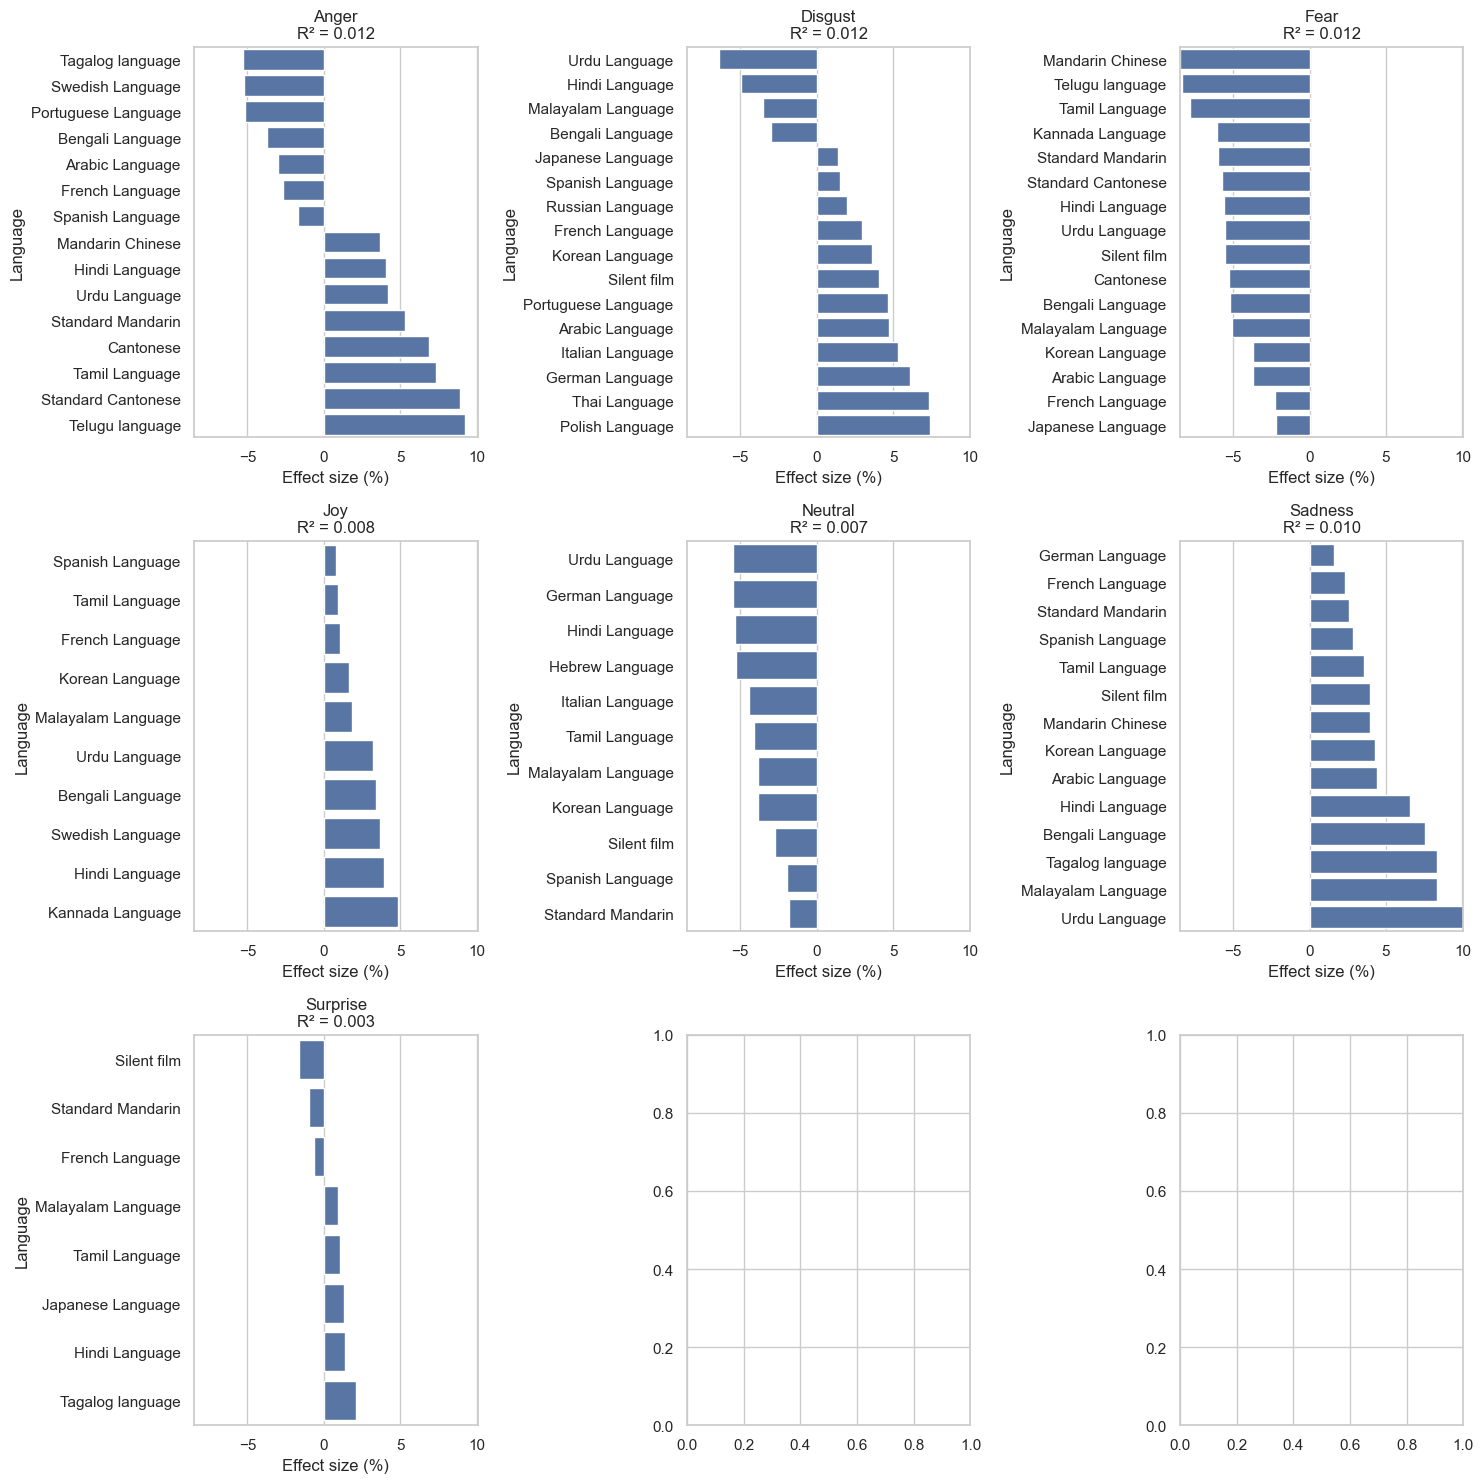

In [39]:
# Plot significant parameters for each emotion
fig, axes = plt.subplots(nrows=3, ncols=3, figsize=(15, 15))
axes = axes.flatten()

# Find global min and max for consistent scale
all_params = []
for emotion in EMOTIONS:
    significant_params = regression_results[emotion]['significant_params']
    params_no_intercept = significant_params[1:]
    all_params.extend(params_no_intercept.values)
global_min, global_max = min(all_params), max(all_params)

for i, emotion in enumerate(EMOTIONS):
    if i < len(axes):
        significant_params = regression_results[emotion]['significant_params']
        
        # Don't include intercept
        params_no_intercept = significant_params[1:]  
        params_sorted = params_no_intercept.sort_values(ascending=True)

        y_labels = params_sorted.index.astype(str).str.extract(r'\[T\.(.*?)\]')[0]

        # Create bar plot
        sns.barplot(x=params_sorted.values, 
                   y=y_labels, 
                   ax=axes[i])
        
        axes[i].set_title(f'{emotion.capitalize()}\nR² = {regression_results[emotion]["r_squared"]:.3f}')
        axes[i].set_xlabel('Effect size (%)')
        axes[i].set_ylabel('Language')
        axes[i].set_xlim(global_min, global_max)  # consistent scale

plt.tight_layout()

#### Analysis of Regression Results
English was used as the reference category since it is both the normative and largest category.

##### Overall effect size of language on emotional content is extremely low:
- The R² values are quite low (0.003-0.012) indicating language explains only a very small portion of the variance in emotional content
- This of course makes sense because the emotional content of a movie is MUCH more influenced factors such as the plot, the acting, the cinematography, etc.

##### Some observed effects
In the fear emotion, all significant languages have a negative effect on fear compared to English.

Likewise, in the joy and sadness emotions, all significant languages have a positive effect compared to English.

##### Correlated emotions
OLS assumes that emotions from the same movie are treated as independent observations. However, this is probably not true because a more positive-film is more likely to have more positive emotions.

In [ ]:
# Run MANOVA for a multivariate analysis of the emotions
manova_data = prepare_data_for_analysis(df_languages)
manova = MANOVA.from_formula('anger + disgust + fear + joy + sadness + surprise ~ Languages', data=manova_data)
print("\nMANOVA Results:")
print(manova.mv_test())
manova_results = manova.mv_test()

manova_results.summary()

#### MANOVA Results

All four test statistics (Wilks' lambda, Pillai's trace, Hotelling-Lawley trace, and Roy's greatest root) show highly significant results (Pr > F = 0.0000). This strongly indicates that there are significant differences in emotional expression patterns across different languages in movies.

However, as we might expect from our earlier analysis on the ANOVA for each emotion, the effect sizes are extremely small. With a Wilks' lambda of 0.9447, this means that that only 5.53% of the variance is explained by language.

## Can films be clustered based on their emotional tone, and do these clusters reveal distinct patterns in consumer ratings?

In [40]:
df_clustering = df.copy()

In [41]:
import ast

from sklearn.cluster import KMeans, DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
import math
from sklearn.manifold import TSNE
import numpy as np
import warnings
warnings.filterwarnings('ignore')

from pandas.plotting import parallel_coordinates
from sklearn.preprocessing import normalize

In [42]:
df_clustering = df_clustering.drop(columns = ["FreebaseID", "Genres_tuples", "Languages_tuple", "Countries_tuples", "ActorGenderFlag", "movieId", "ActorGender", "merge_year"])

In [43]:
assert df_clustering["distilbert_emotions"].isna().sum() == df_clustering["Plot"].isna().sum()
df_clustering = df_clustering.dropna(subset = ["distilbert_emotions"])
df_clustering["distilbert_emotions"] = df_clustering["distilbert_emotions"].apply(ast.literal_eval)

In [62]:
print (df_clustering["distilbert_emotions"][0].keys())

df_clustering["disgust"] = df_clustering["distilbert_emotions"].apply(lambda x: x["disgust"])
df_clustering["fear"] = df_clustering["distilbert_emotions"].apply(lambda x: x["fear"])
df_clustering["anger"] = df_clustering["distilbert_emotions"].apply(lambda x: x["anger"])
df_clustering["neutral"] = df_clustering["distilbert_emotions"].apply(lambda x: x["neutral"])
df_clustering["sadness"] = df_clustering["distilbert_emotions"].apply(lambda x: x["sadness"])
df_clustering["surprise"] = df_clustering["distilbert_emotions"].apply(lambda x: x["surprise"])
df_clustering["joy"] = df_clustering["distilbert_emotions"].apply(lambda x: x["joy"])
df_emotions = df_clustering[["disgust","fear","anger","neutral","sadness", "surprise","joy" ]]
emotions_columns = ["disgust","fear","anger","neutral","sadness", "surprise","joy"]
print(df_emotions.head())

dict_keys(['disgust', 'fear', 'anger', 'neutral', 'sadness', 'surprise', 'joy'])
     disgust      fear     anger   neutral   sadness  surprise       joy
0   0.502122  0.351022  0.065147  0.057085  0.018771  0.004086  0.001766
3   0.324022  0.032032  0.502404  0.096385  0.037811  0.005438  0.001907
4   0.163747  0.002405  0.325650  0.440068  0.025255  0.005851  0.037024
12  0.021709  0.010488  0.006082  0.042634  0.915504  0.002163  0.001421
13  0.004746  0.003841  0.016094  0.679410  0.057925  0.129912  0.108072


## 2. Understand the data

In [45]:
df_emotions.describe()

disgust          fear         anger       neutral       sadness  \
count  33684.000000  33684.000000  33684.000000  33684.000000  33684.000000   
mean       0.177764      0.149237      0.198539      0.219286      0.162752   
std        0.214311      0.234104      0.229028      0.222535      0.233720   
min        0.000178      0.000261      0.000586      0.000273      0.000860   
25%        0.028759      0.008766      0.025399      0.051294      0.017766   
50%        0.089153      0.033777      0.098616      0.131612      0.050893   
75%        0.240457      0.177506      0.305622      0.321224      0.201197   
max        0.987099      0.994397      0.990883      0.966400      0.988606   

           surprise           joy  
count  33684.000000  33684.000000  
mean       0.046947      0.045474  
std        0.117281      0.123427  
min        0.000331      0.000223  
25%        0.004817      0.002622  
50%        0.010622      0.005704  
75%        0.029210      0.020456  
max        0.982970      0.983576

### 2.1 Data distributions: Standardized vs Unstandardized

To understand the distribution of the emotion scores better we look at the box-plots and the density distribution of the standardizes and th not standardized emotion scores.

We can see that the data is very right skewed. This means that emition values are centered near zero most of the time. This is because of the characteristic that they sum up to 1 and often for each movie only one or two emotions dominate. We can also see that some emotions like "neutral", "anger" and "disgust" are more dominant as their mean values are higher. One the other side there the emotions "surprise" and "joy" are not represented that much in movie pots as their means are the closest to zero. Nevertheless thes emotions also dominate from time to time which leeds to a very high standard deviation as can be seen when looking at the standardized distributions.

In [46]:
standardizer = StandardScaler()
x_standardized = standardizer.fit_transform(df_emotions)
df_emotions_standardized= pd.DataFrame(x_standardized, columns = ["disgust","fear","anger","neutral","sadness", "surprise","joy" ])

Text(0.5, 1.0, 'Standardized')

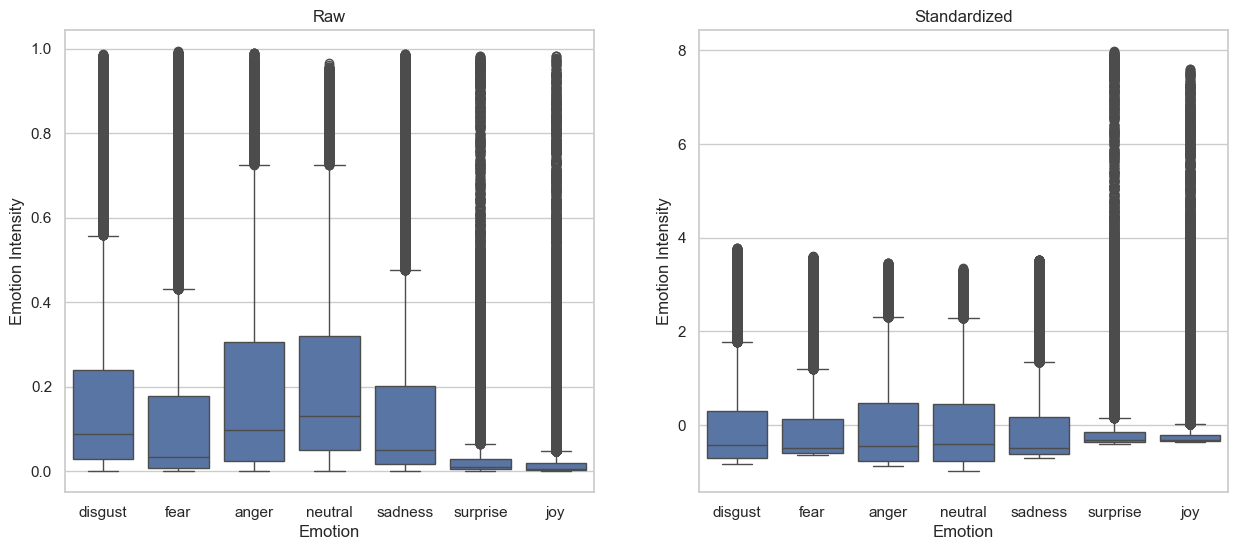

In [47]:
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(15, 6)) 
long_emotions = pd.melt(df_emotions, var_name='Emotion', value_name='Emotion Intensity')
long_emotions_standardized = pd.melt(df_emotions_standardized , var_name='Emotion', value_name='Emotion Intensity')
ax1= sns.boxplot(x="Emotion", y="Emotion Intensity", ax=axes[0], data=long_emotions)
ax1.set_title("Raw")
ax2 = sns.boxplot(x="Emotion", y="Emotion Intensity", ax=axes[1],data=long_emotions_standardized)
ax2.set_title("Standardized")

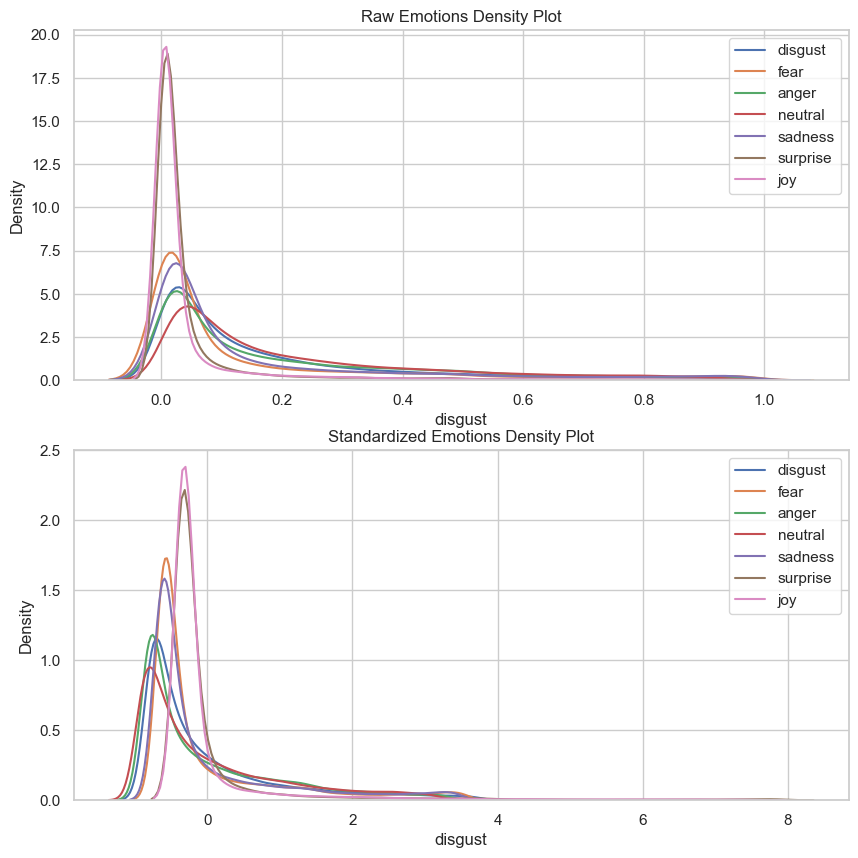

In [48]:
fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 10)) 
axes = axes.flatten()
for emotion in df_emotions.columns:
    ax1 = sns.kdeplot(data=df_emotions, x=emotion, ax=axes[0], label=emotion )
    ax1.set_title('Raw Emotions Density Plot')
    ax1.legend()
for emotion in df_emotions_standardized.columns:
    ax2 = sns.kdeplot(data=df_emotions_standardized, x=emotion, ax=axes[1], label=emotion )
    ax2.set_title('Standardized Emotions Density Plot')
    ax2.legend()

### 2.2 Analysis with dimensionality reduction

### PCA
Measures linear relationship between data points. PCA leverages correlation between dimensions to retain as much variance as possible while projecting the features to a lower dimensional space.


The results shows that all 7 principal components show significant variance, which is a sign for less correlation between dimensions. This is supported by the correlations shown in the table below. The visualization in 2d with the first two principal component only captures about 40% of the variance and therefore, might not be suitable for measuring the clustering quality.

In [49]:
pca = PCA(n_components=7)
pca.fit(df_emotions)

explained_variance_ratio = pca.explained_variance_ratio_
total_variance = sum(pca.explained_variance_ratio_)
print (total_variance)
print("Explained Variance Ratio per Principal Component: ", (explained_variance_ratio/total_variance) )

0.9999999999999998
Explained Variance Ratio per Principal Component:  [2.50840472e-01 2.33438355e-01 2.23083526e-01 1.76825303e-01
 6.57153431e-02 5.00970001e-02 1.28609782e-15]


### Compute Correlation
As assumed from the PCA results there is no high correlation between the emotions. The highest correlation value is about negative 0.3 between neutral and anger)

In [50]:
correlation_matrix = df_emotions.corr()
print(correlation_matrix)

           disgust      fear     anger   neutral   sadness  surprise       joy
disgust   1.000000 -0.222989 -0.054629 -0.222855 -0.239088 -0.186218 -0.180542
fear     -0.222989  1.000000 -0.199830 -0.272488 -0.226751 -0.055683 -0.165145
anger    -0.054629 -0.199830  1.000000 -0.297105 -0.260816 -0.154437 -0.205403
neutral  -0.222855 -0.272488 -0.297105  1.000000 -0.219383 -0.028890  0.094986
sadness  -0.239088 -0.226751 -0.260816 -0.219383  1.000000 -0.091668 -0.081771
surprise -0.186218 -0.055683 -0.154437 -0.028890 -0.091668  1.000000 -0.009015
joy      -0.180542 -0.165145 -0.205403  0.094986 -0.081771 -0.009015  1.000000


### 2.3 Ratings Distribution
Examining the distribution of the movie ratings shows an average rating of about 3.04 out of 5. The availabel rating values rtange from 0.5 to 5.0.

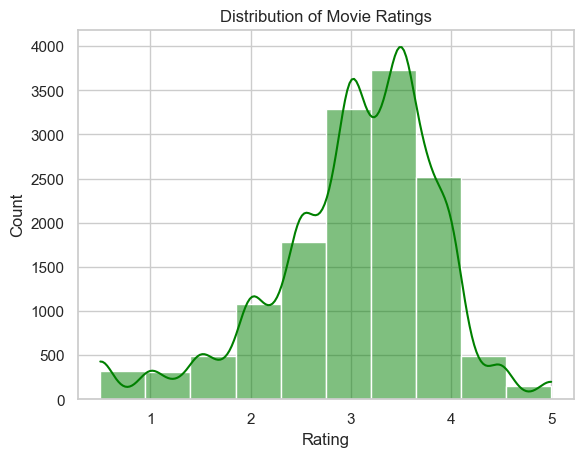

count    9139.000000
mean        3.044481
std         0.801812
min         0.500000
25%         2.625000
50%         3.152778
75%         3.571429
max         5.000000
Name: mean_ratings, dtype: float64


In [51]:
df_ratings = df_emotions.drop(columns = ["disgust","fear","anger","neutral","sadness", "surprise","joy"] )
df_ratings["mean_ratings"] = df.loc[df_emotions.index,"mean_ratings"]

sns.histplot(df['mean_ratings'], bins=10, kde=True, color='green')
plt.title('Distribution of Movie Ratings')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.show()

print(df_ratings["mean_ratings"].describe())

## 3. Clustering
To cluster the movies based on their structure of emotions we try different clustering algorithms:
- K-means clustering
- Hierarchical clustering
- DBSCAN
## 3.1 K-Means Clustering
### 3.1.1 Finding the optimal number of clusters k
For K-means, both shilouette score and ellbow method, reveal an optimal k of 7, which matches the number of emotions.

Text(0, 0.5, 'Silhouette score')

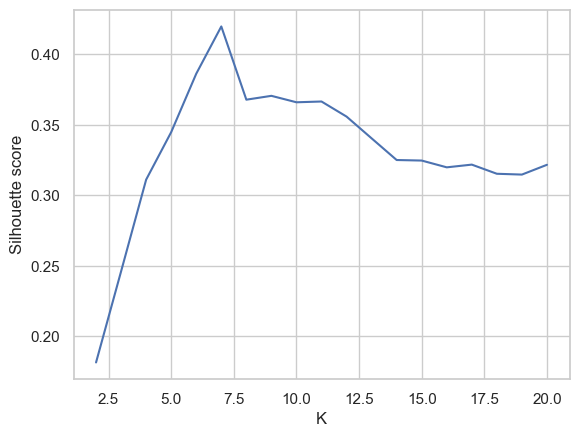

In [52]:
silhouettes = []

# Try multiple k
for k in range(2, 21):
    # Cluster the data and assigne the labels
    labels = KMeans(n_clusters=k, random_state=10).fit_predict(df_emotions_standardized)
    # Get the Silhouette score
    score = silhouette_score(df_emotions_standardized, labels)
    silhouettes.append({"k": k, "score": score})
    
# Convert to dataframe
silhouettes = pd.DataFrame(silhouettes)

# Plot the data
plt.plot(silhouettes.k, silhouettes.score)
plt.xlabel("K")
plt.ylabel("Silhouette score")

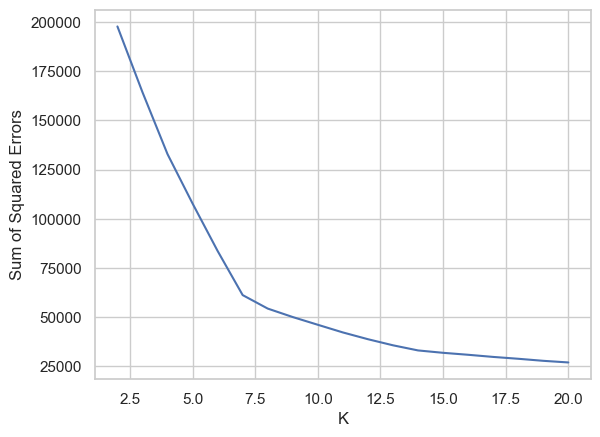

In [53]:
def plot_sse(df_emotions_standardized, start=2, end=21):
    sse = []
    for k in range(start, end):
        # Assign the labels to the clusters
        kmeans = KMeans(n_clusters=k, random_state=10).fit(df_emotions_standardized)
        sse.append({"k": k, "sse": kmeans.inertia_})

    sse = pd.DataFrame(sse)
    # Plot the data
    plt.plot(sse.k, sse.sse)
    plt.xlabel("K")
    plt.ylabel("Sum of Squared Errors")
    
plot_sse(df_emotions_standardized)

In [54]:
optimal_k = 7

## 3.1.2 Different cluster initializations to escape local optimums

The objective function of K-Means is to minimizing the within-cluster sum of squares (inertia). This is the metric it tries to minimize at each iteration. Therefore, initialization methods like k-means++' with n_init uses inertia to select the best initialization.

In [55]:
# Let KMeans do multiple initializations and pick the best
def find_best_init(X):
    km = KMeans(
        n_clusters=optimal_k, 
        init='k-means++', 
        n_init=1000,      # number of initial centroid sets
        random_state=42 # ensures reproducibility
    )
    km.fit(X)
    
    # The best run is now stored in km. 
    # You have reproducible results and the best solution without manual looping.
    labels = km.labels_
    inertia = km.inertia_
    
    print("Best inertia:", inertia)
    return km
km_best_init = find_best_init(df_emotions_standardized)

Best inertia: 61240.47091337241


The result shows that k-means++' with n_init= 1000 finds a cluster with a within-cluster distance of 61240.47. The improvements with an increasing number of n_init are marginal, as after n_init=10 the inertia is already at 61240. Therefore, we can assume that with the retrieved initialization we are near the global optimum in this setting with the k-means algorithm.

## 3.1.3 Visualization
## Visualization with PCA

Even though, the clusters are mainly separated in the 2-dimensional PCA space (using the first 4 PC), the centroids of each clusters are mostly gathered around a point in space. Thus, the linear method PCA is not suitable to display clear separation of the clusters, when reducing it to 2-dimensional space. This is due to the non-linearity of the data (see also the analyis before)

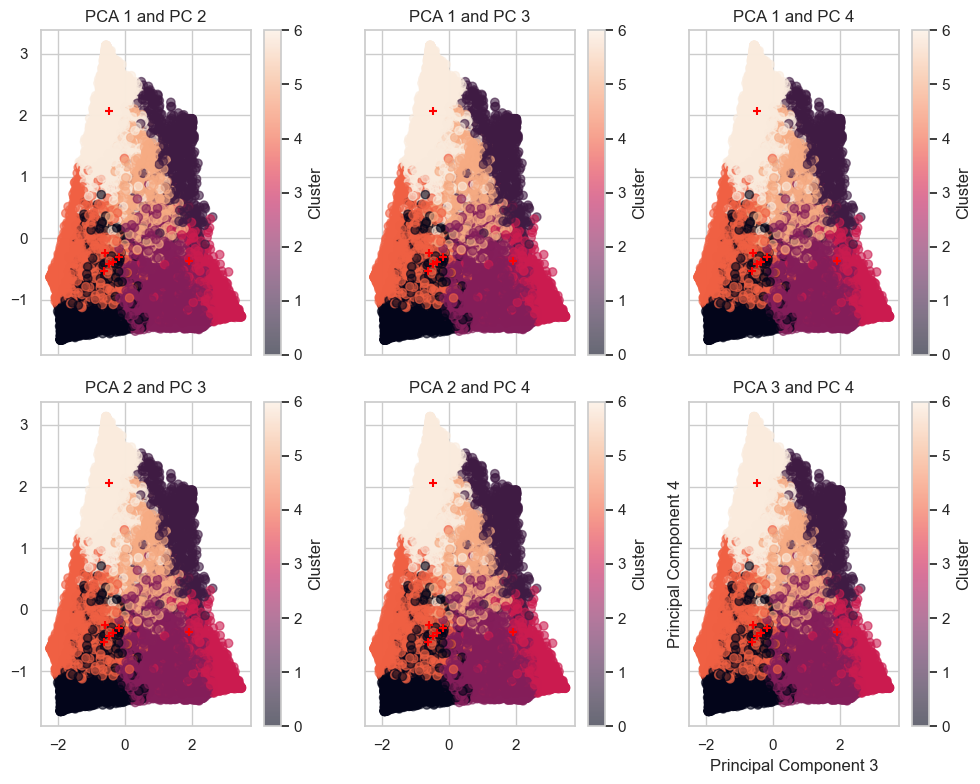

In [58]:
pca = PCA(n_components=4)
X_pca = pca.fit_transform(df_emotions_standardized)

COLUMNS = 3
ROWS = 2
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(10,8), sharey=True, sharex=True)
combinations = [[1, 2],[1, 3],[1, 4],[2, 3],[2, 4],[3, 4]]

for i, combination in enumerate(combinations):
    current_column = i % COLUMNS
    current_row = (i)//COLUMNS
    ax = axs[current_row, current_column]


    ax.scatter(X_pca[:,0], X_pca[:,1], c=km_best_init.labels_, alpha=0.6)
    ax.set_title(f"PCA {combination[0]} and PC {combination[1]}")
    plt.xlabel(f'Principal Component {combination[0]}')
    plt.ylabel(f'Principal Component {combination[1]}')
    cbar = plt.colorbar(ax.collections[0], ax=ax, label='Cluster')
    # Plot the centroids
    for c in km_best_init.cluster_centers_:
        ax.scatter(c[0], c[1], marker="+", color="red")

plt.tight_layout()

## Visualizing with t-sne

The 2-dimensional visualization with t-sne shows a similar result like PCA: Even though, t-sne can capture non-linearity the simplex shape and relevance of each emotion/ dimension of the data is not suitable to be broken down into 2-dimesions.

In [ ]:
X_tsne = TSNE(n_components=2, init='pca', learning_rate='auto', random_state=10).fit_transform(df_emotions_standardized)

COLUMNS = 3
ROWS = 2
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(10,8), sharey=True, sharex=True)
combinations = [[1, 2],[1, 3],[1, 4],[2, 3],[2, 4],[3, 4]]

for i, combination in enumerate(combinations):
    current_column = i % COLUMNS
    current_row = (i)//COLUMNS
    ax = axs[current_row, current_column]


    ax.scatter(X_tsne[:,0], X_tsne[:,1], c=km.labels_, alpha=0.6)
    ax.set_title(f"t-SNE {combination[0]} and t-SNE {combination[1]}")
    plt.xlabel(f't-SNE {combination[0]}')
    plt.ylabel(f't-SNE {combination[1]}')
    cbar = plt.colorbar(ax.collections[0], ax=ax, label='Cluster')
    # Plot the centroids
    for c in km.cluster_centers_:
        ax.scatter(c[0], c[1], marker="+", color="red")

plt.tight_layout()

## 3.1.4 Calculating cluster based consumer ratings
## Calculating ratings for each cluster

In [59]:
def calculate_cluster_ratings(X, kmeans):

    km = kmeans
    
    len(df_emotions_standardized)
    df_emotions.head()
    
    df_cluster_catings = df_emotions.drop(columns = ["disgust","fear","anger","neutral","sadness", "surprise","joy"] )
    df_cluster_emotions = X.copy()
    
    df_cluster_emotions["cluster"] = km.labels_
    df_cluster_emotions = df_cluster_emotions.groupby("cluster").mean().reset_index()
    
    df_cluster_catings["cluster"] = km.labels_
    df_cluster_catings["mean_ratings"] = df.loc[df_cluster_catings.index,"mean_ratings"]
    df_cluster_catings["count_ratings"]  = df.loc[df_cluster_catings.index,"count_ratings"]
    
    column_std = []
    column_mean = []
    unique = []
    for cluster in (np.unique(km.labels_)):
        column_std.append(df_cluster_catings[df_cluster_catings["cluster"] == cluster]["mean_ratings"].std())
        column_mean.append(df_cluster_catings[df_cluster_catings["cluster"] == cluster]["mean_ratings"].mean())
        unique.append(cluster)

    
    df_cluster_catings_grouped = df_cluster_catings.groupby("cluster").mean()
    df_cluster_catings_grouped_counts = df_cluster_catings.groupby('cluster').agg({
        'mean_ratings': 'count', "cluster": "count"  # Counts non-NaN entries in the 'ratings' column for each cluster
    })
    df_cluster_catings_grouped["rating_movies_count"] = df_cluster_catings_grouped_counts["mean_ratings"]
    df_cluster_catings_grouped["movies_count"] = df_cluster_catings_grouped_counts["cluster"]

    return df_cluster_emotions, df_cluster_catings_grouped

df_km_cluster_emotions, df_km_cluster_catings_grouped = calculate_cluster_ratings(df_emotions, km_best_init)

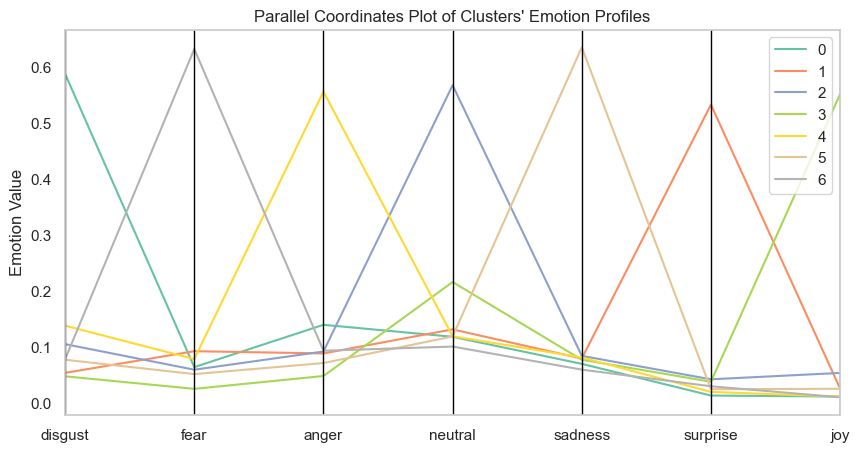

In [60]:
def plot_Parallel_Coordinates(df_cluster_emotions):
    plt.figure(figsize=(10, 5))
    parallel_coordinates(df_cluster_emotions, class_column='cluster', colormap=plt.get_cmap("Set2"))
    plt.title("Parallel Coordinates Plot of Clusters' Emotion Profiles")
    plt.ylabel("Emotion Value")
    plt.legend()
    plt.show()
plot_Parallel_Coordinates(df_km_cluster_emotions)

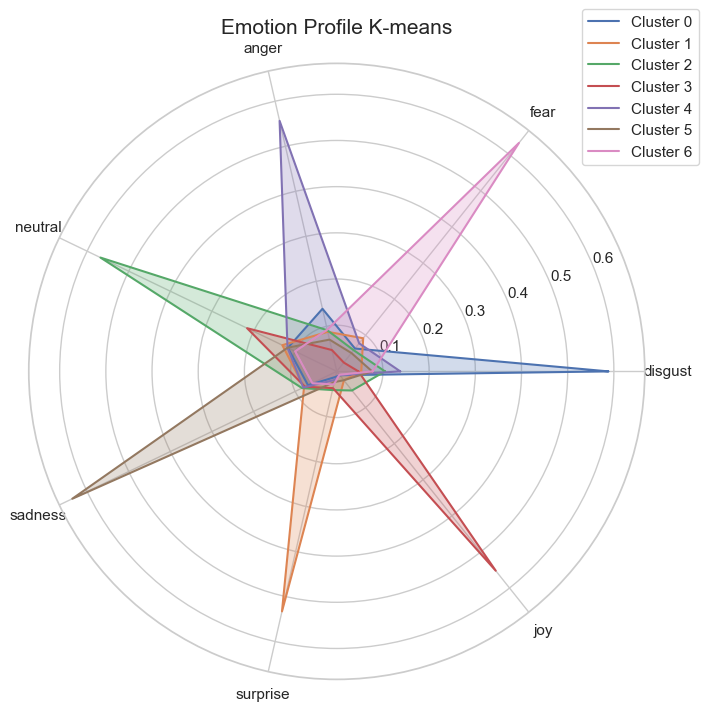

In [63]:
def plot_radar_chart(data, title):
    categories = data.columns
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for i, row in data.iterrows():
        values = row.tolist() + row.tolist()[:1]
        ax.plot(angles, values, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.25)
        
    ax.set_title(title, size=15)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()
plot_radar_chart(df_km_cluster_emotions[emotions_columns], "Emotion Profile K-means")

### K-means comparision with standardized emotions scores
The comparision shows that the clustering pattern is the same, when standardizing the data

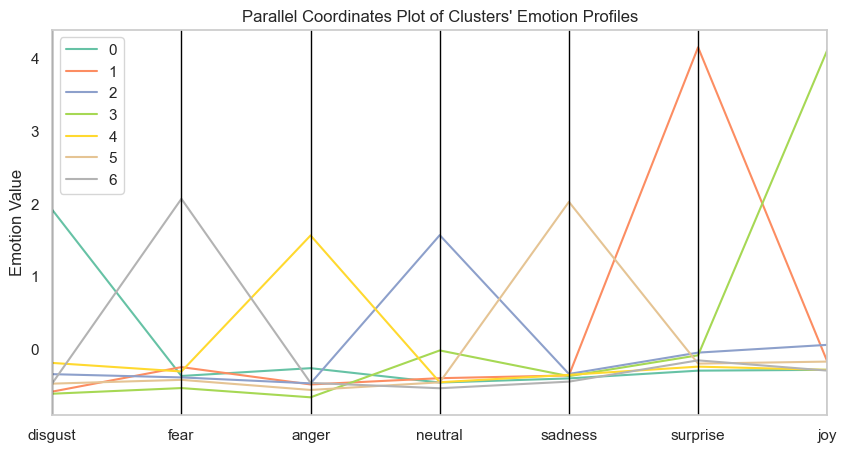

In [64]:
df_cluster_emotions, cluster_ratings = calculate_cluster_ratings(df_emotions_standardized, km_best_init)
plot_Parallel_Coordinates(df_cluster_emotions)

### Kmeans with cosine similarity raw emotions
Similar pattern is also shown using cosine distance metric instead of euclidean distance

Best inertia: 4702.391540661267


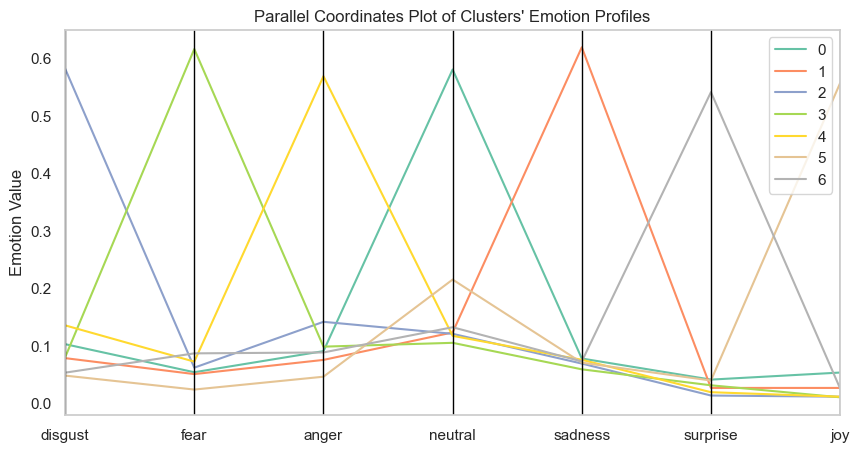

In [65]:
normalized_data = normalize(df_emotions, norm='l2')
kmeans_cosine = find_best_init(normalized_data)
df_cluster_emotions, cluster_ratings = calculate_cluster_ratings(df_emotions, kmeans_cosine)
plot_Parallel_Coordinates(df_cluster_emotions)

## Kmeans with cosine similarity standardized emotions

Best inertia: 7622.551336975672


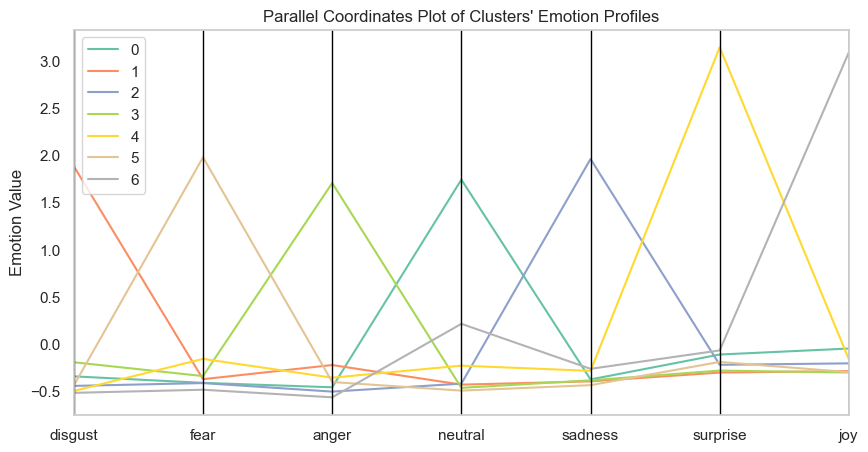

In [66]:
normalized_data = normalize(df_emotions_standardized, norm='l2')
kmeans_cosine = find_best_init(normalized_data)
df_cluster_emotions, cluster_ratings = calculate_cluster_ratings(df_emotions_standardized, kmeans_cosine)
plot_Parallel_Coordinates(df_cluster_emotions)

## 3.2 Hierarchical clustering

In [67]:
ratings = ['mean_ratings', 'std_dev_ratings']

filter_df = emotions_df.dropna(subset=['Plot'])
df_hierarchial = filter_df[emotions + ratings].reset_index(drop=True)

The data are already on the same scale and sum to 1 representing proportions of the emotional tone of the film so there is no need to normalize them.

We start from doing some exploration of the data.

To start, we perform a Hierchical Clustering o the data and plot the dendrogram to see if there are any clear clusters.

We will perform Hierchical Clustering with average linkage and Cosine distance. The Cosine distance is chosen because it is a measure of similarity between two non-zero vectors of an inner product space that measures the cosine of the angle between them. Thats works particularly well when the data are in distributed in a simplex like in this case.

Since Hierchical Clustiering computes dinstances between all pairs of points, it scales poorly with large dataset like ours. To have and understandig of the possible clusters we will use a subset of 500 data points.

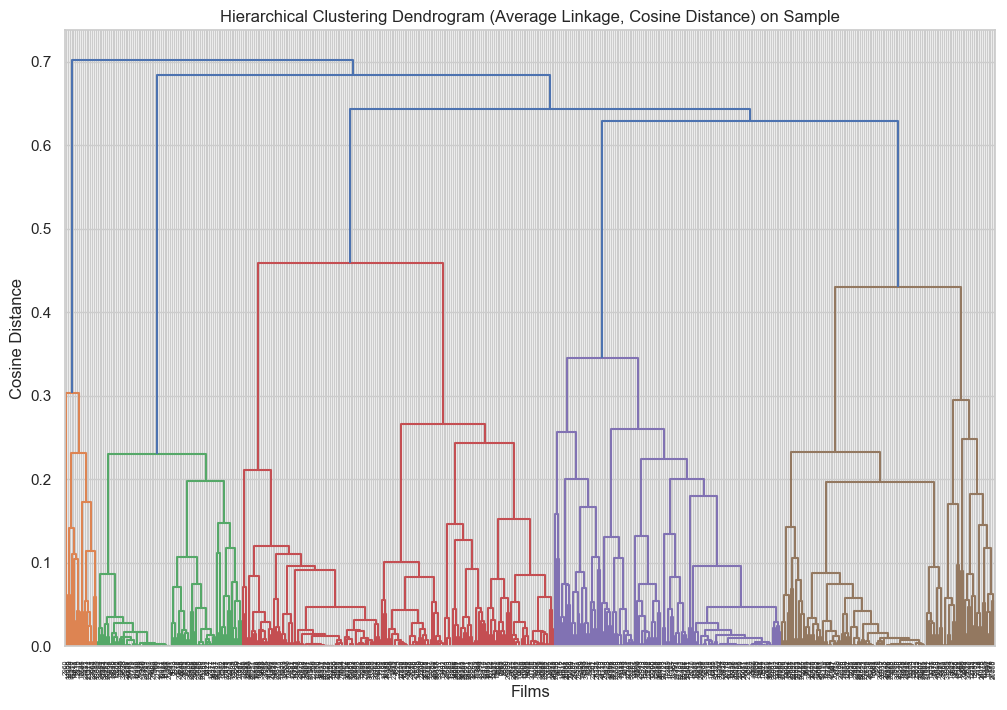

In [68]:
#Perform Hierarchical Clustering with average linkage and cosine distance, no normalization
from scipy.cluster.hierarchy import dendrogram, linkage, fcluster
from scipy.spatial.distance import pdist, squareform

sample_df = df_hierarchial.sample(500, random_state=42)

cluster_df = sample_df[emotions].copy()

distance_matrix = pdist(cluster_df, metric='cosine')
linkage_matrix = linkage(distance_matrix, method='average')

plt.figure(figsize=(12, 8))
dendrogram(linkage_matrix, labels=cluster_df.index, orientation='top')
plt.title('Hierarchical Clustering Dendrogram (Average Linkage, Cosine Distance) on Sample')
plt.xlabel('Films')
plt.ylabel('Cosine Distance')
plt.show()

In [69]:
cutoff = 0.36

cluster_labels = fcluster(linkage_matrix, t = cutoff, criterion='distance')
cluster_df['cluster'] = cluster_labels

distance_square = squareform(distance_matrix)

def compute_inner_cluster_distances(labels, distances):
    unique_clusters = np.unique(labels)
    inner_distances = {}
    for cluster in unique_clusters:
        indices = np.where(labels == cluster)[0]
        if len(indices) > 1:
            intra_dist = distances[np.ix_(indices, indices)].mean()
        else:
            intra_dist = 0  # Single-point cluster
        inner_distances[cluster] = intra_dist
    return inner_distances

inner_cluster_distances = compute_inner_cluster_distances(cluster_labels, distance_square)
inner_cluster_distances

{1: 0.17915203395297508,
 2: 0.1548717409338018,
 3: 0.08524913979233688,
 4: 0.19856307786260435,
 5: 0.22647867626450144,
 6: 0.1210515046783162,
 7: 0.20818028729421428}

In [70]:
sample_df = pd.concat([cluster_df, sample_df[ratings]], axis=1)
cluster_summary = sample_df.groupby('cluster').mean()
cluster_summary

disgust      fear     anger   neutral   sadness  surprise       joy  \
cluster                                                                         
1        0.109742  0.064062  0.089342  0.134547  0.073385  0.504592  0.024330   
2        0.095067  0.593484  0.150145  0.097640  0.034013  0.021828  0.007823   
3        0.097704  0.051368  0.646144  0.103608  0.058588  0.019774  0.022814   
4        0.474915  0.039981  0.229493  0.157039  0.073580  0.010769  0.014224   
5        0.098432  0.081701  0.098737  0.138472  0.529758  0.027796  0.025103   
6        0.066829  0.063999  0.076389  0.636251  0.056975  0.040132  0.059425   
7        0.080505  0.016390  0.058520  0.267902  0.117829  0.053301  0.405553   

         mean_ratings  std_dev_ratings  
cluster                                 
1            2.869160         0.997983  
2            2.792405         0.910411  
3            2.943252         0.997451  
4            3.106239         0.966592  
5            3.079460         1.061549  
6            3.022045         1.059960  
7            2.664684         1.026668

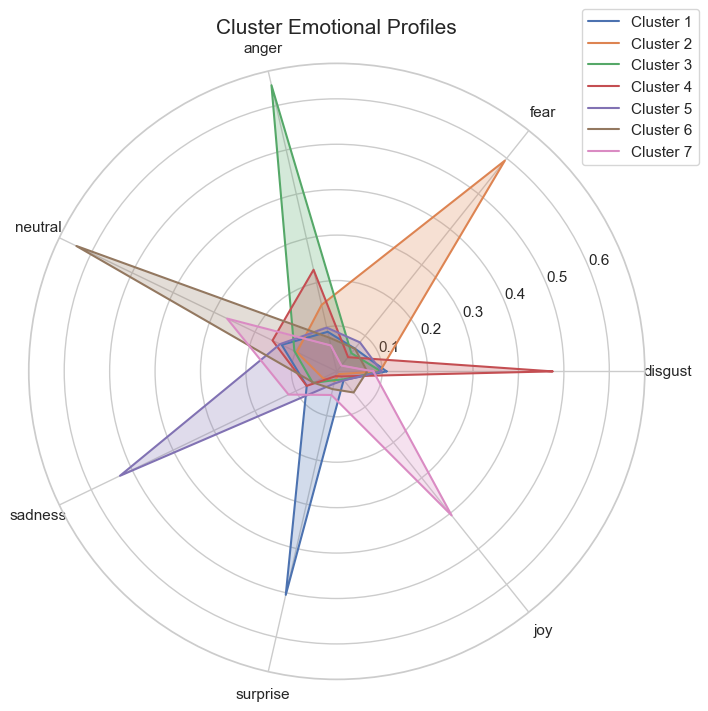

In [71]:
def plot_radar_chart(data, title):
    categories = data.columns
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]
    
    fig, ax = plt.subplots(figsize=(8, 8), subplot_kw=dict(polar=True))
    for i, row in data.iterrows():
        values = row.tolist() + row.tolist()[:1]
        ax.plot(angles, values, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.25)
        
    ax.set_title(title, size=15)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    plt.legend(loc='upper right', bbox_to_anchor=(1.1, 1.1))
    plt.show()

plot_radar_chart(cluster_summary[emotions], "Cluster Emotional Profiles")

# DBSCAN

In [72]:
dbscan = DBSCAN(eps=0.5, min_samples=2)
dbscan_standardized = dbscan.fit(df_emotions_standardized)
labels = dbscan_standardized.labels_

print("number of clusters", len(np.unique(labels)))

# Calculate Silhouette Score
# Filter out noise points
valid_clusters = df_emotions_standardized[labels != -1]
valid_labels = labels[labels != -1]

if len(np.unique(valid_labels)) > 1:  # Need at least 2 clusters to calculate
    silhouette_avg = silhouette_score(valid_clusters, valid_labels)
    print("Silhouette Score: ", silhouette_avg)
else:
    print("Not enough clusters to calculate the silhouette score.")

number of clusters 60
Silhouette Score:  -0.4825812756805062


In [73]:

def calculate_sum_of_within_cluster_distances(X, dbscan):
    total = 0.0
    for label in np.unique(dbscan.labels_):
        if label != -1:  # Ignore noise
            members = df_emotions_standardized[dbscan.labels_ == label]
            centroid = members.mean(axis=0)
            distances = np.sqrt(((members - centroid) ** 2).sum(axis=1))
            avg_distance = distances.mean()
            total += avg_distance
    
    print ("total within cluster distance", total)
    return total

## Findings DBSCAN

Standardized:
- eps: 0.1; filter movie_rating_count >5: anger& disgust bad; joy abd; no much profile bad

## Try different DBSCAN configurations

Metrics:
1. Sum of withing cluster distances
2. Number of clusters
3. Number of clusters with number of movies >5

First we look how the number of clusters and the number of movies within a cluster evolves over different eps values in DBSCAN. It quickly shows that we need eps values below 0.1 to get a significant amount of clusters

In [74]:
eps_list = np.linspace(0.01,0.3, 20)
for i in range(0, len(eps_list)):
    print(eps_list[i])
    dbscan = DBSCAN(eps=eps_list[i], min_samples=2)
    dbscan_raw = dbscan.fit(df_emotions)
    valid_clusters = df_emotions[labels != -1]
    valid_labels = labels[labels != -1]
    sum_distance =  calculate_sum_of_within_cluster_distances(df_emotions, dbscan_raw)
    print ("Sum of within cluster distances",sum_distance)
    df_cluster_emotions, cluster_ratings = calculate_cluster_ratings(df_emotions, dbscan_raw)
    print("Number of clusters", len(cluster_ratings))
    print("Number of clusters with number of movies >5", (cluster_ratings['movies_count'] > 5).sum())

0.01
total within cluster distance 16.15873400060603
Sum of within cluster distances 16.15873400060603
Number of clusters 660
Number of clusters with number of movies >5 37
0.02526315789473684
total within cluster distance 143.2065658948292
Sum of within cluster distances 143.2065658948292
Number of clusters 2179
Number of clusters with number of movies >5 159
0.04052631578947368
total within cluster distance 183.06166248638868
Sum of within cluster distances 183.06166248638868
Number of clusters 1646
Number of clusters with number of movies >5 145
0.05578947368421053
total within cluster distance 122.31641413973934
Sum of within cluster distances 122.31641413973934
Number of clusters 767
Number of clusters with number of movies >5 69
0.07105263157894737
total within cluster distance 68.29690155779456
Sum of within cluster distances 68.29690155779456
Number of clusters 328
Number of clusters with number of movies >5 30
0.0863157894736842
total within cluster distance 25.402606106204253

In [75]:
def plot_radar_chart_sub_plots(data, title, ax):
    categories = data.columns
    angles = np.linspace(0, 2 * np.pi, len(categories), endpoint=False).tolist()
    angles += angles[:1]

    # Plot each row of data
    for i, row in data.iterrows():
        values = row.tolist() + row.tolist()[:1]
        ax.plot(angles, values, label=f'Cluster {i}')
        ax.fill(angles, values, alpha=0.25)

    # Set title and tick labels
    ax.set_title(title, size=15)
    ax.set_xticks(angles[:-1])
    ax.set_xticklabels(categories)
    # Optionally adjust the radial limits
    # ax.set_ylim(0, some_max_value)
    ax.grid(True)


### Filter and visualize clusters with very low rating across eps values

Dominant pattern across multiple eps values:
- High "fear" score paired with some grain of "surprise", "sadness" or "neutral" (see eps (0.035, 0.045, 0.05, 0.055, 0.06

High negative score for small eps distance: 
- With very small eps (0.025 and 0.03), which indicates very similar emotion patterns, we see very low average cluster rating (

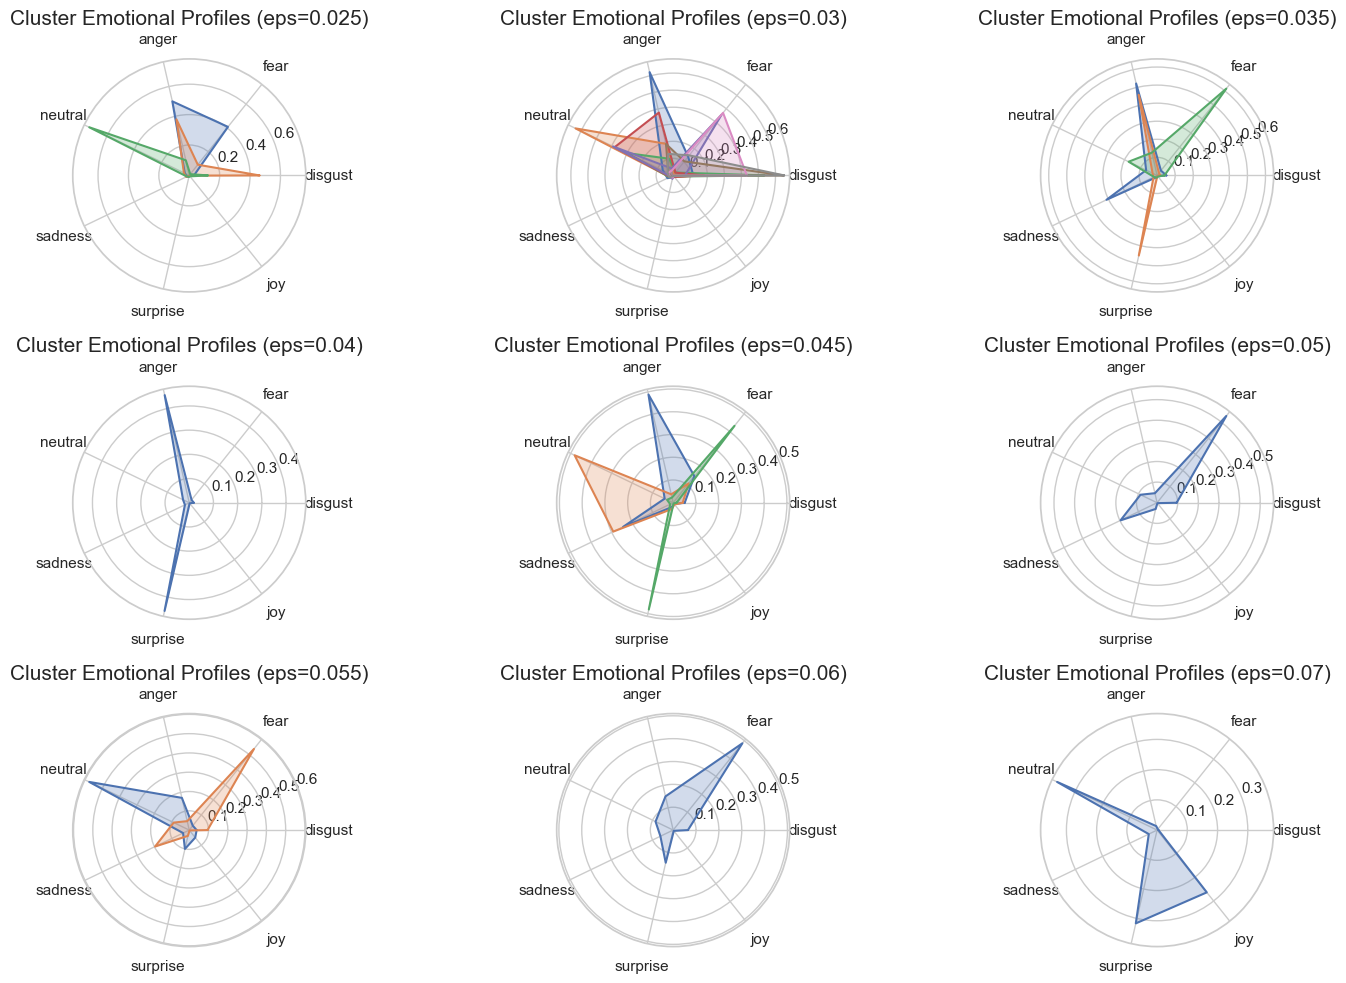

In [80]:

ROWS = 3
COLUMNS = 3
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(15, 10), subplot_kw=dict(polar=True))

# Flatten axs for easier indexing if needed
axs = axs.ravel()

# Example combinations or parameters for each subplot
combinations = [0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.07]

for i, eps_val in enumerate(combinations):
    ax = axs[i]
    dbscan = DBSCAN(eps=eps_val, min_samples=2)
    dbscan_raw = dbscan.fit(df_emotions)
    df_cluster_emotions, cluster_ratings = calculate_cluster_ratings(df_emotions, dbscan_raw)
    merged_inner = pd.merge(df_cluster_emotions, cluster_ratings, on='cluster', how='inner')
    
    # Filter for the clusters you want to plot
    filtered_clusters_raw = merged_inner[(merged_inner['rating_movies_count'] > 3) & 
                                         (merged_inner['mean_ratings'] < 2.5)]
    
    # Plot the radar chart on the given subplot axis
    plot_radar_chart_sub_plots(filtered_clusters_raw[emotions_columns],
                               f"Cluster Emotional Profiles (eps={eps_val})",
                               ax)

plt.tight_layout()
plt.show()


Very low average cluster score (more 1.25 times of standard deviation) with dominant emotions disgust

In [77]:
dbscan = DBSCAN(eps=0.03, min_samples=2)
dbscan_raw = dbscan.fit(df_emotions)
df_cluster_emotions, cluster_ratings = calculate_cluster_ratings(df_emotions, dbscan_raw)
merged_inner = pd.merge(df_cluster_emotions, cluster_ratings, on='cluster', how='inner')
filtered_clusters_raw = merged_inner[(merged_inner['rating_movies_count'] > 3) & (merged_inner['mean_ratings'] <2.2)]
print(filtered_clusters_raw[['mean_ratings', "rating_movies_count"]])

     mean_ratings  rating_movies_count
31       2.063176                    4
731      2.039931                    8


### Filter and visualize clusters with very high rating across eps values

Dominant pattern across multiple eps values:
- “surprise” coupled with “sadness,” or films where “neutral” and “joy”
- high disgust intertwined with a bit of anger, a dash of neutral, and a hint of sadness—but crucially, without fear.

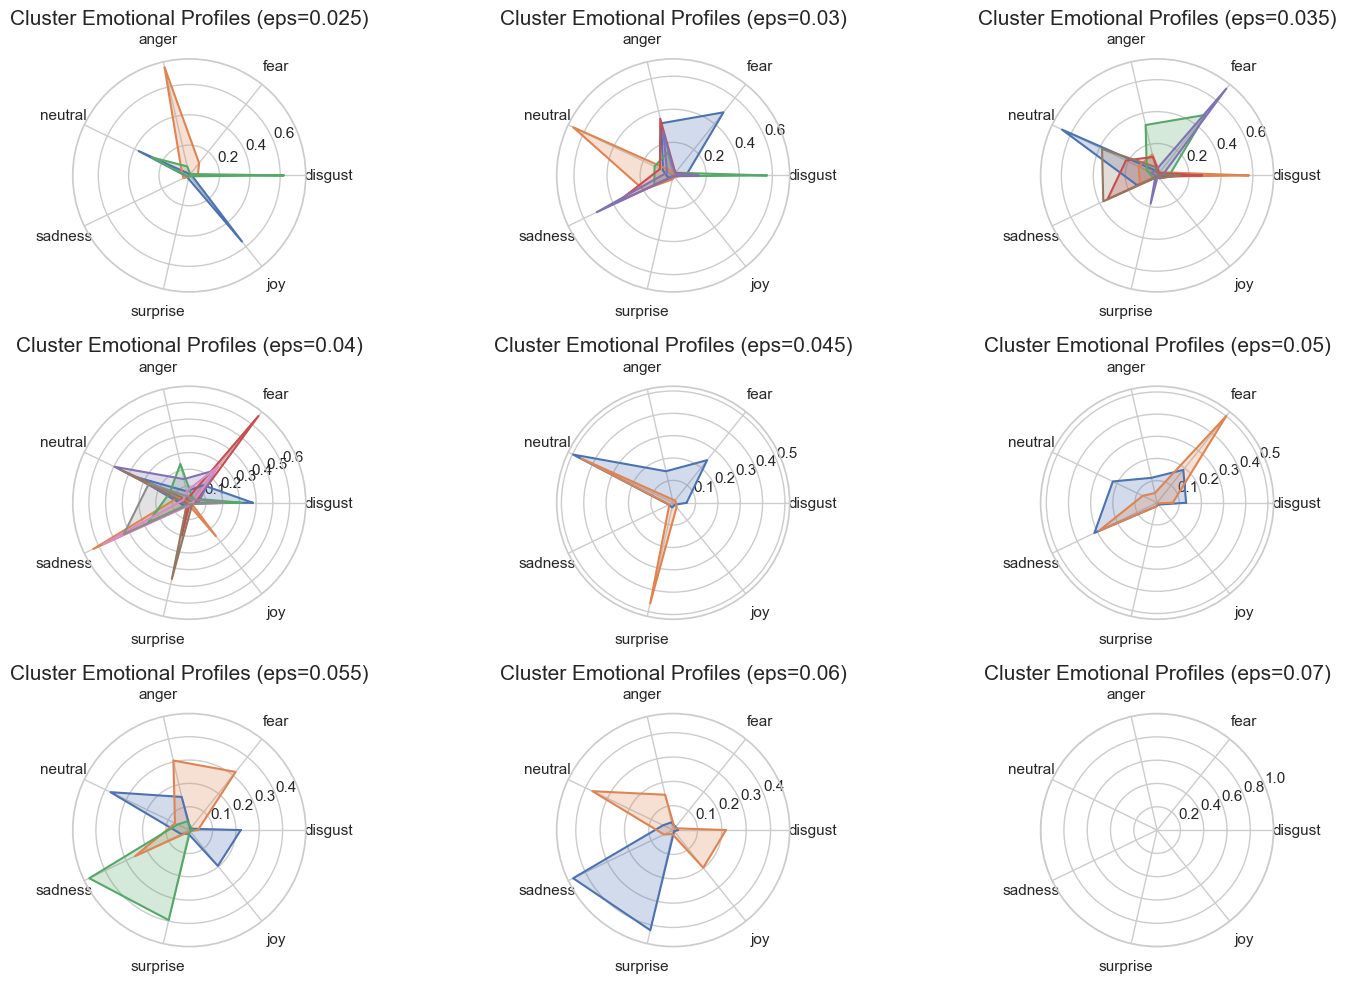

In [78]:
ROWS = 3
COLUMNS = 3
fig, axs = plt.subplots(ROWS, COLUMNS, figsize=(15, 10), subplot_kw=dict(polar=True))

# Flatten axs for easier indexing if needed
axs = axs.ravel()

# Example combinations or parameters for each subplot
combinations = [0.025, 0.03, 0.035, 0.04, 0.045, 0.05, 0.055, 0.06, 0.07]

for i, eps_val in enumerate(combinations):
    ax = axs[i]
    dbscan = DBSCAN(eps=eps_val, min_samples=2)
    dbscan_raw = dbscan.fit(df_emotions)
    df_cluster_emotions, cluster_ratings = calculate_cluster_ratings(df_emotions, dbscan_raw)
    merged_inner = pd.merge(df_cluster_emotions, cluster_ratings, on='cluster', how='inner')
    
    # Filter for the clusters you want to plot
    filtered_clusters_raw = merged_inner[(merged_inner['rating_movies_count'] > 3) & 
                                         (merged_inner['mean_ratings'] > 3.5)]
    
    # Plot the radar chart on the given subplot axis
    plot_radar_chart_sub_plots(filtered_clusters_raw[emotions_columns],
                               f"Cluster Emotional Profiles (eps={eps_val})",
                               ax)

plt.tight_layout()
plt.show()